In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib

timer = mypackage.Timer()

TensorFlow version is 2.1.0


Using TensorFlow backend.


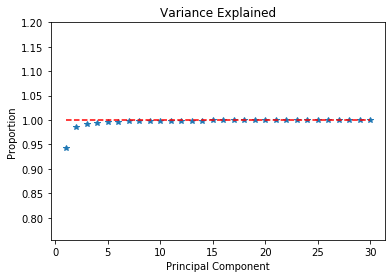

In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)
X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')

X_train_orig, X_test_orig = mypackage.Dataset.PCA(X_train_orig, X_test_orig, n_components=30, plot=True, whiten=True)

# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# # load the scaler from disk
# scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=True: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [3]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 1
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=False)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=False)
#######################################################

# Test HybridSN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 30, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

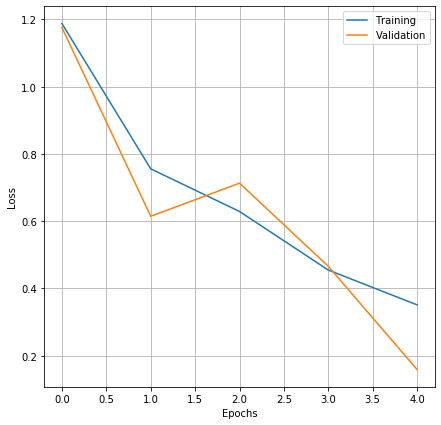

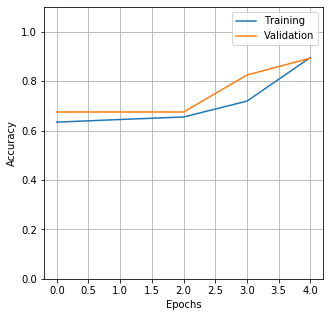

/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96     28183
         1.0       0.90      0.85      0.88     14004
         2.0       0.00      0.00      0.00       821

    accuracy                           0.92     43008
   macro avg       0.61      0.61      0.61     43008
weighted avg       0.90      0.92      0.91     43008



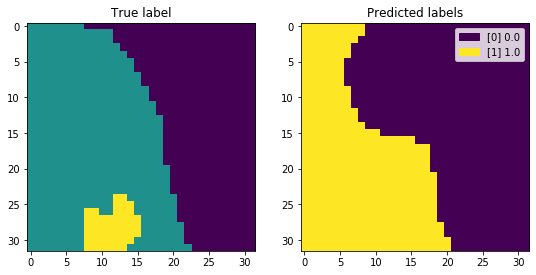

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94     13134
         1.0       0.87      0.77      0.81      5939
         2.0       0.00      0.00      0.00       383

    accuracy                           0.89     19456
   macro avg       0.59      0.58      0.58     19456
weighted avg       0.87      0.89      0.88     19456



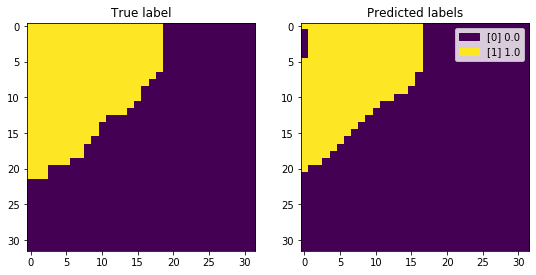

Elapsed time: 158.7189 seconds
Fasle positive blobs 0


In [4]:
n_train = 16 # if 16 then 30min per epoch
n_test  = 4
model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat, Y_test_HS)}")

In [5]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

m = 5
X_train_svm, Y_train_svm = zoom(X_train_orig, Y_train_orig, s, m)
X_test_svm,  Y_test_svm  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (-18.377695083618164, 24.86631965637207) (570, 32, 32, 30) (1260, 32, 32, 30)
(array([0., 1., 2.]), array([1080250,  196825,   13165]))
(array([0., 1., 2.]), array([455078, 122417,   6185]))


# Testing SVM

In [6]:
# Started the training at ~16:30
# Finished training at ~17:00

In [7]:
Y_train_orig.shape, Y_test_orig.shape

((42, 100, 100, 1), (19, 100, 100, 1))

In [8]:
Y_train_svm.shape, Y_test_svm.shape

((210, 32, 32, 1), (95, 32, 32, 1))

Elapsed time: 211.9660 seconds
Elapsed time: 89.6961 seconds
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    177893
         1.0       0.99      0.99      0.99     33938
         2.0       0.99      0.97      0.98      3209

    accuracy                           1.00    215040
   macro avg       0.99      0.98      0.99    215040
weighted avg       1.00      1.00      1.00    215040

Elapsed time: 40.5647 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     74780
         1.0       0.98      0.96      0.97     21673
         2.0       0.87      0.70      0.78       827

    accuracy                           0.99     97280
   macro avg       0.95      0.89      0.91     97280
weighted avg       0.99      0.99      0.99     97280

Fasle positive blobs 24.
Fasle positive blobs per image 0.2526


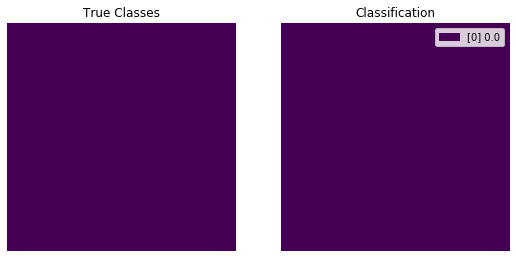

In [9]:
from sklearn import svm
from sklearn.metrics import classification_report

svm = mypackage.SVM(X_train_svm, Y_train_svm)
svm.train()
svm.predict(X_train_svm, Y_train_svm, plot=False)
Y_hat = svm.predict(X_test_svm, Y_test_svm)

mypackage.report_count_false_positive(Y_hat, Y_test_svm)

In [10]:
# mypackage.plot_labeled_images(Y_hat, Y_test_svm)

# Testing Logistic Regression

Elapsed time: 12.9107 seconds
Elapsed time: 0.1832 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1080250
         1.0       0.96      0.96      0.96    196825
         2.0       0.91      0.62      0.73     13165

    accuracy                           0.99   1290240
   macro avg       0.95      0.86      0.90   1290240
weighted avg       0.99      0.99      0.99   1290240

Elapsed time: 0.0679 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    455078
         1.0       0.98      0.95      0.96    122417
         2.0       0.89      0.68      0.77      6185

    accuracy                           0.98    583680
   macro avg       0.95      0.88      0.91    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 63.
Fasle positive blobs per image 0.1105


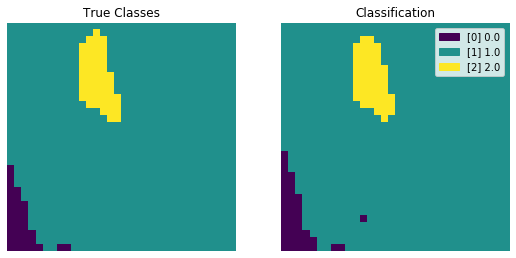

In [11]:
logreg = mypackage.LogReg(X_train, Y_train, C=1e5, max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

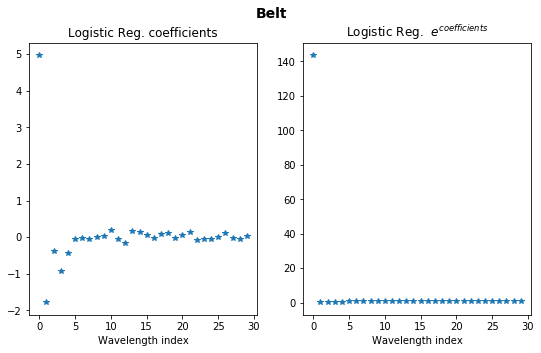

Ordered four most useful wavelengths are: [928, 964, 975, 1004]nm
There corresponding indexes are: [ 0 10 13 21]


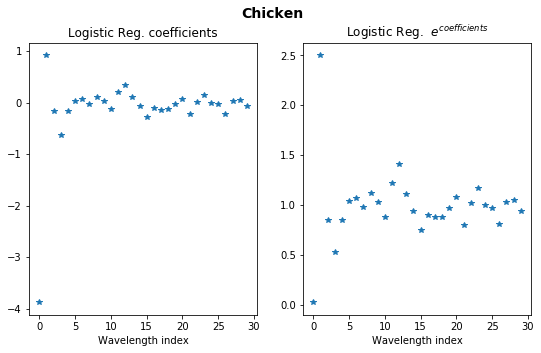

Ordered four most useful wavelengths are: [932, 971, 968, 1011]nm
There corresponding indexes are: [ 1 12 11 23]


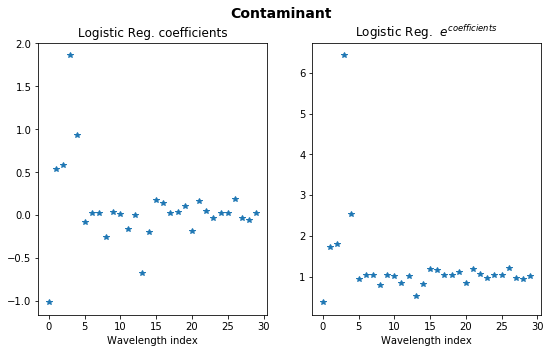

Ordered four most useful wavelengths are: [939, 942, 935, 932]nm
There corresponding indexes are: [3 4 2 1]


In [13]:
# logit(p) = log(p/(1-p) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

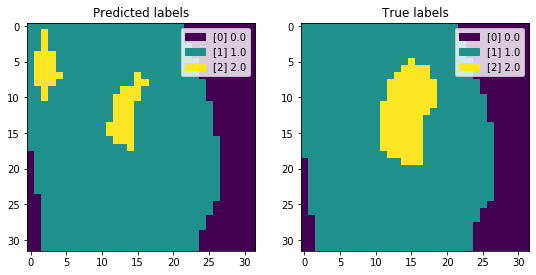

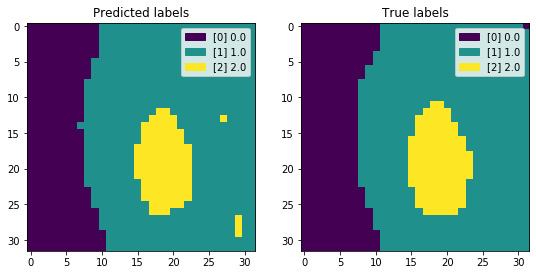

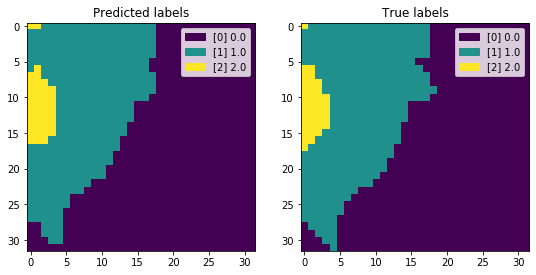

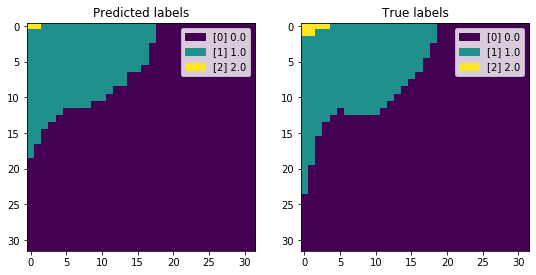

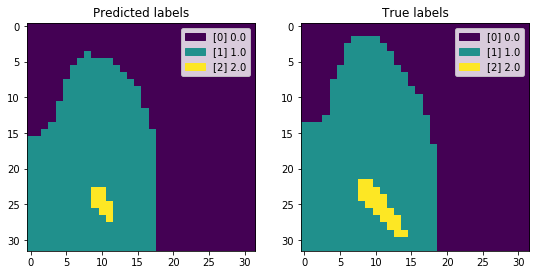

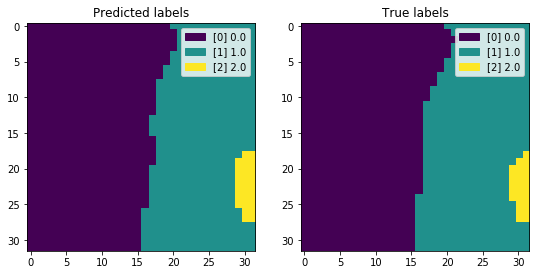

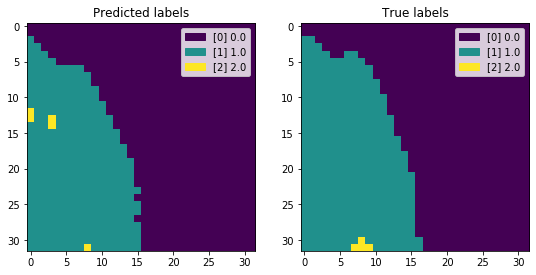

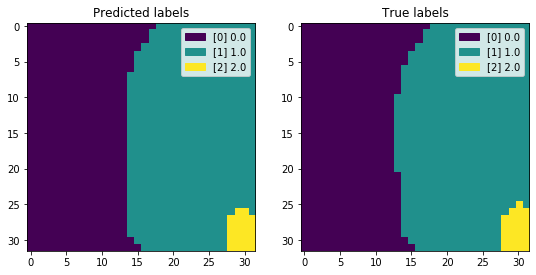

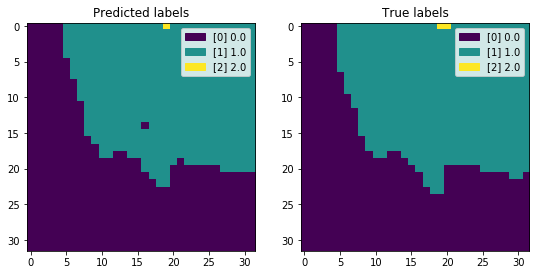

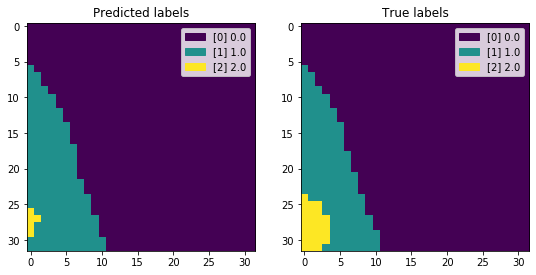

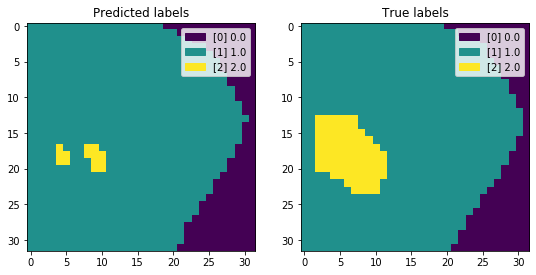

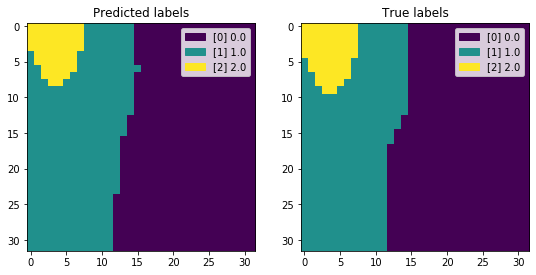

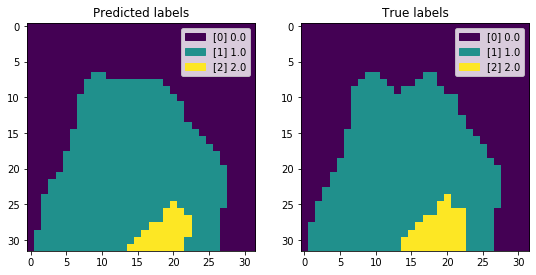

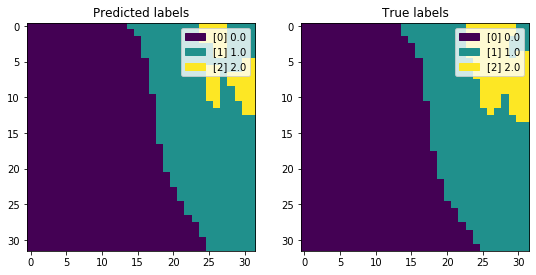

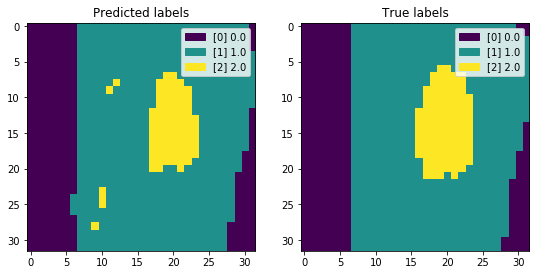

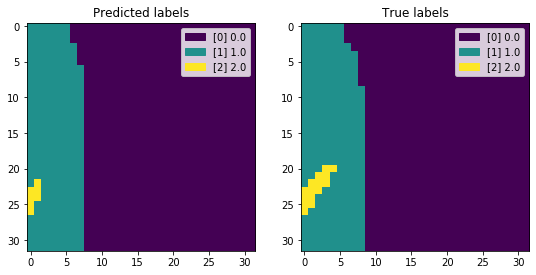

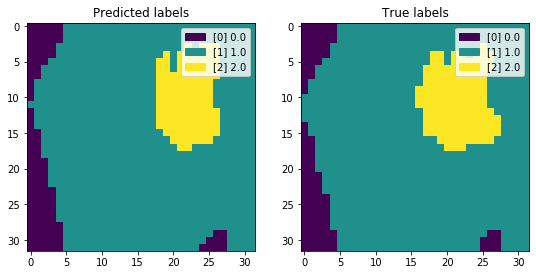

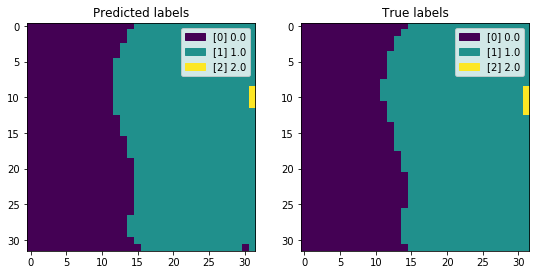

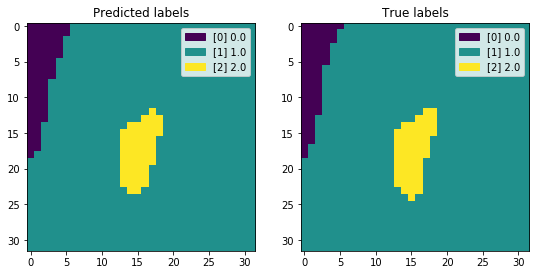

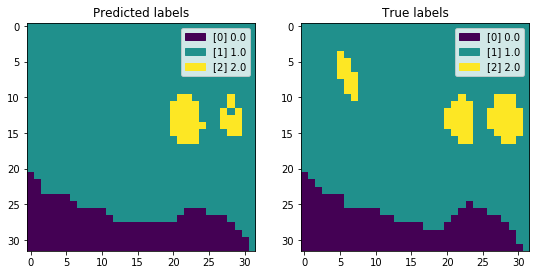

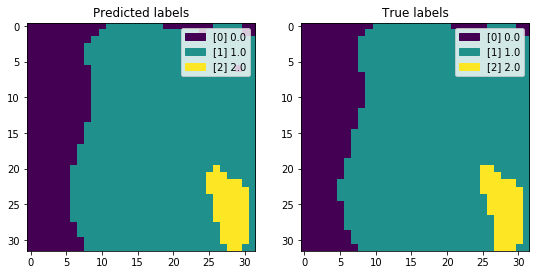

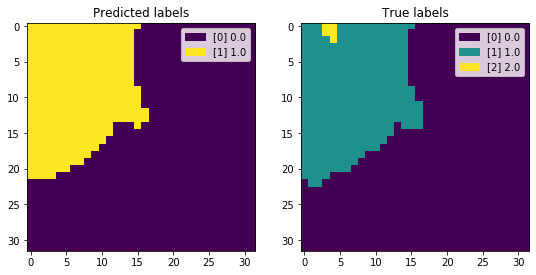

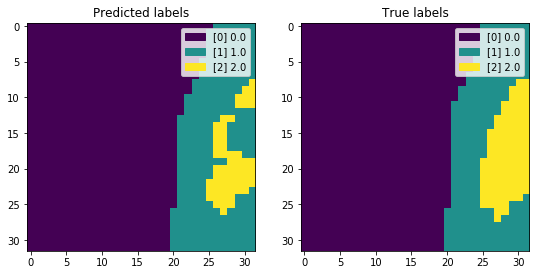

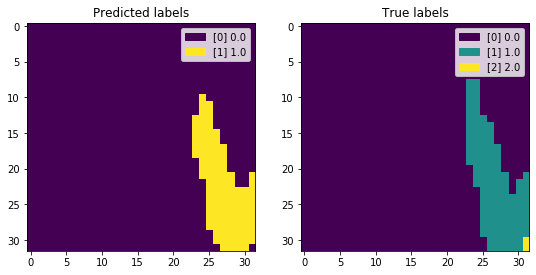

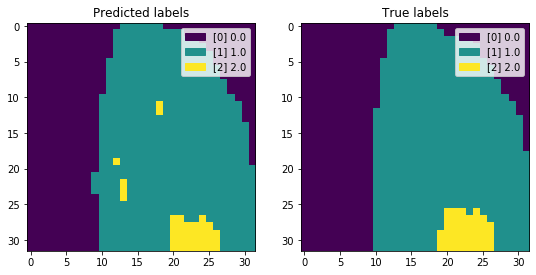

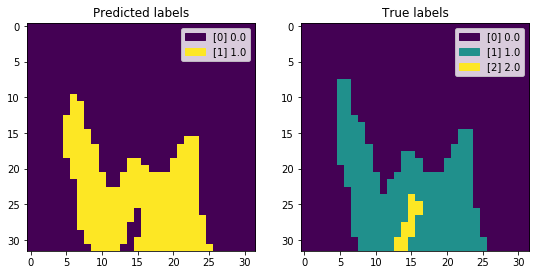

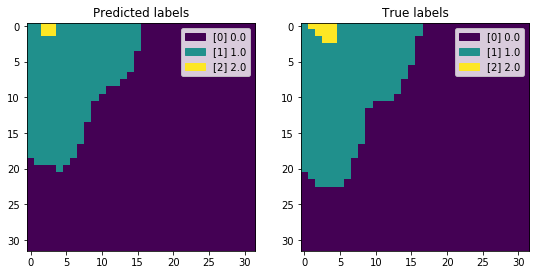

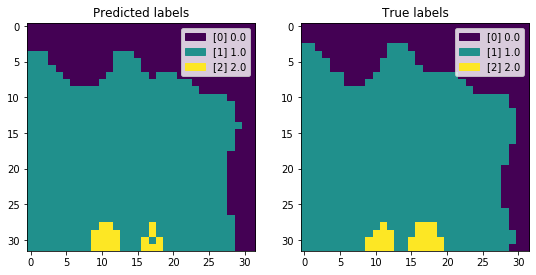

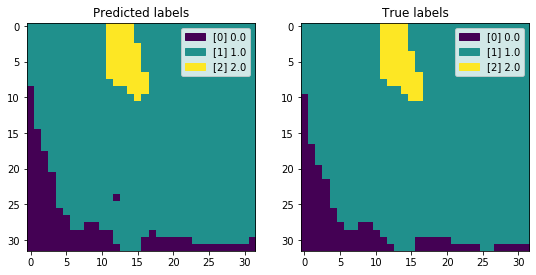

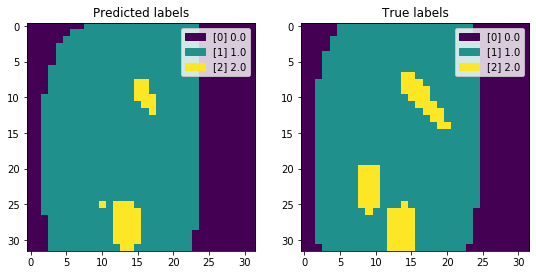

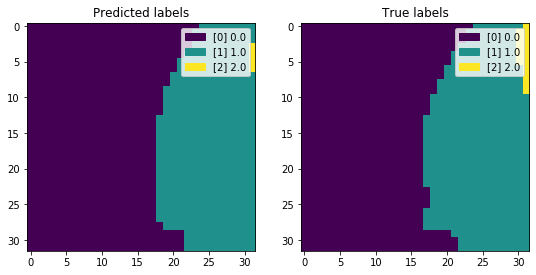

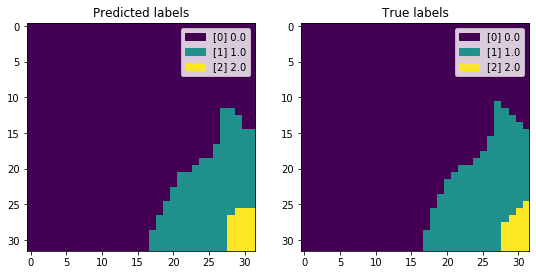

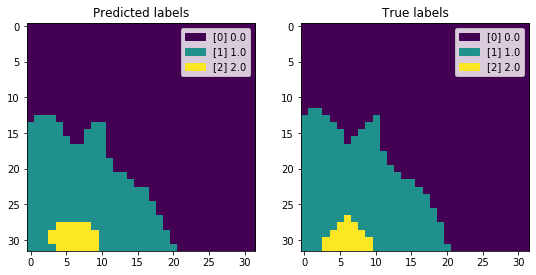

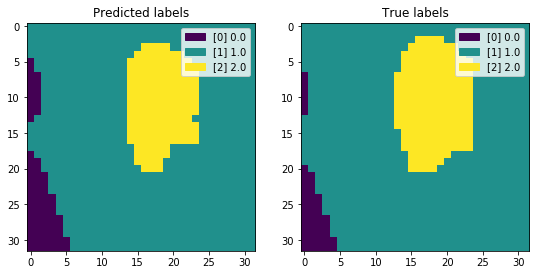

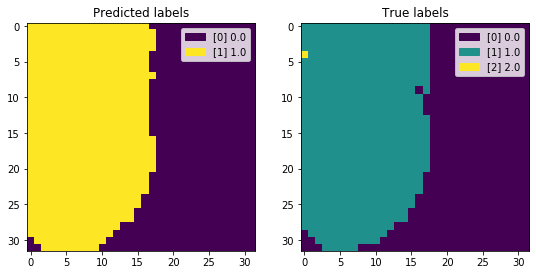

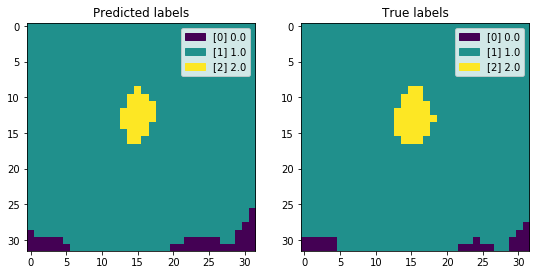

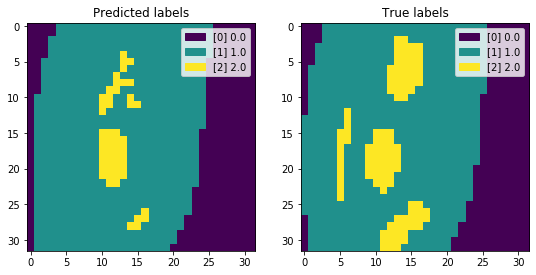

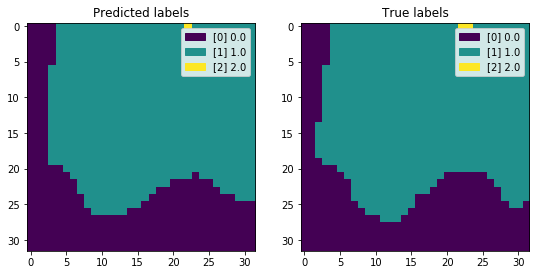

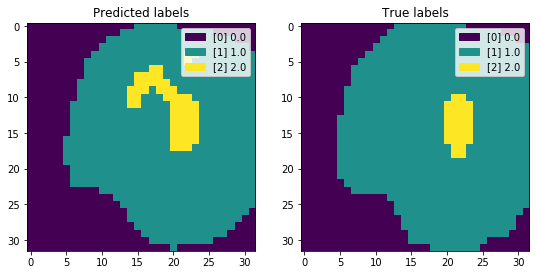

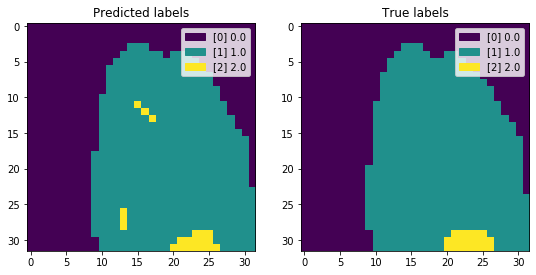

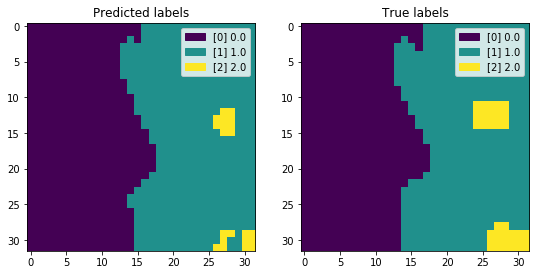

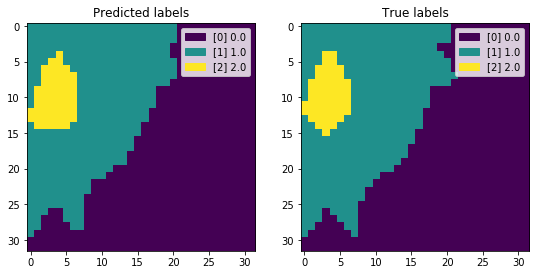

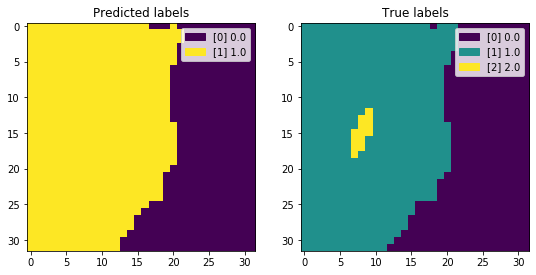

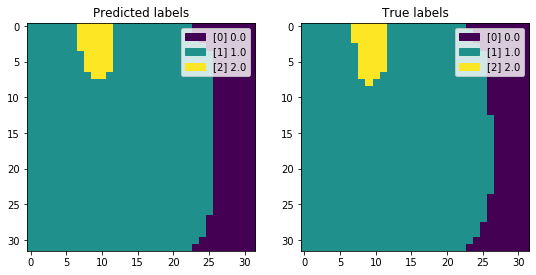

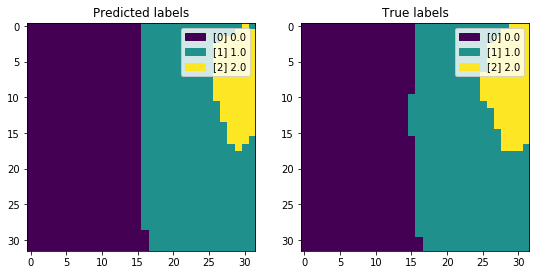

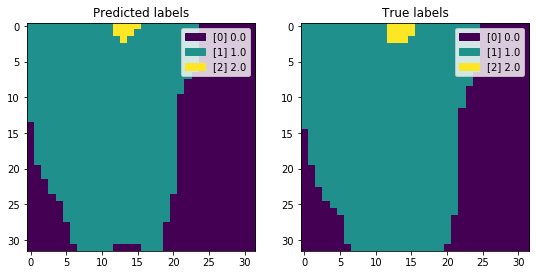

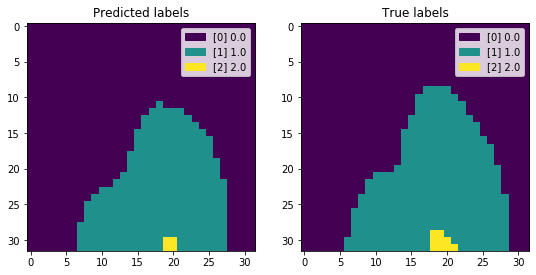

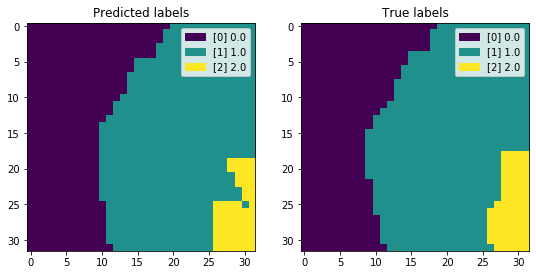

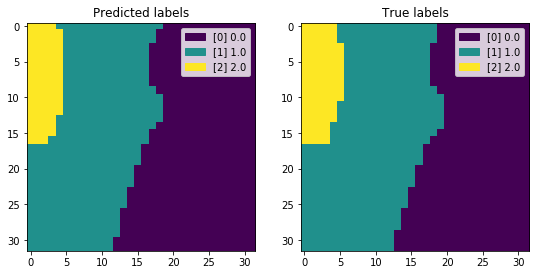

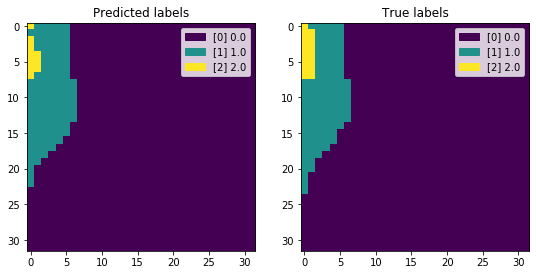

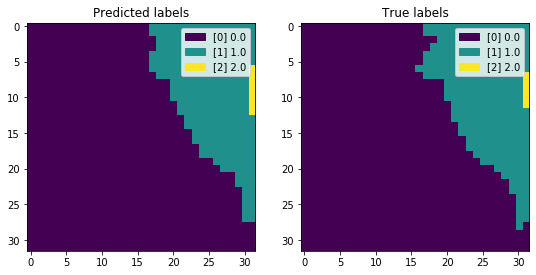

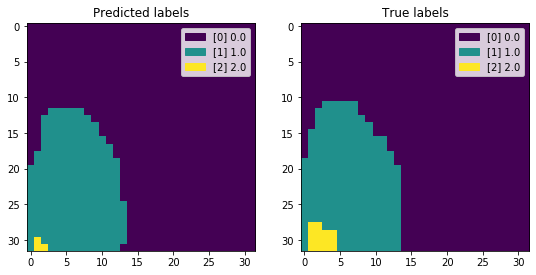

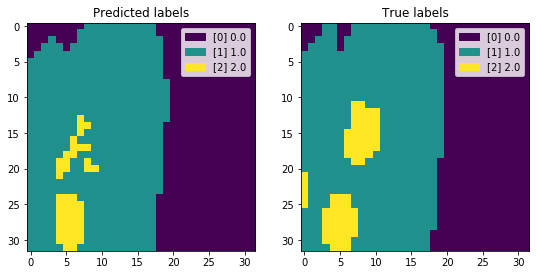

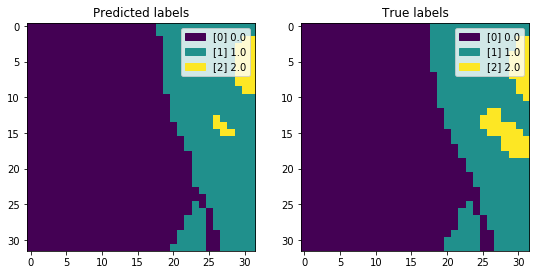

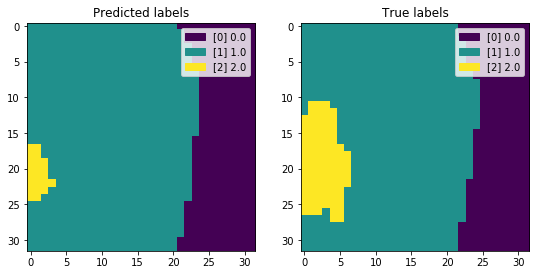

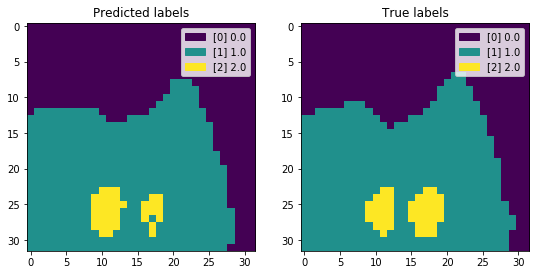

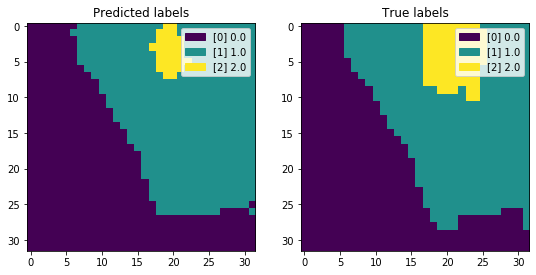

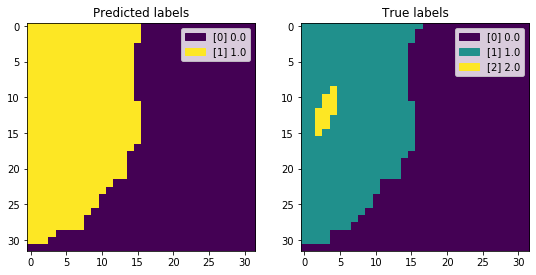

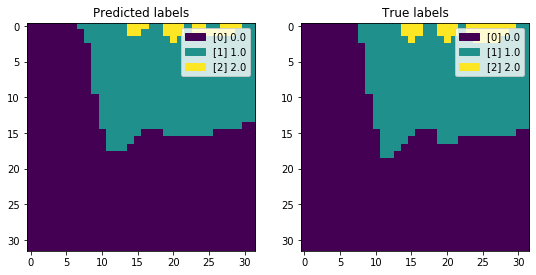

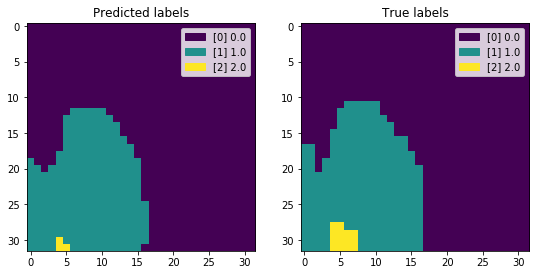

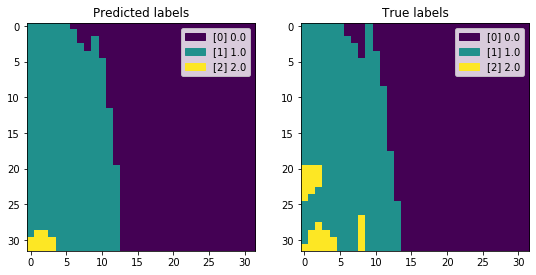

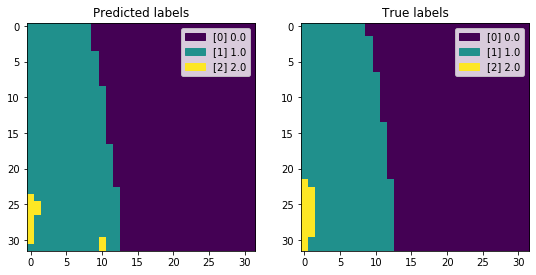

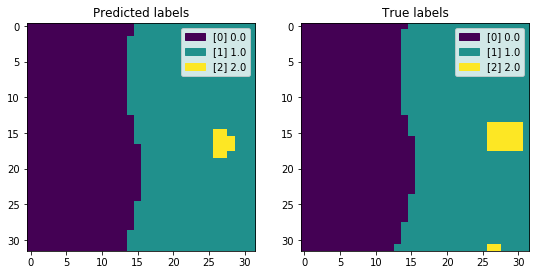

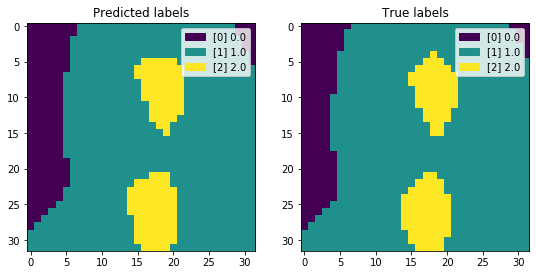

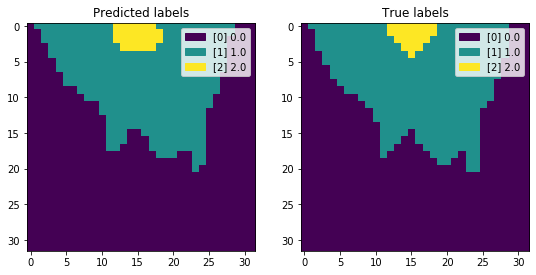

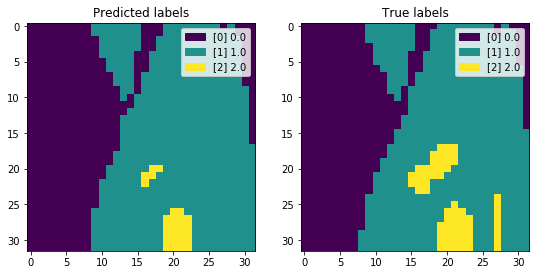

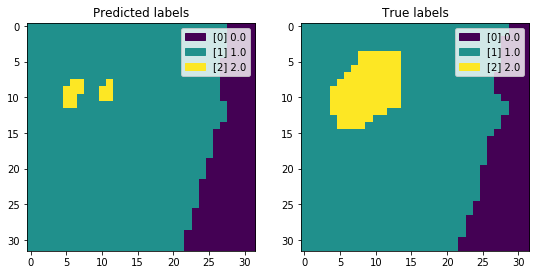

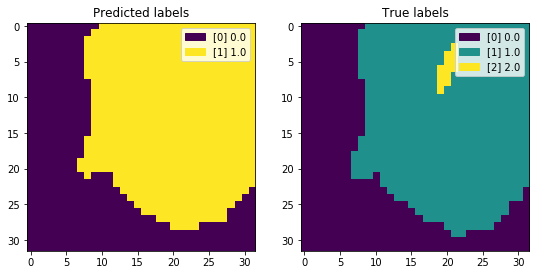

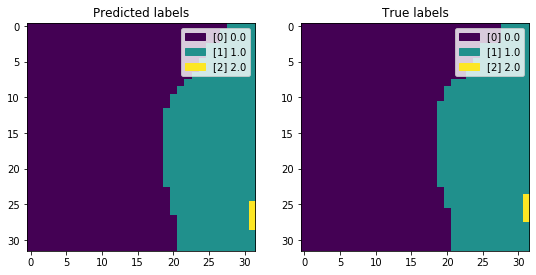

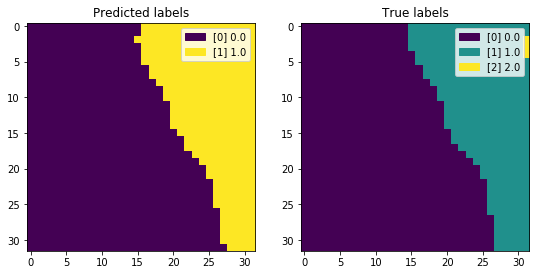

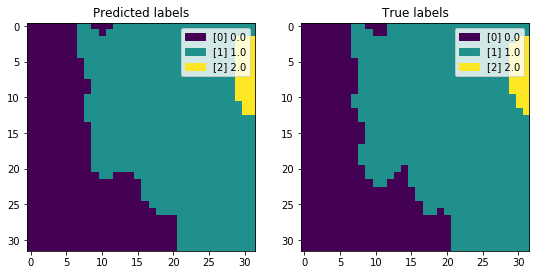

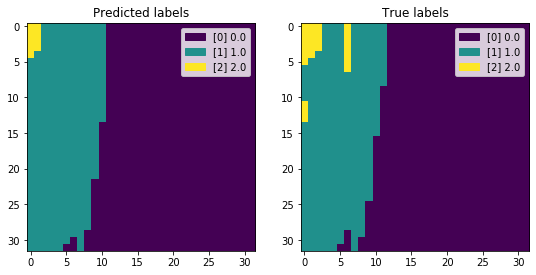

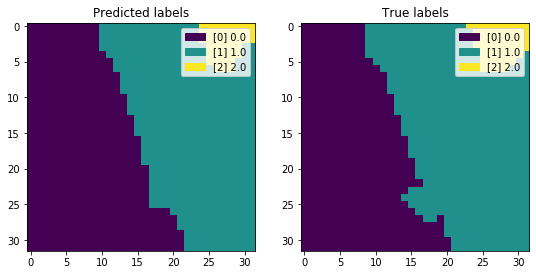

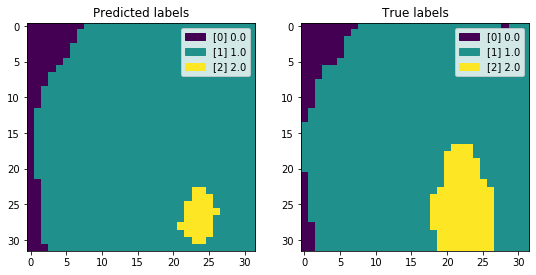

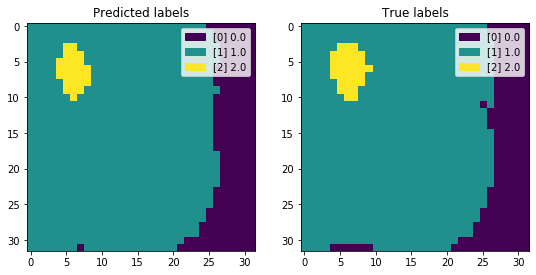

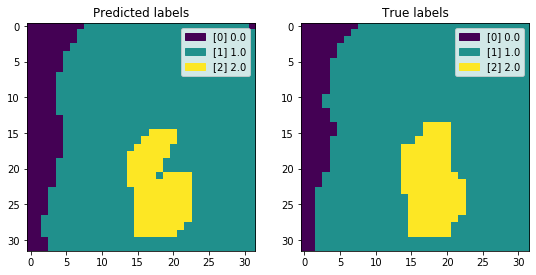

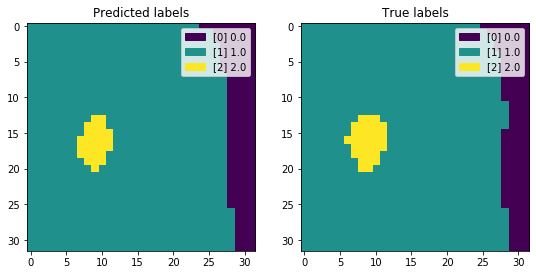

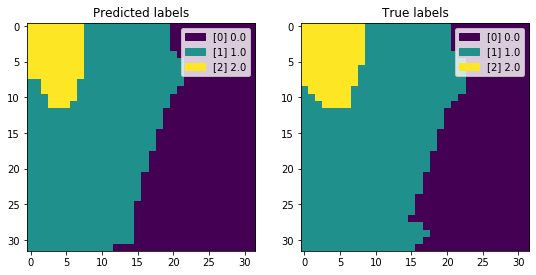

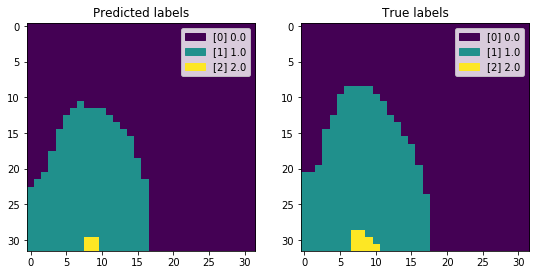

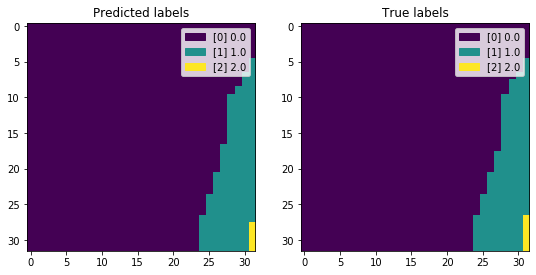

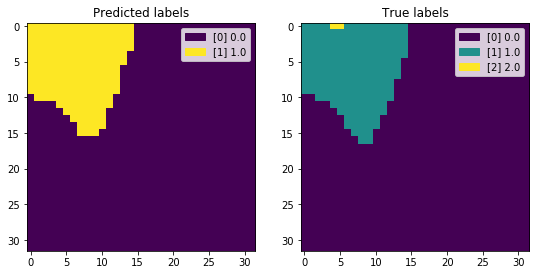

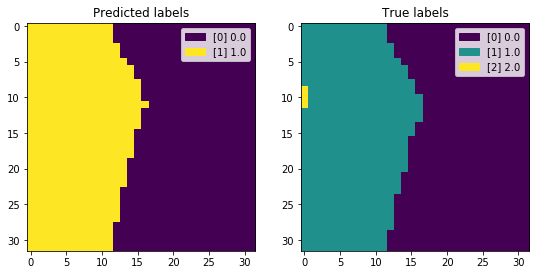

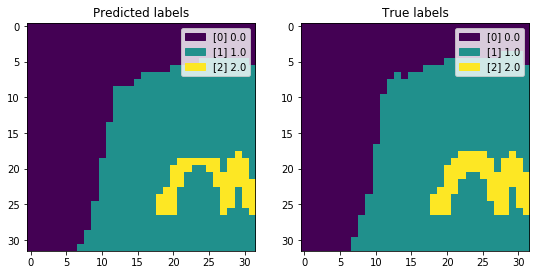

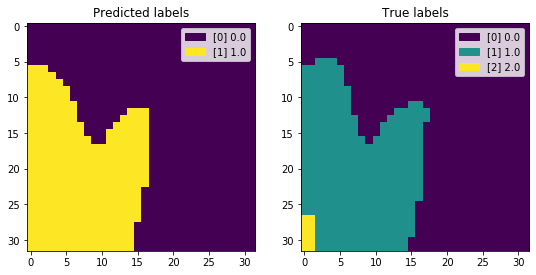

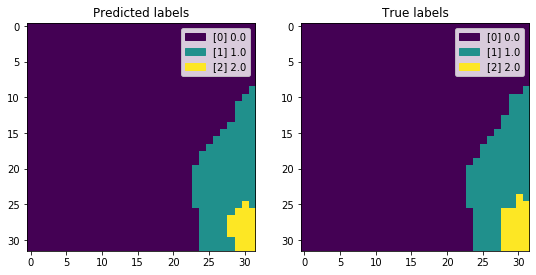

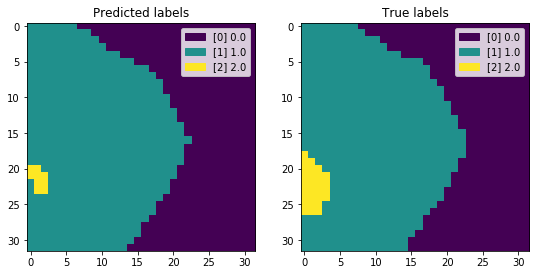

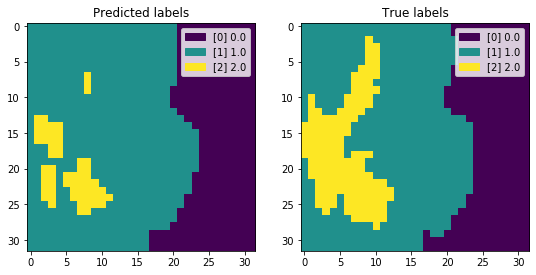

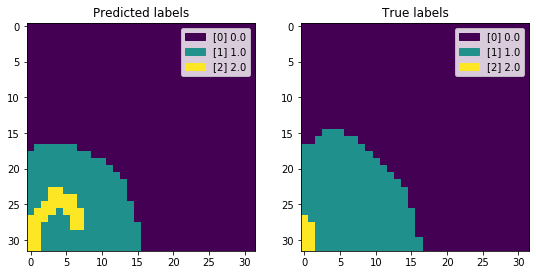

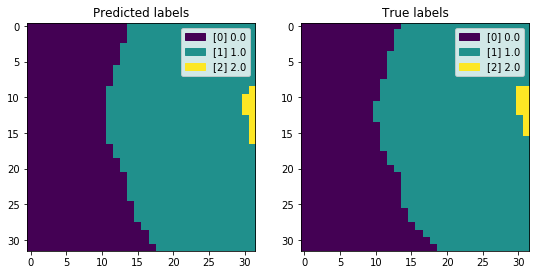

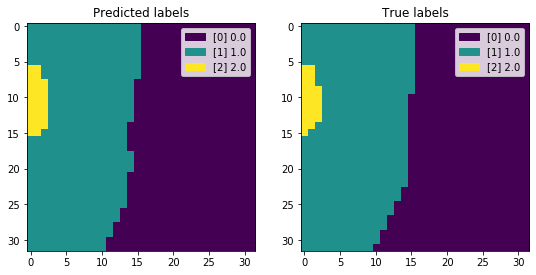

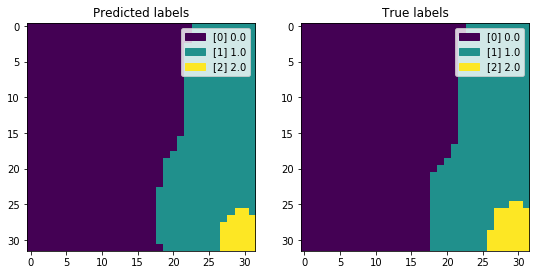

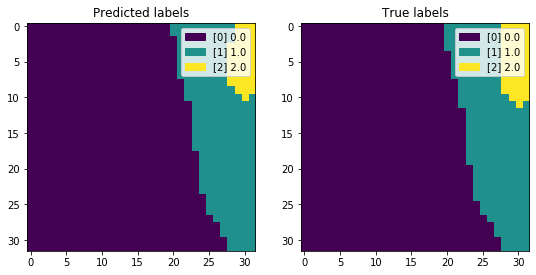

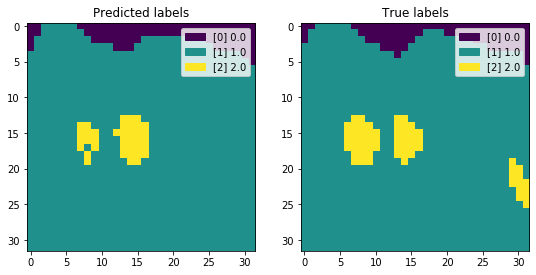

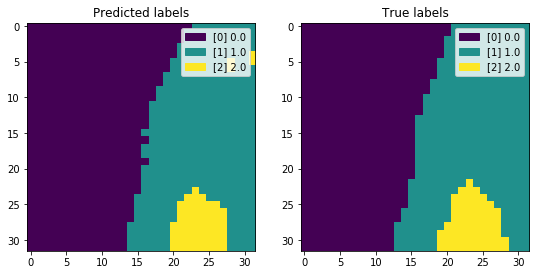

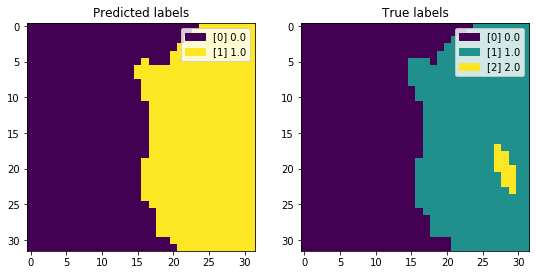

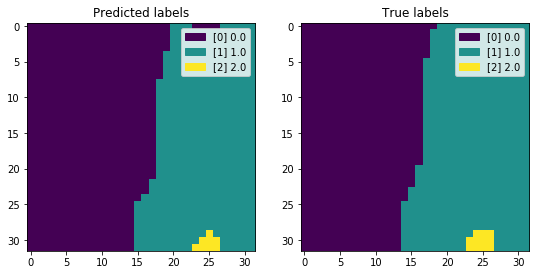

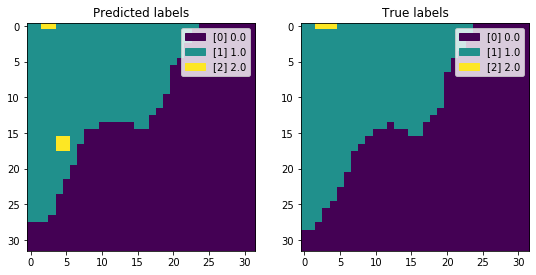

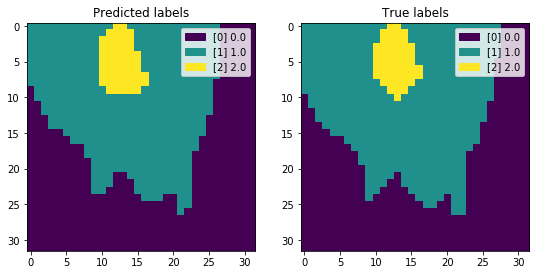

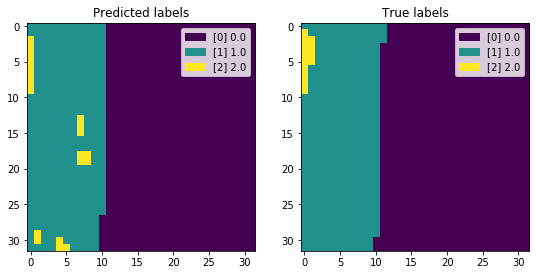

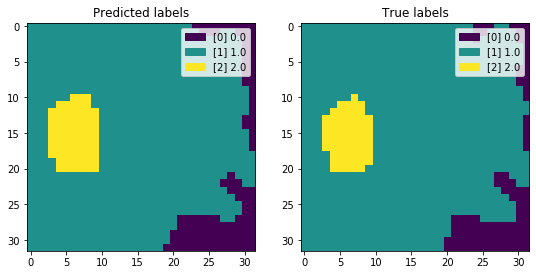

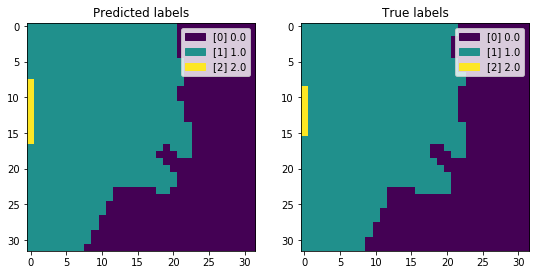

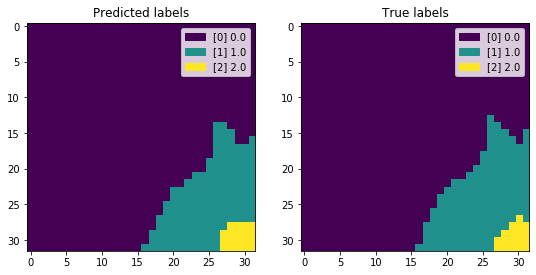

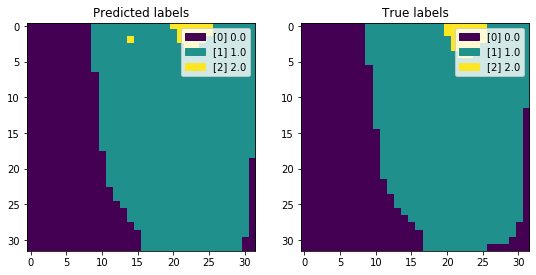

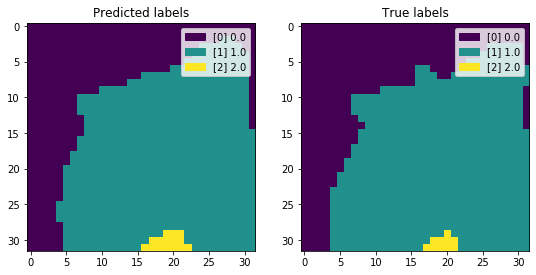

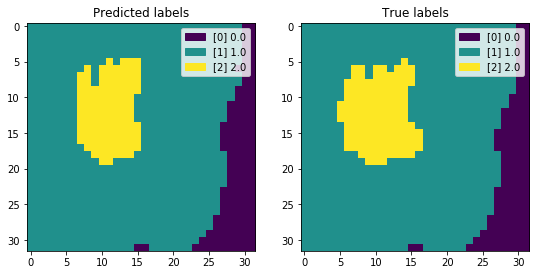

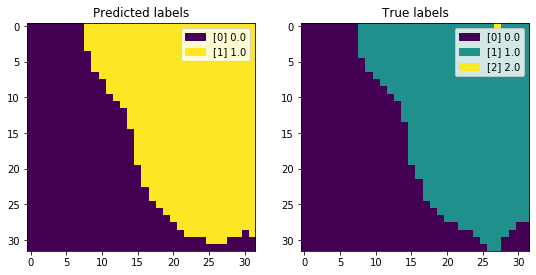

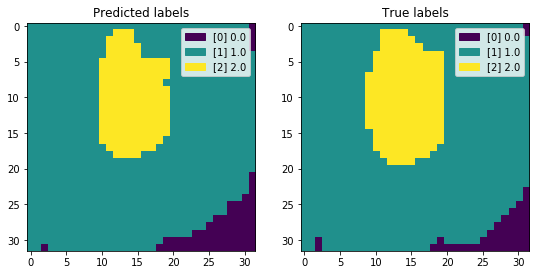

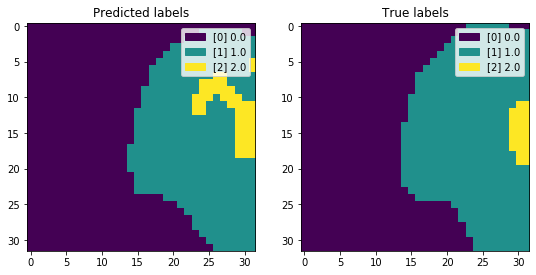

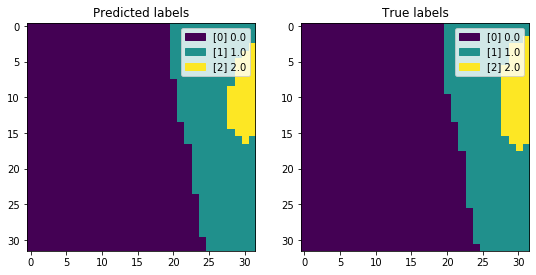

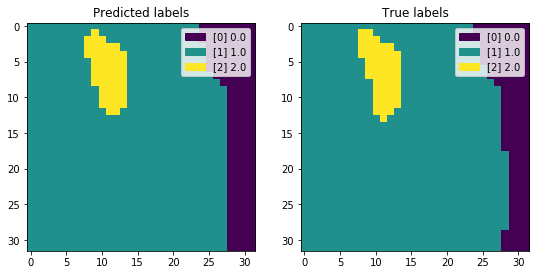

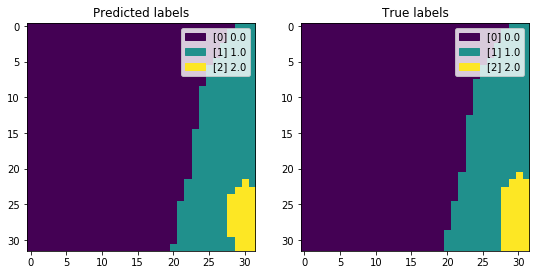

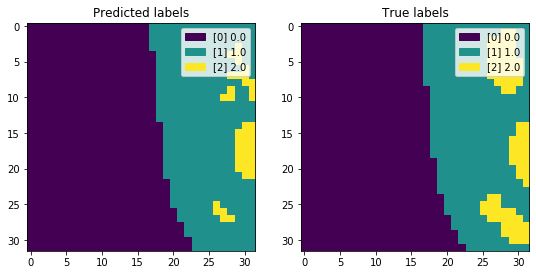

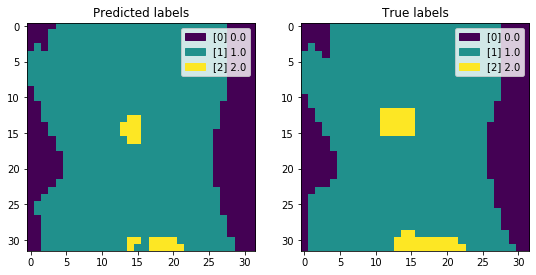

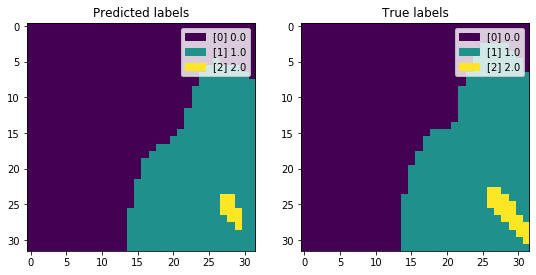

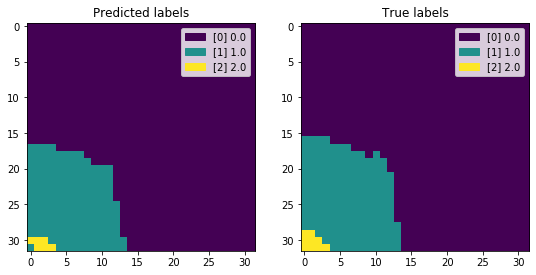

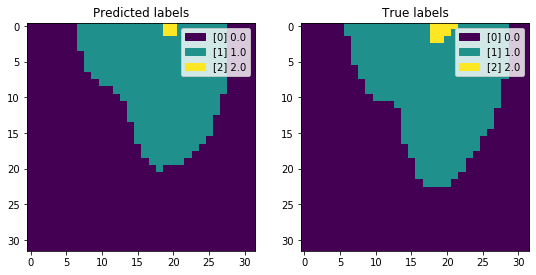

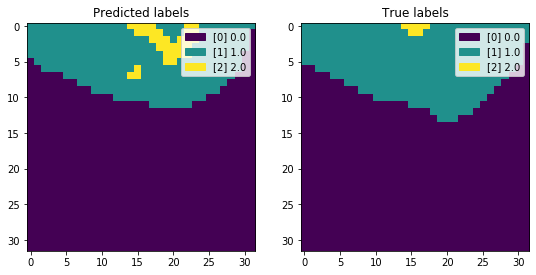

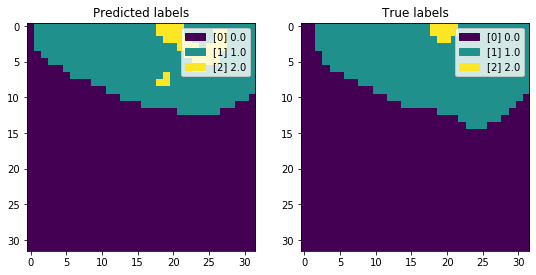

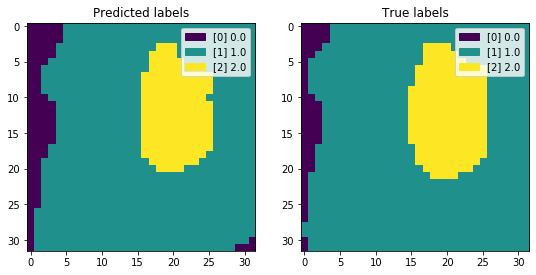

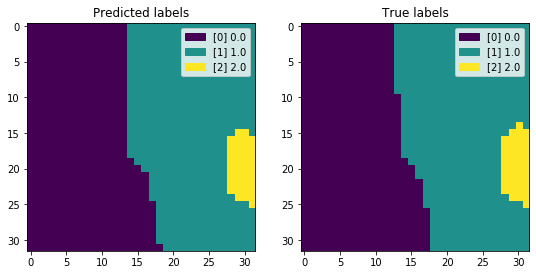

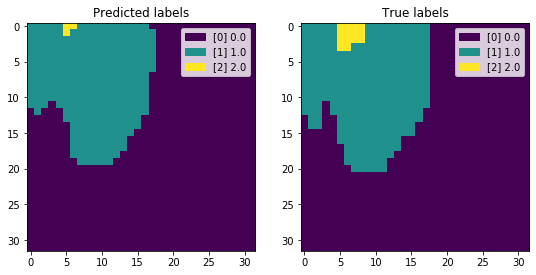

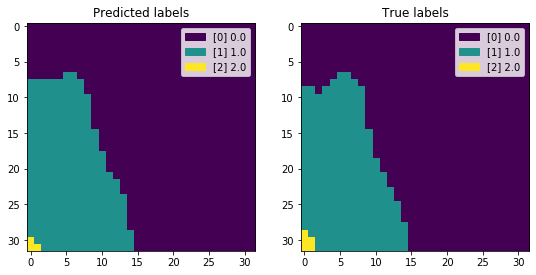

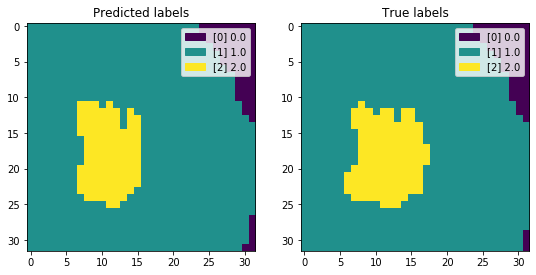

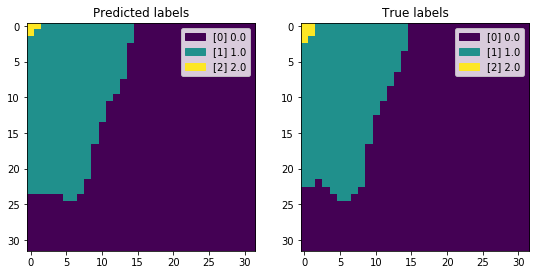

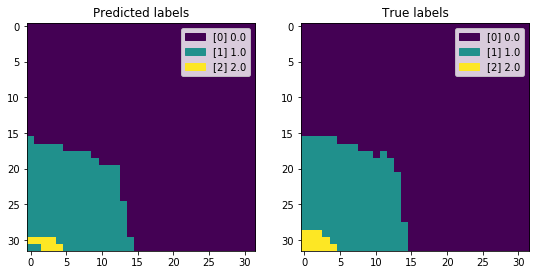

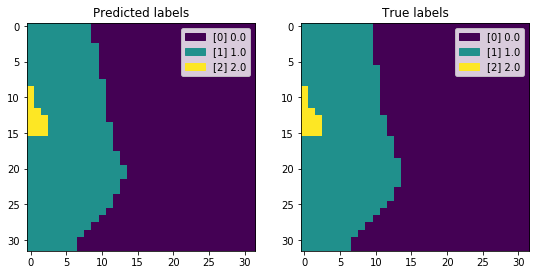

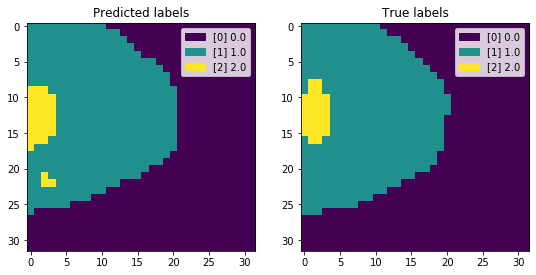

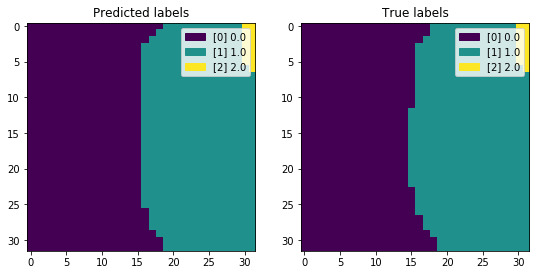

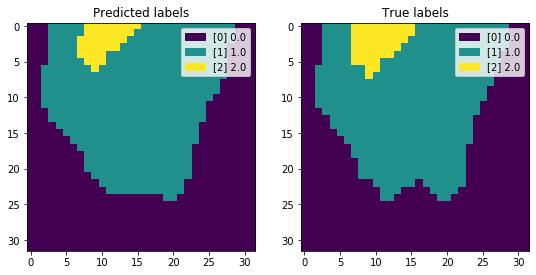

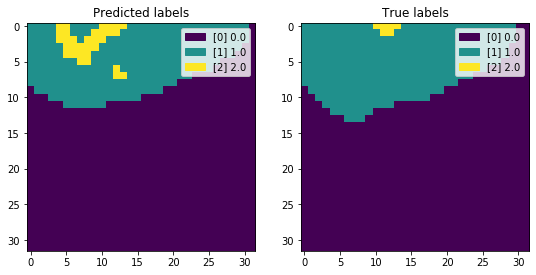

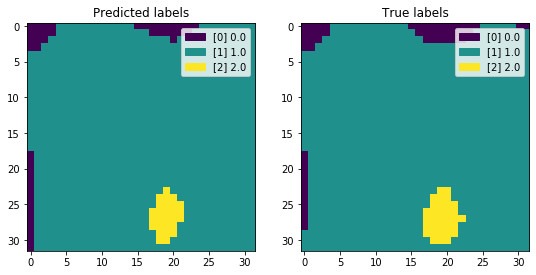

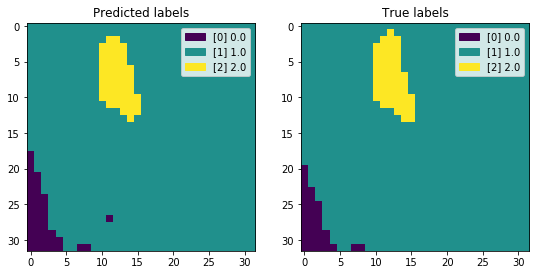

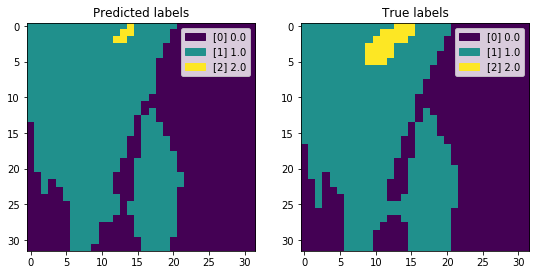

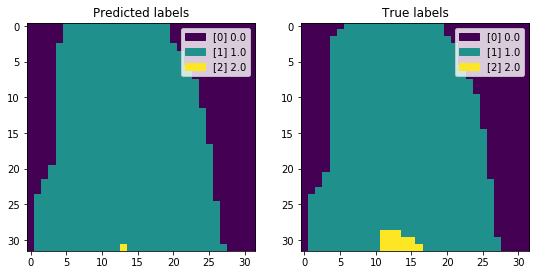

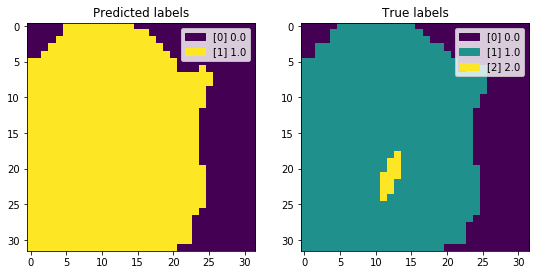

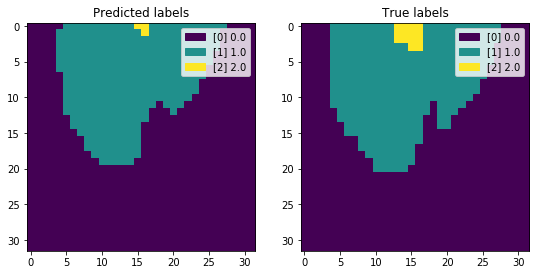

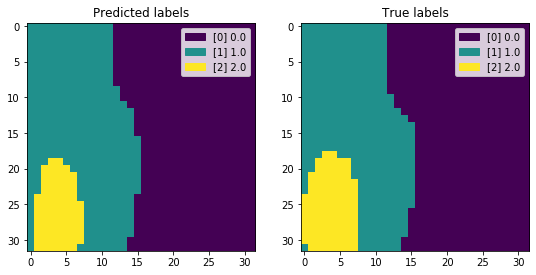

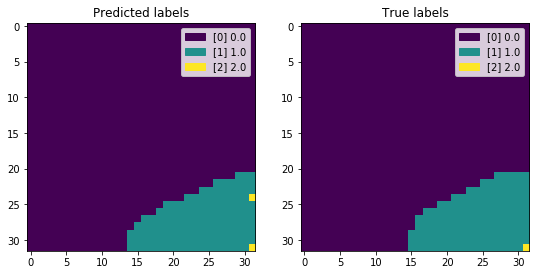

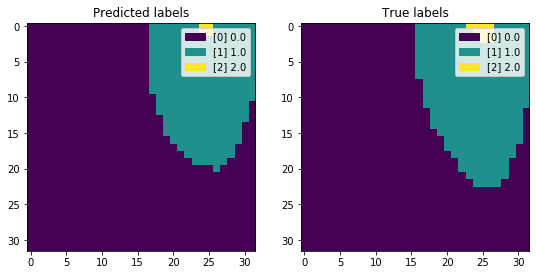

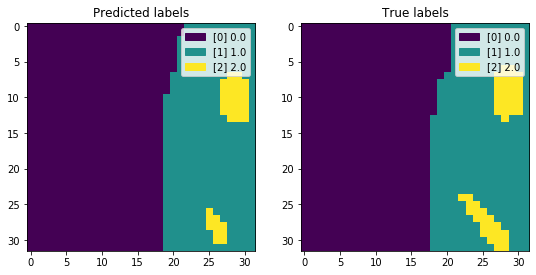

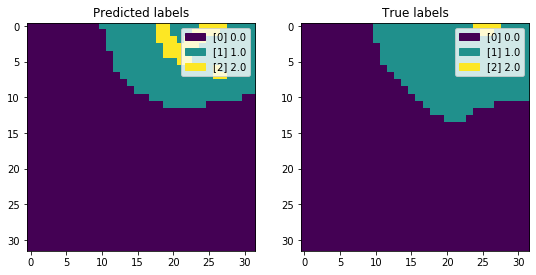

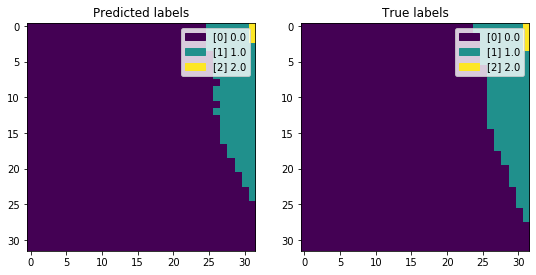

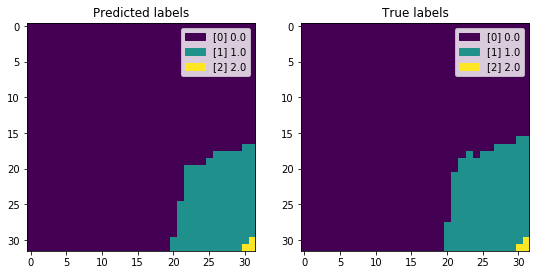

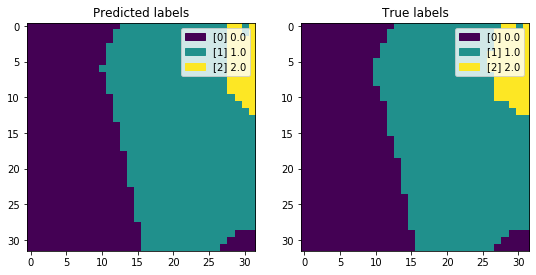

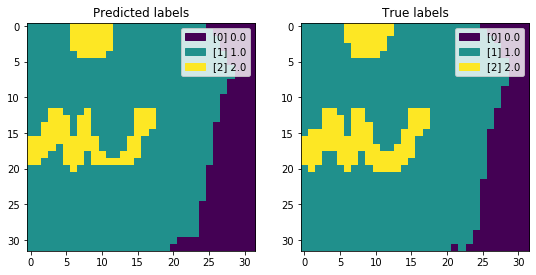

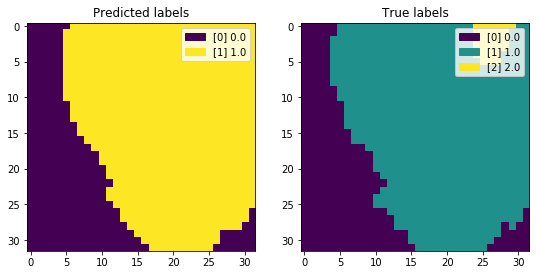

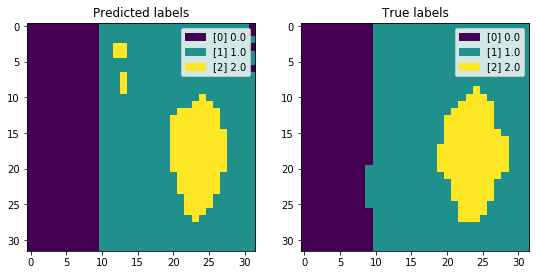

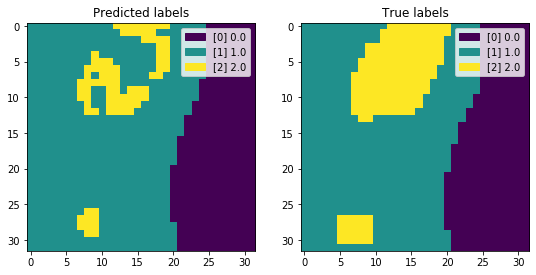

In [14]:
mypackage.plot_labeled_images(Y_hat, Y_test)

In [ ]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.8855
Epoch 00001: val_loss improved from inf to 0.13321, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 12s 11ms/sample - loss: 0.5048 - accuracy: 0.8861 - val_loss: 0.1332 - val_accuracy: 0.9745
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9567
Epoch 00002: val_loss improved from 0.13321 to 0.08592, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 10s 9ms/sample - loss: 0.1869 - accuracy: 0.9568 - val_loss: 0.0859 - val_accuracy: 0.9777
Epoch 3/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9627
Epoch 00003: val_loss improved from 0.08592 to 0.07271, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 10s 9ms/sample - loss: 0.1355 - accu

1125/1134 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9813
Epoch 00027: val_loss improved from 0.03825 to 0.03709, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 10s 9ms/sample - loss: 0.0543 - accuracy: 0.9813 - val_loss: 0.0371 - val_accuracy: 0.9865
Epoch 28/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9819
Epoch 00028: val_loss did not improve from 0.03709
1134/1134 [==============================] - 10s 9ms/sample - loss: 0.0521 - accuracy: 0.9819 - val_loss: 0.0382 - val_accuracy: 0.9862
Epoch 29/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9824
Epoch 00029: val_loss did not improve from 0.03709
1134/1134 [==============================] - 10s 9ms/sample - loss: 0.0509 - accuracy: 0.9824 - val_loss: 0.0373 - val_accuracy: 0.9858
Epoch 30/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9821
Epoch 00

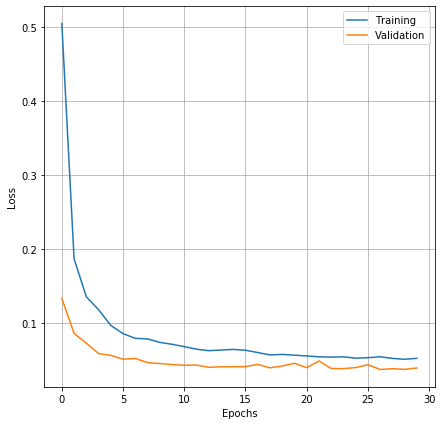

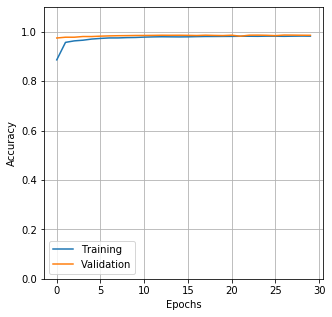

Predicting for train data
Elapsed time: 2.8170 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1080250
           1       0.96      0.95      0.96    196825
           2       0.82      0.66      0.73     13165

    accuracy                           0.99   1290240
   macro avg       0.92      0.87      0.89   1290240
weighted avg       0.99      0.99      0.99   1290240



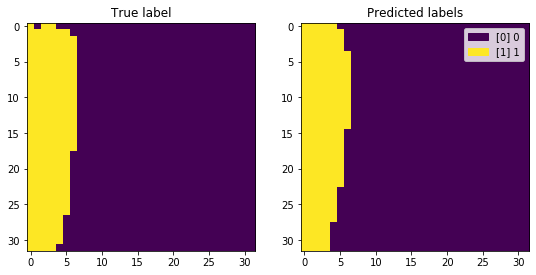

Predicting for test data
Elapsed time: 1.1955 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    455078
           1       0.97      0.94      0.96    122417
           2       0.76      0.67      0.71      6185

    accuracy                           0.98    583680
   macro avg       0.91      0.87      0.89    583680
weighted avg       0.98      0.98      0.98    583680



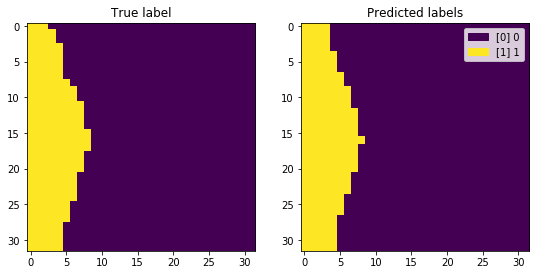

Elapsed time: 2.0333 seconds
Fasle positive blobs 3


In [15]:
spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")


### Test 2D UNet on the same data

Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.9312
Epoch 00001: val_loss improved from inf to 0.06973, saving model to latest_unet.hdf5
1134/1134 [==============================] - 5s 5ms/sample - loss: 0.3096 - accuracy: 0.9314 - val_loss: 0.0697 - val_accuracy: 0.9802
Epoch 2/30
1115/1134 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9744
Epoch 00002: val_loss improved from 0.06973 to 0.04870, saving model to latest_unet.hdf5
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.0990 - accuracy: 0.9744 - val_loss: 0.0487 - val_accuracy: 0.9833
Epoch 3/30
1115/1134 [============================>.] - ETA: 0s - loss: 0.0724 - accuracy: 0.9787
Epoch 00003: val_loss improved from 0.04870 to 0.04008, saving model to latest_unet.hdf5
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.0723 - accuracy: 0.9787 - val_loss: 0.0401

Epoch 28/30
1115/1134 [============================>.] - ETA: 0s - loss: 0.0394 - accuracy: 0.9864
Epoch 00028: val_loss did not improve from 0.03054
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.0395 - accuracy: 0.9864 - val_loss: 0.0317 - val_accuracy: 0.9880
Epoch 29/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9867
Epoch 00029: val_loss did not improve from 0.03054
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.0313 - val_accuracy: 0.9884
Epoch 30/30
1115/1134 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9867
Epoch 00030: val_loss did not improve from 0.03054
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.0389 - accuracy: 0.9866 - val_loss: 0.0310 - val_accuracy: 0.9886
Elapsed time: 111.5797 seconds


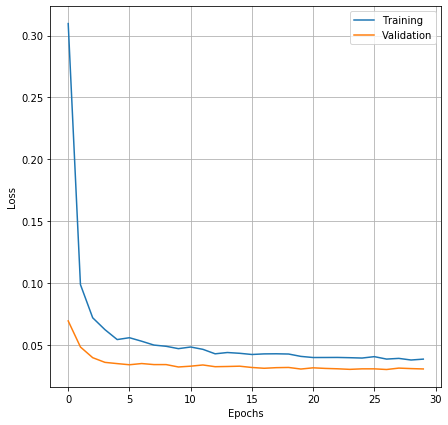

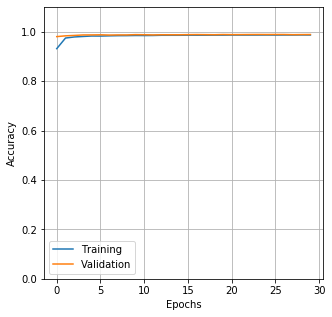

Predicting for train data
Elapsed time: 0.8484 seconds
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1080250
           1       0.95      0.98      0.96    196825
           2       0.90      0.71      0.79     13165

    accuracy                           0.99   1290240
   macro avg       0.95      0.89      0.92   1290240
weighted avg       0.99      0.99      0.99   1290240



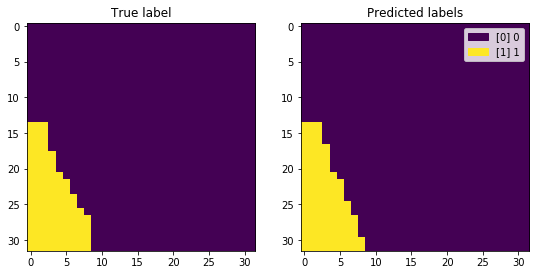

Predicting for test data
Elapsed time: 0.3202 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    455078
           1       0.97      0.97      0.97    122417
           2       0.86      0.73      0.79      6185

    accuracy                           0.99    583680
   macro avg       0.94      0.90      0.92    583680
weighted avg       0.99      0.99      0.99    583680



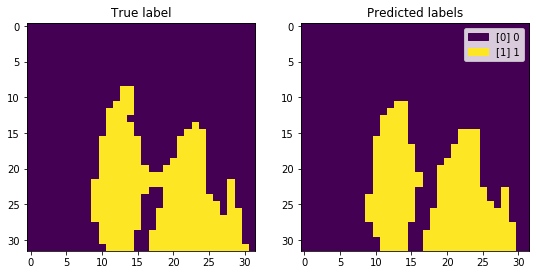

Elapsed time: 1.1707 seconds
Fasle positive blobs 17
Number of layers in the base model:  49


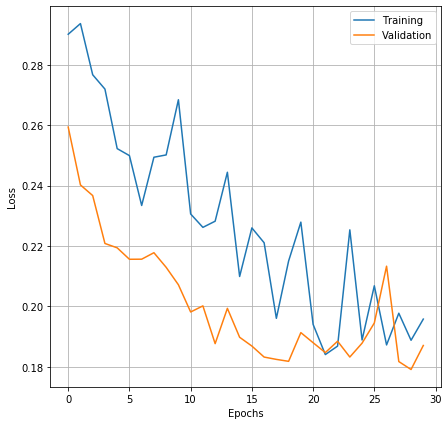

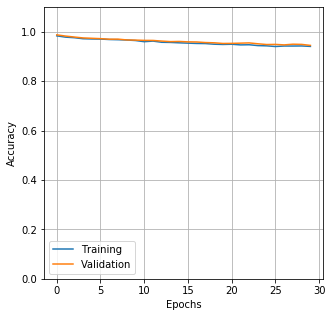

Predicting for test data after Dice_Loss focus on contaminants


IndexError: index 40 is out of bounds for axis 3 with size 30

In [16]:
# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [7, 40, 68, 138, -1]
def select_channels(X_train):
    if X_train.shape[-1] <= 30:
        return X_train
    else:
        return X_train[..., channels_used]
    
unet = mypackage.UNet(select_channels(X_train), Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=1)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(select_channels(X_train), Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(select_channels(X_test), Y_labels=Y_test);
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 0.5138 seconds
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    455078
           1       0.99      0.69      0.81    122417
           2       0.81      0.84      0.82      6185

    accuracy                           0.93    583680
   macro avg       0.91      0.84      0.86    583680
weighted avg       0.94      0.93      0.93    583680



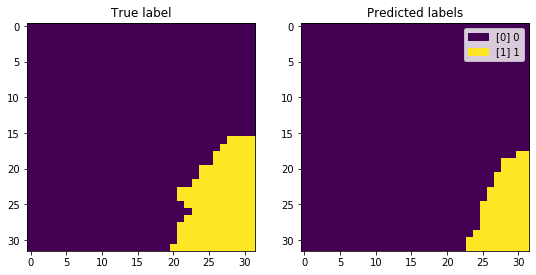

Fasle positive blobs 20


In [17]:
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



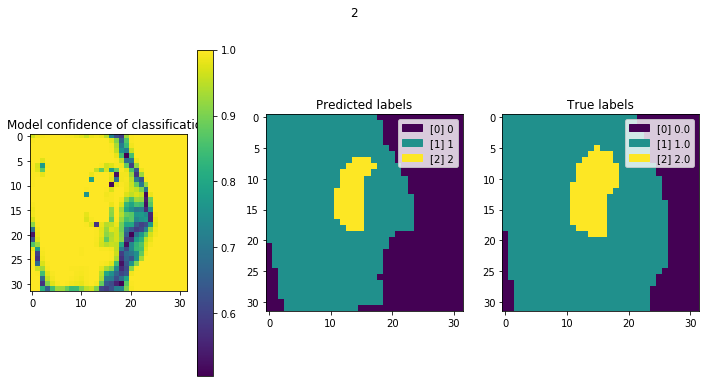

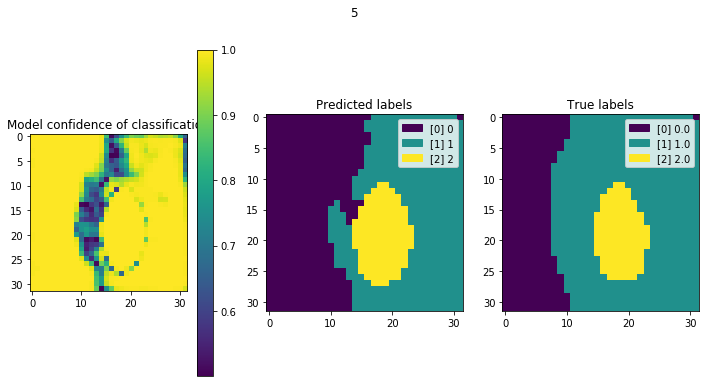

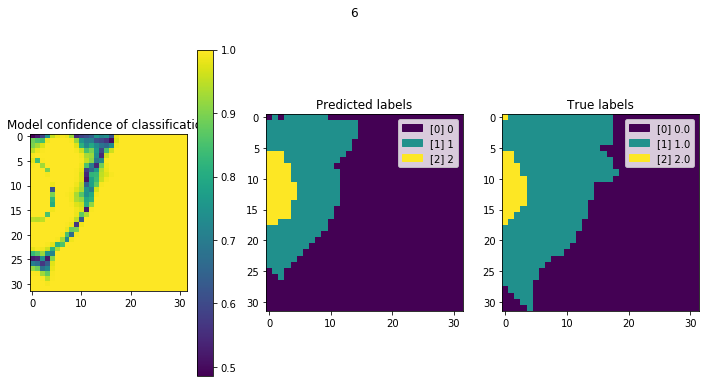

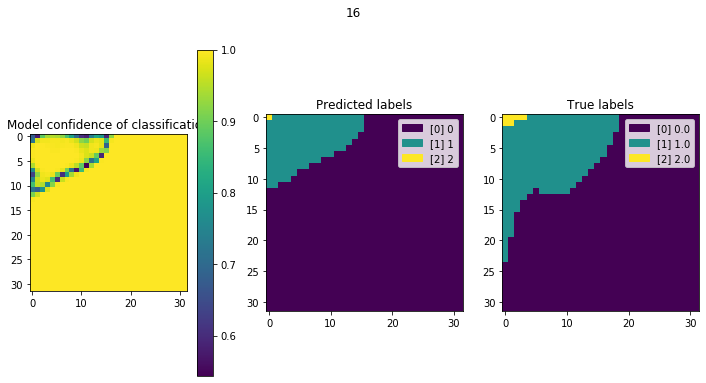

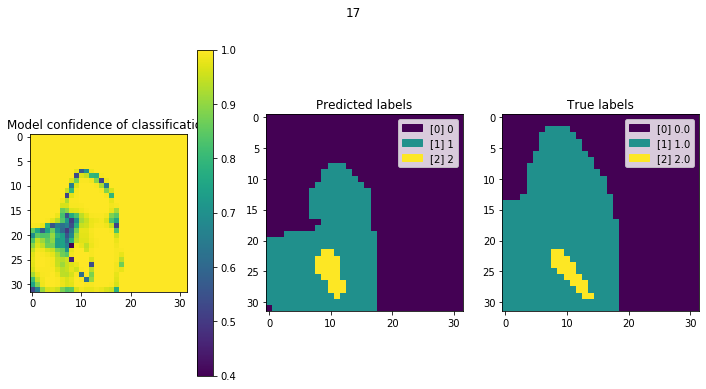

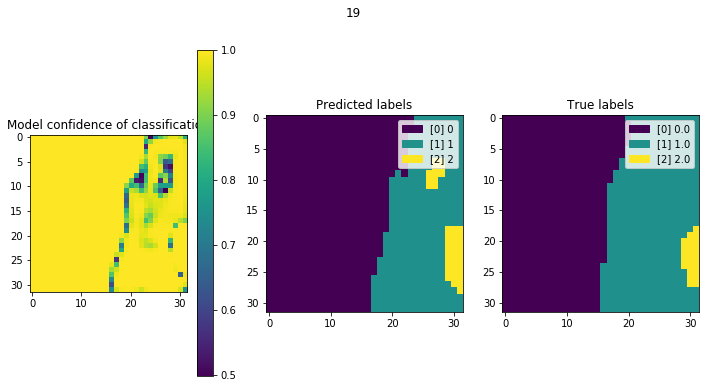

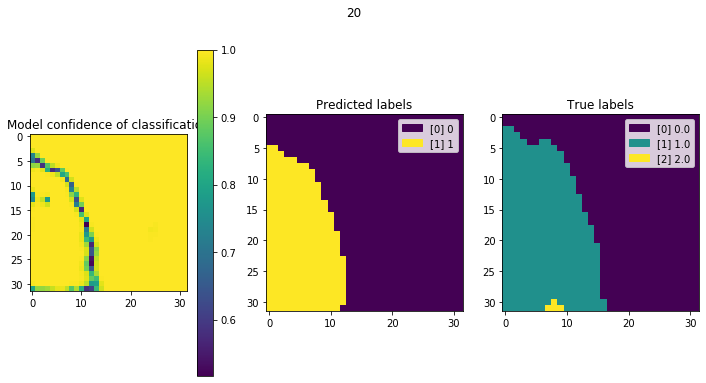

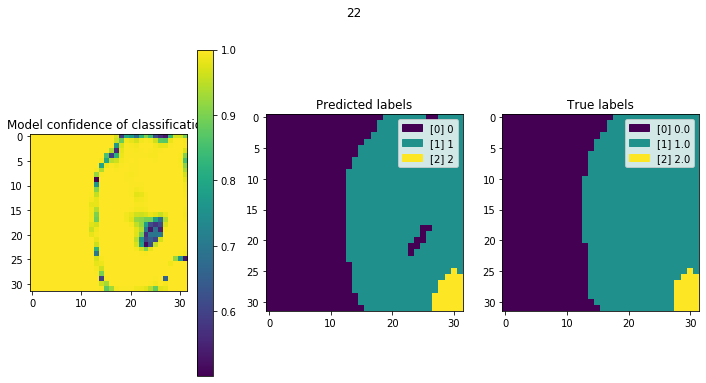

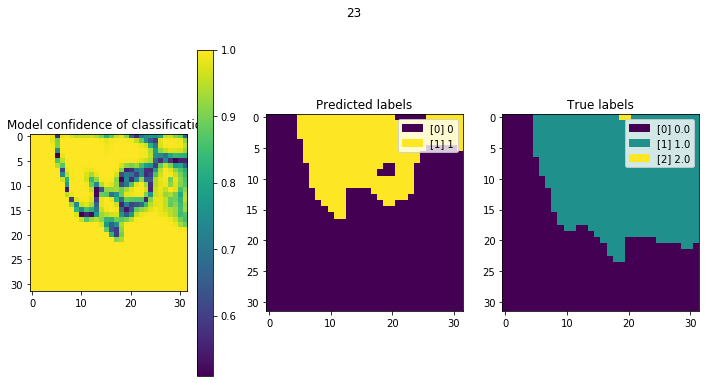

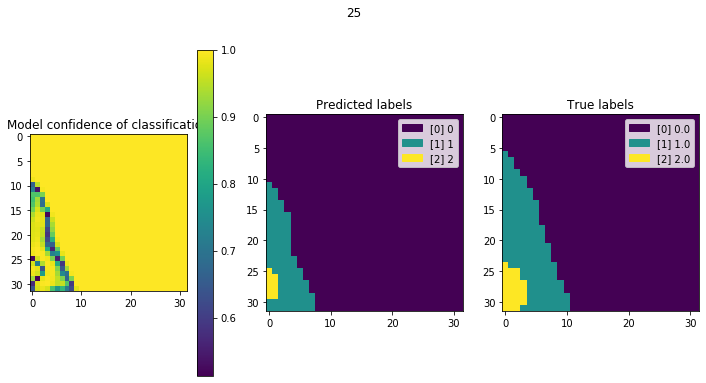

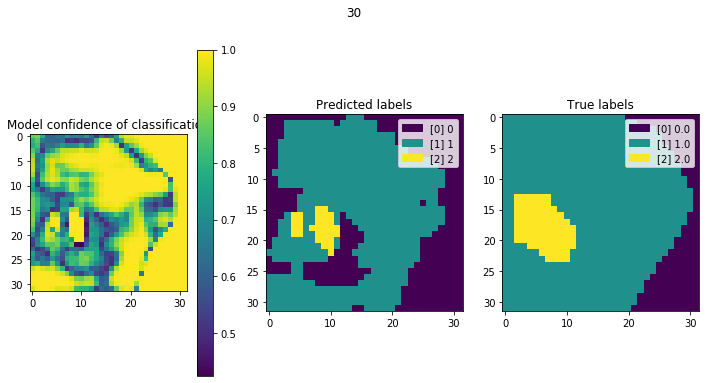

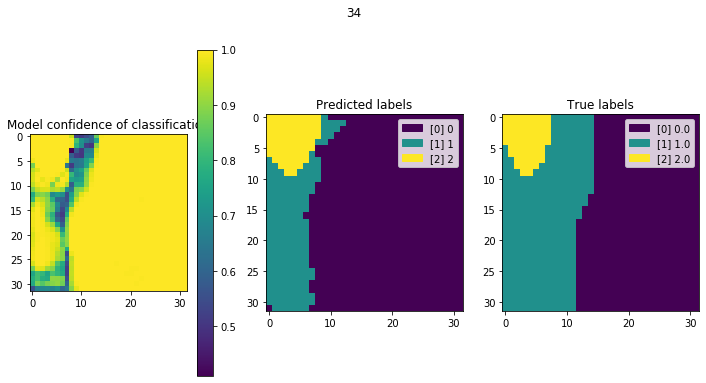

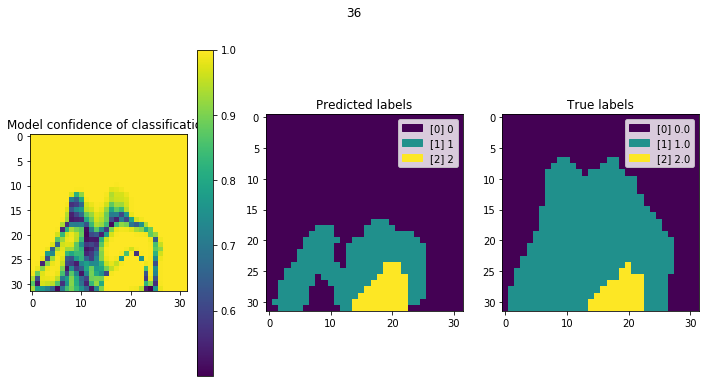

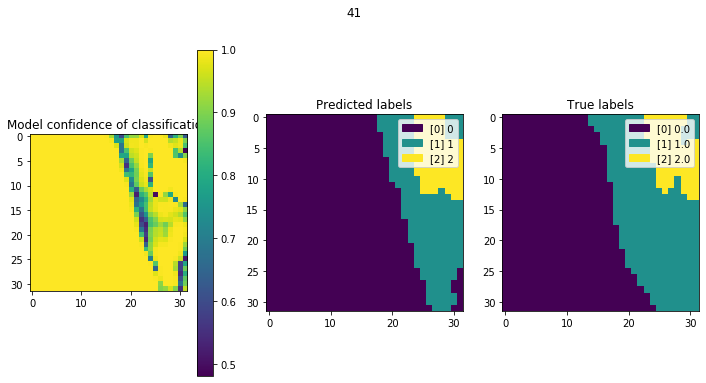

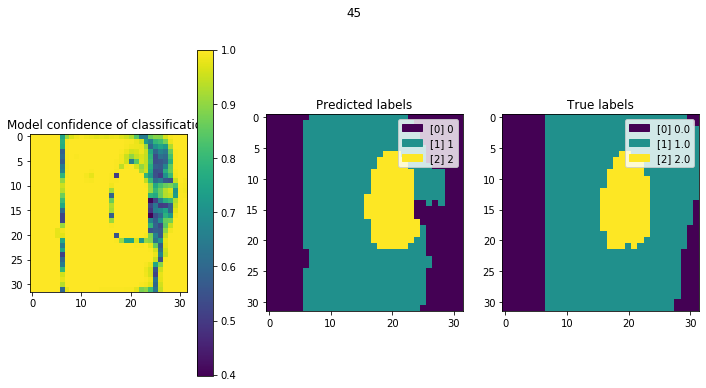

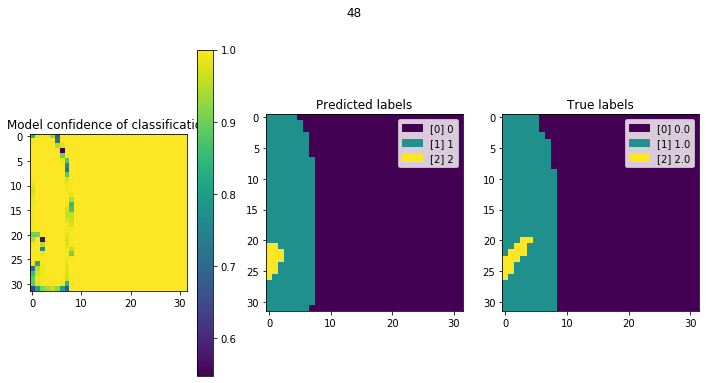

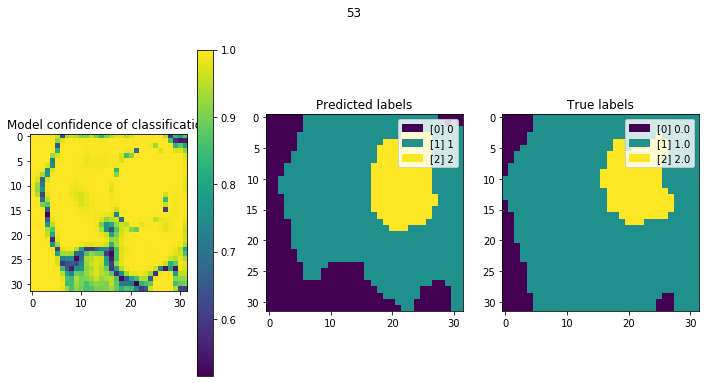

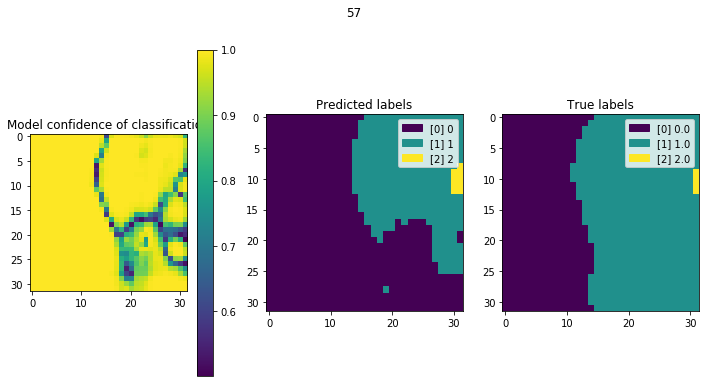

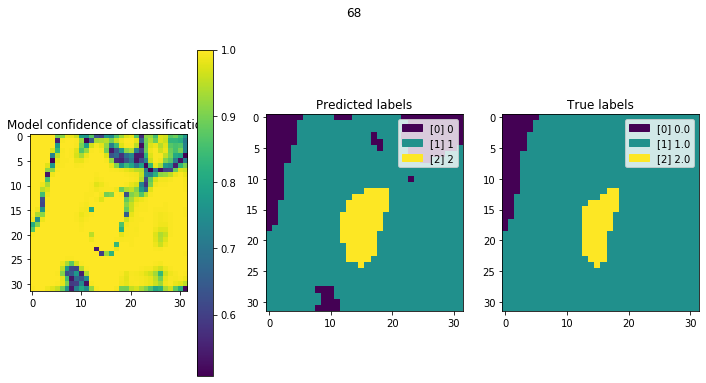

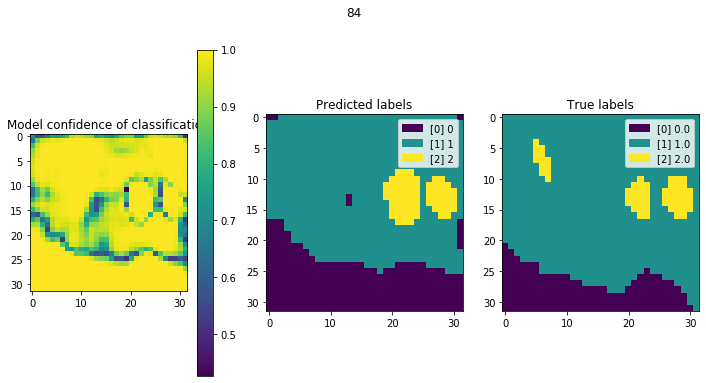

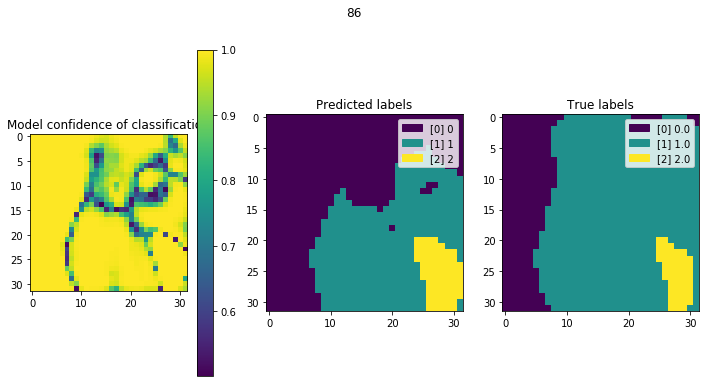

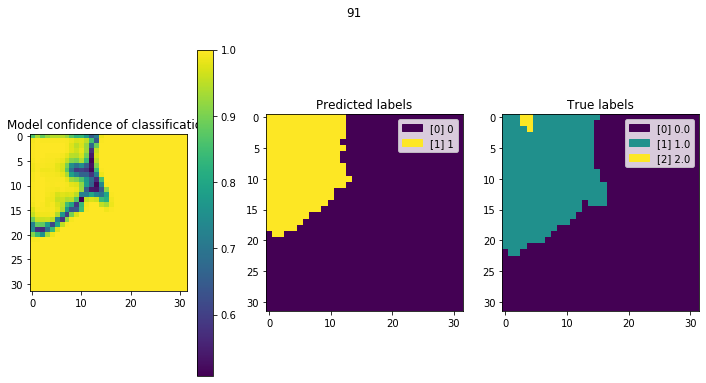

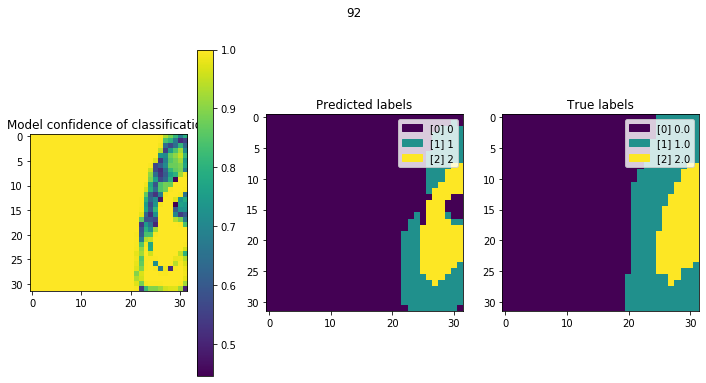

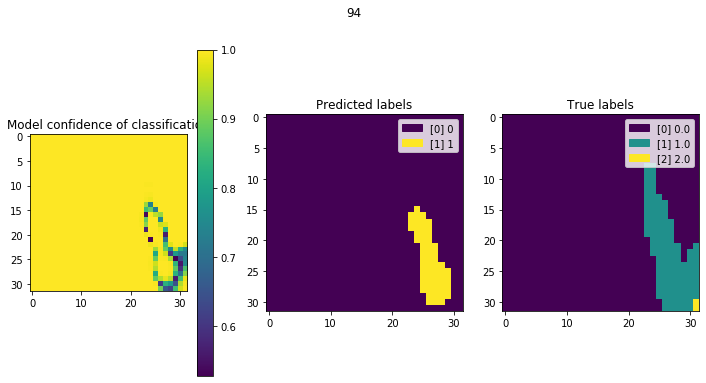

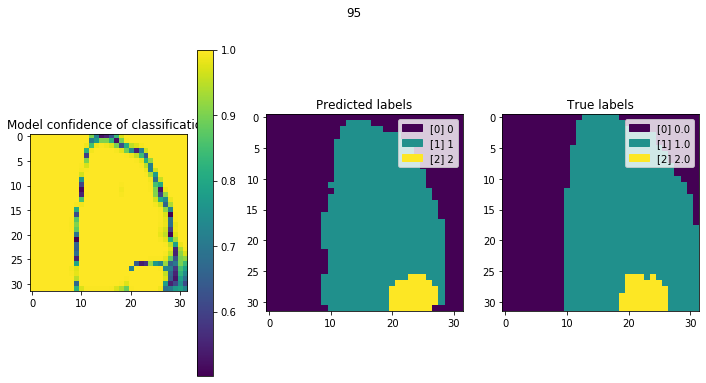

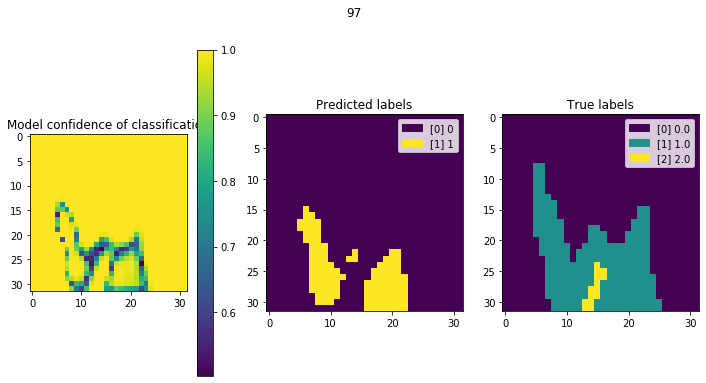

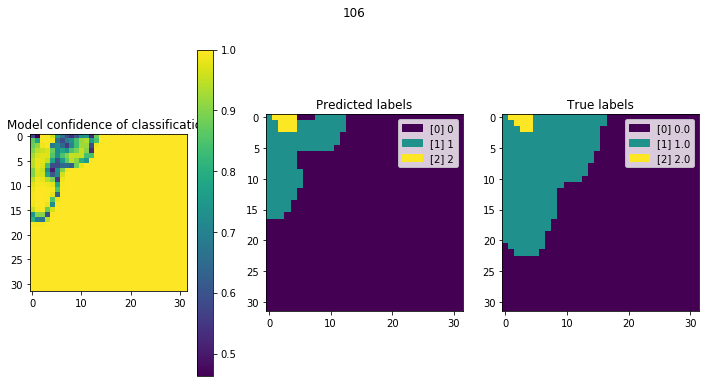

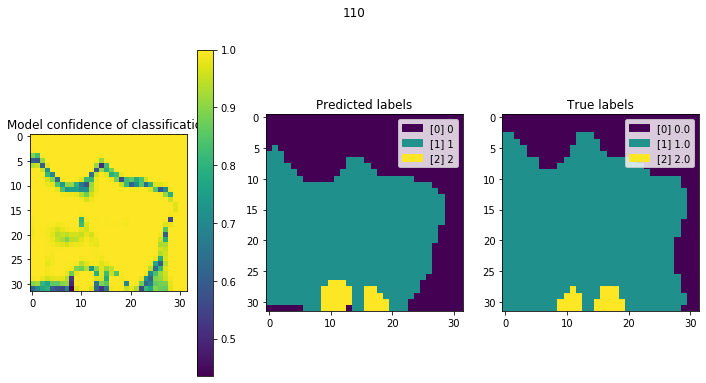

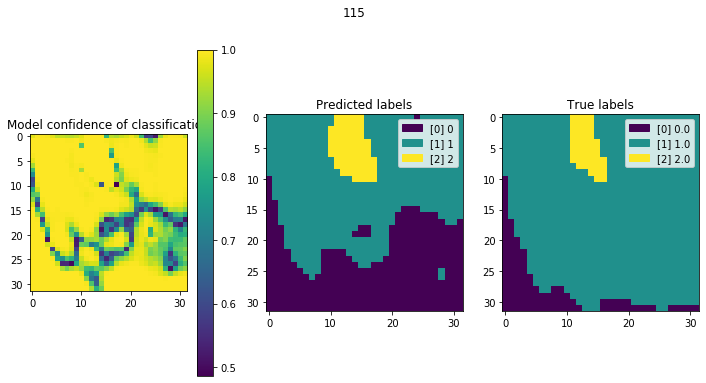

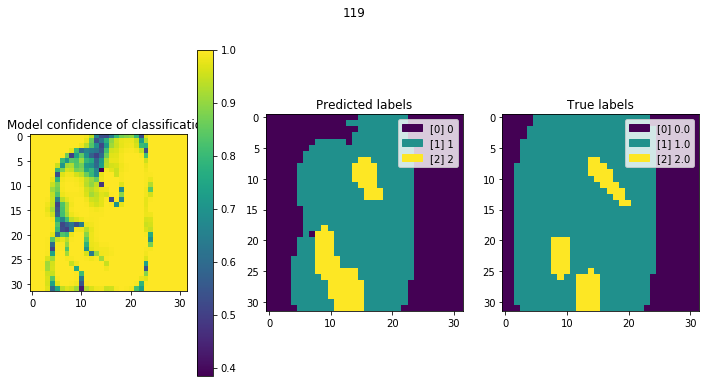

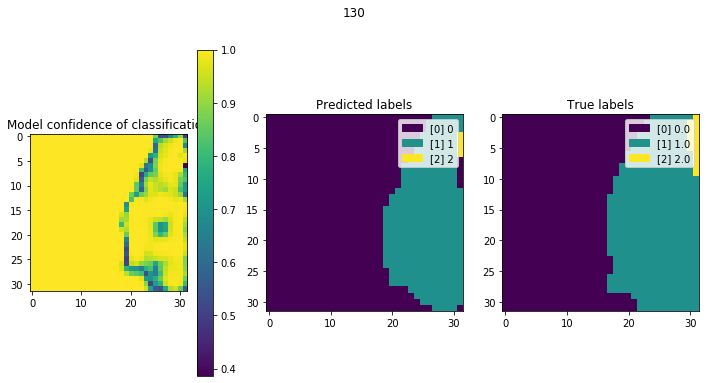

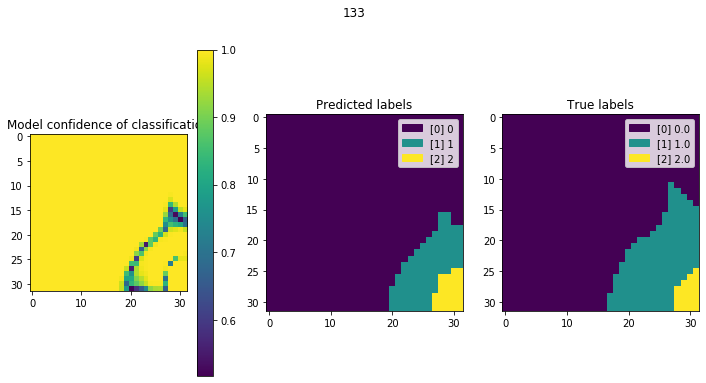

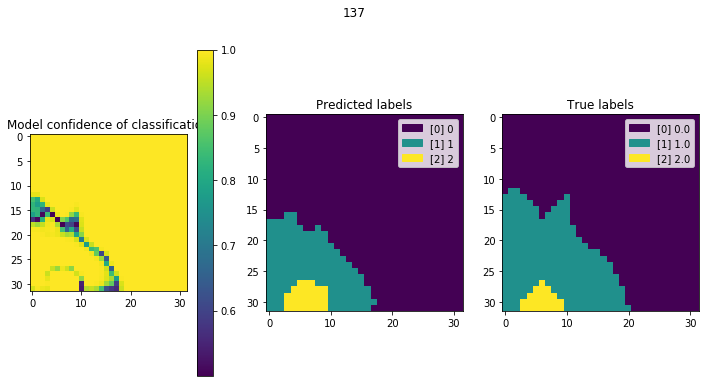

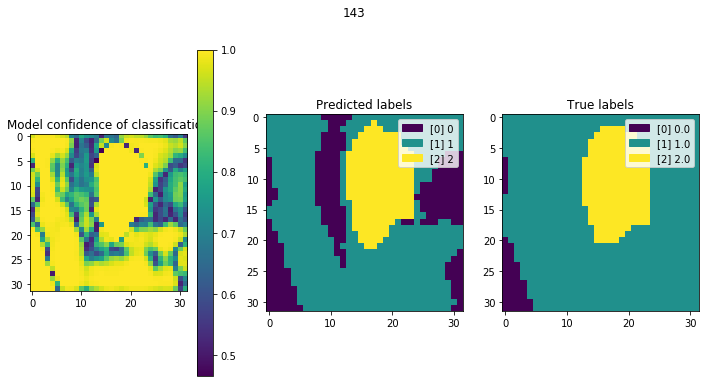

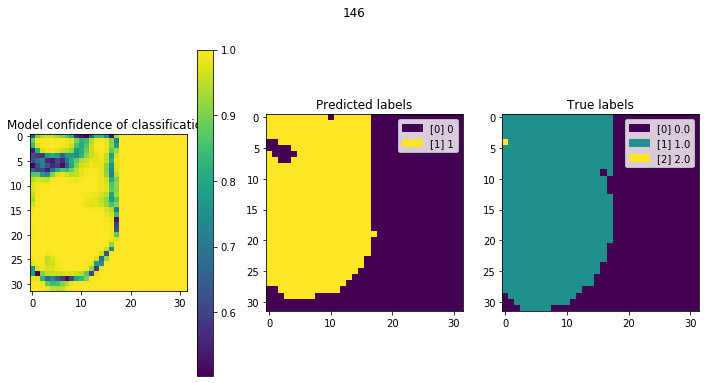

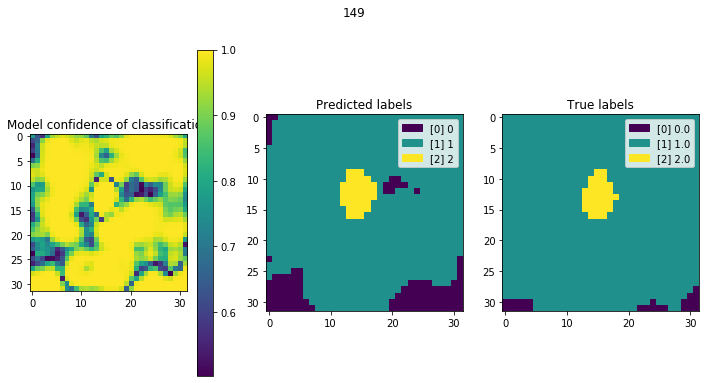

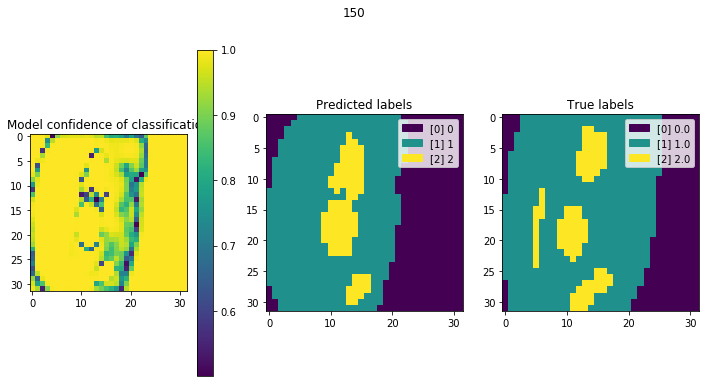

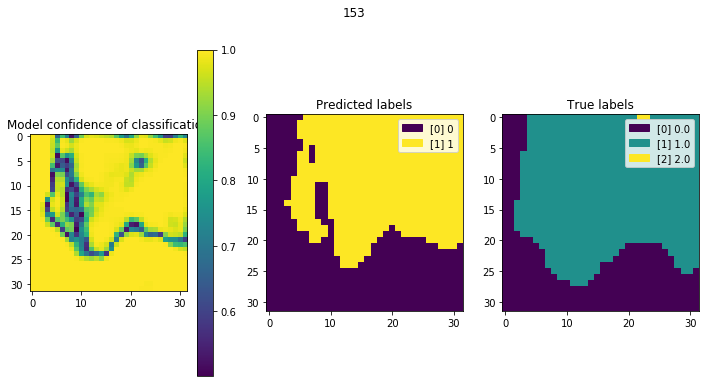

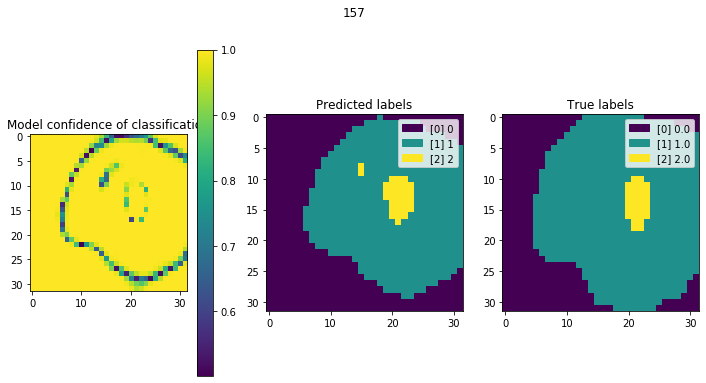

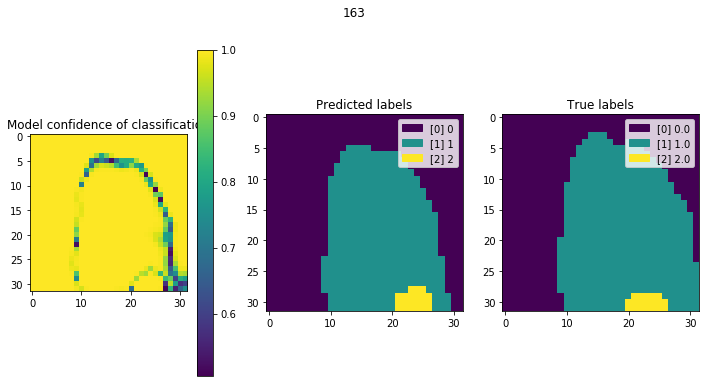

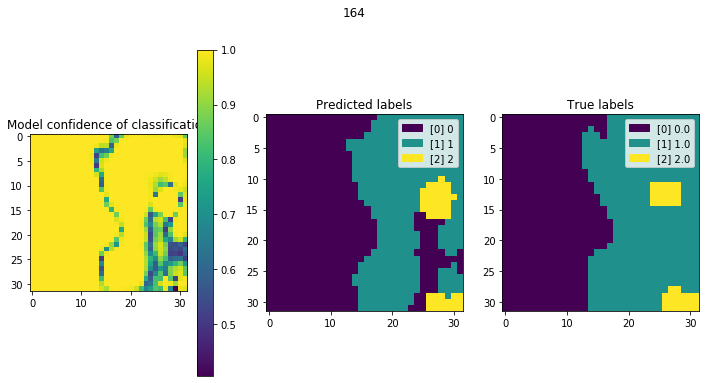

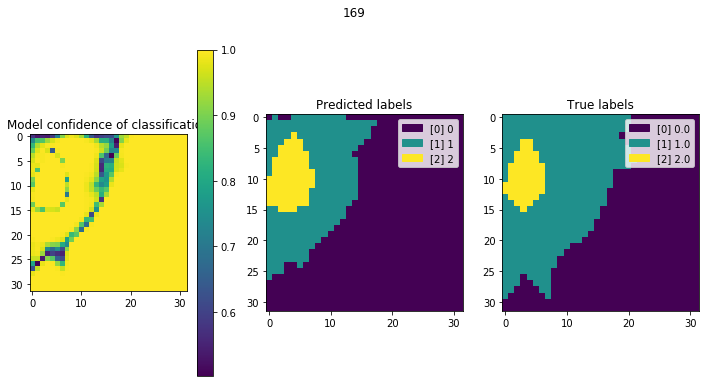

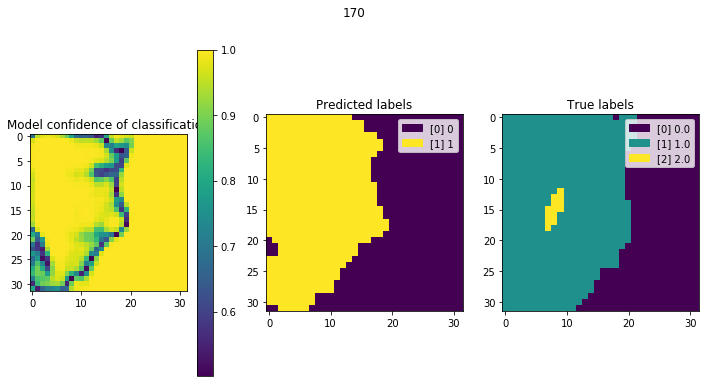

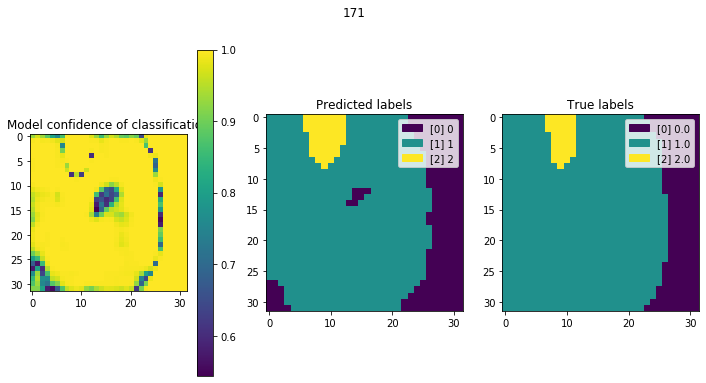

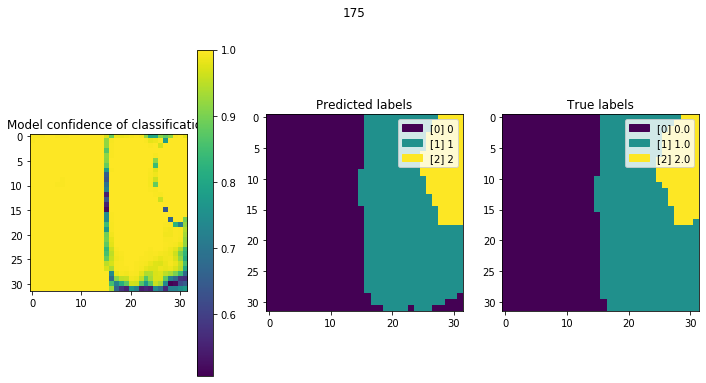

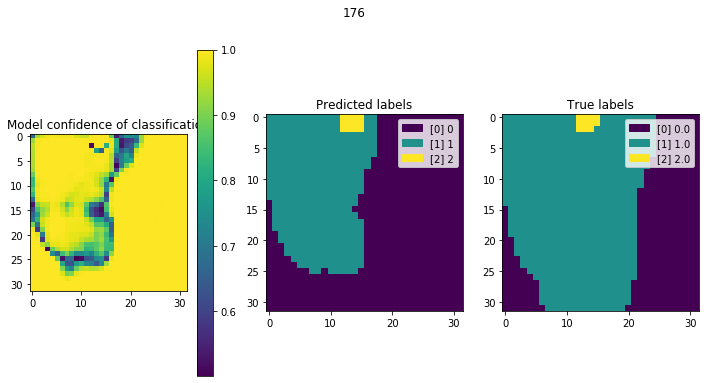

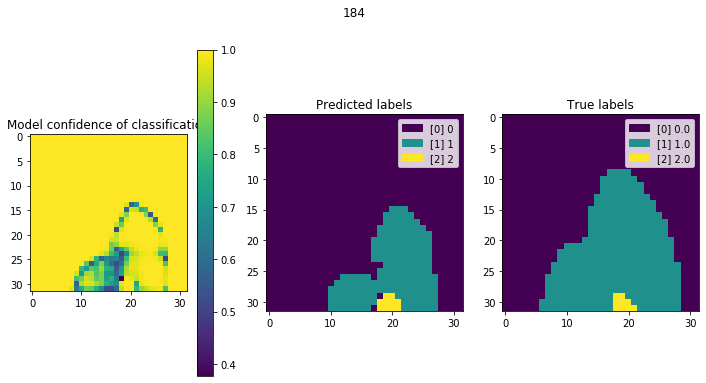

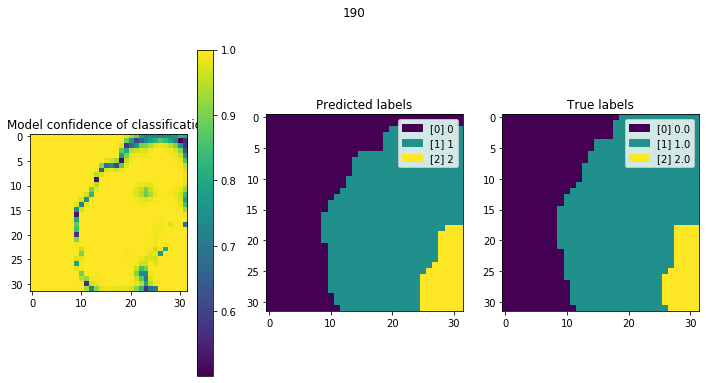

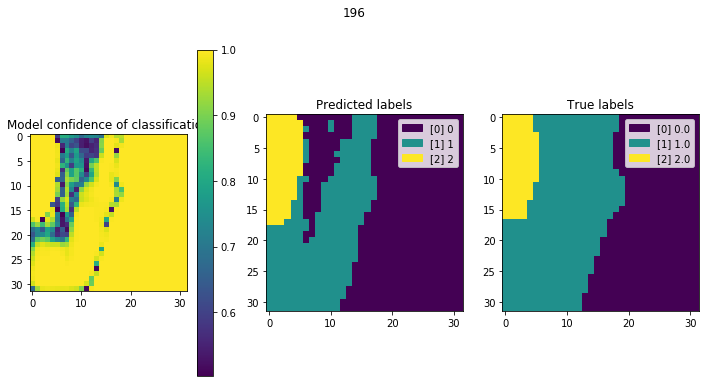

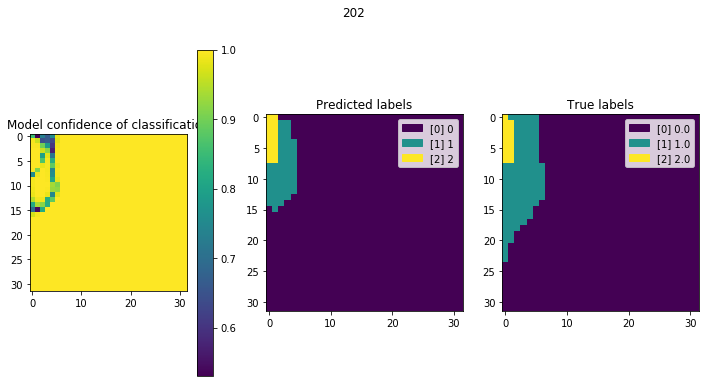

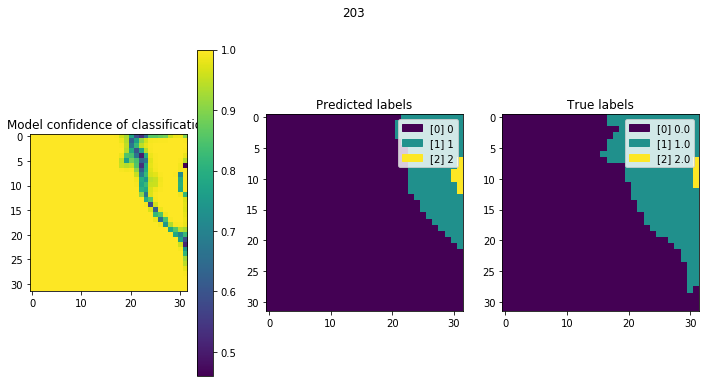

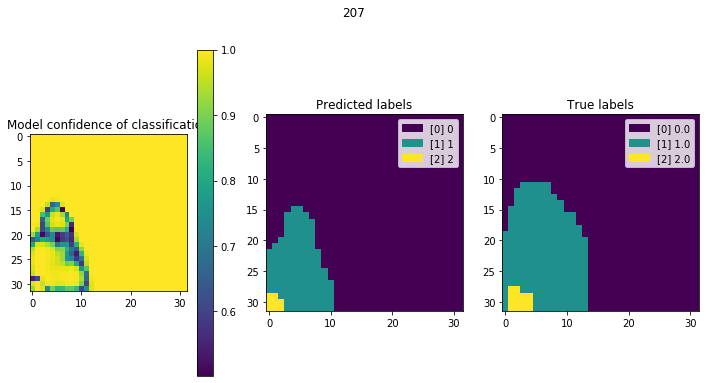

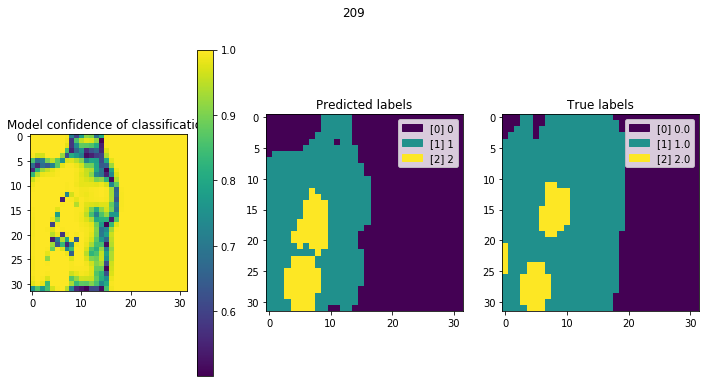

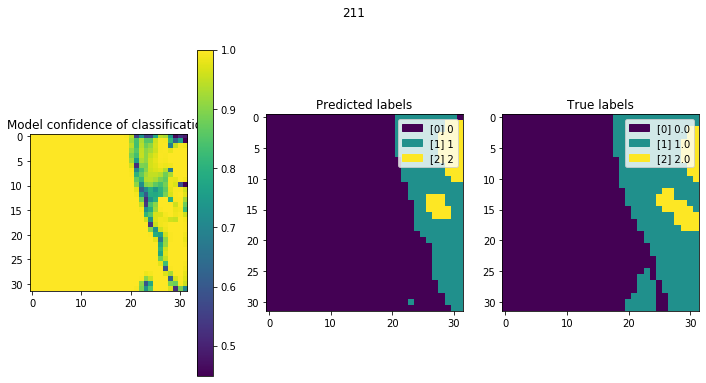

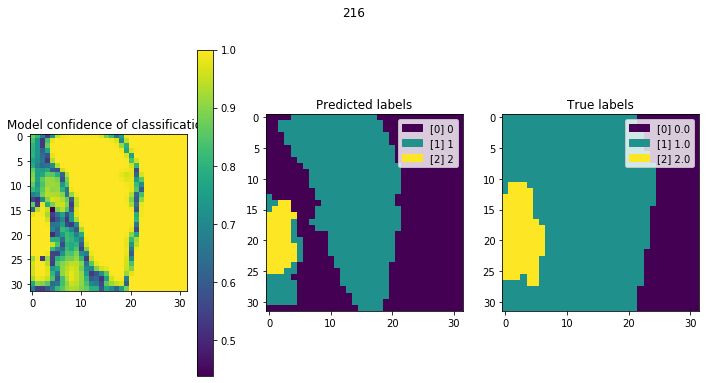

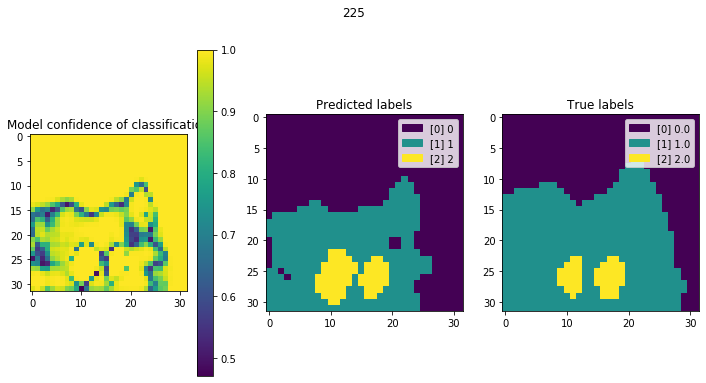

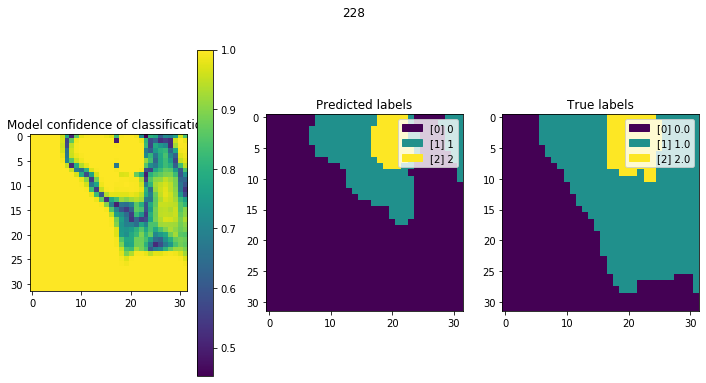

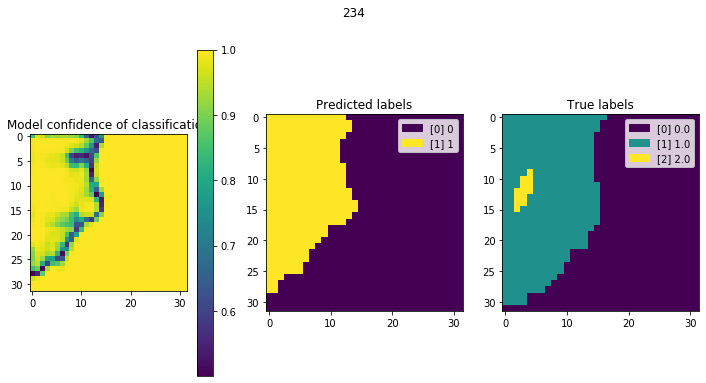

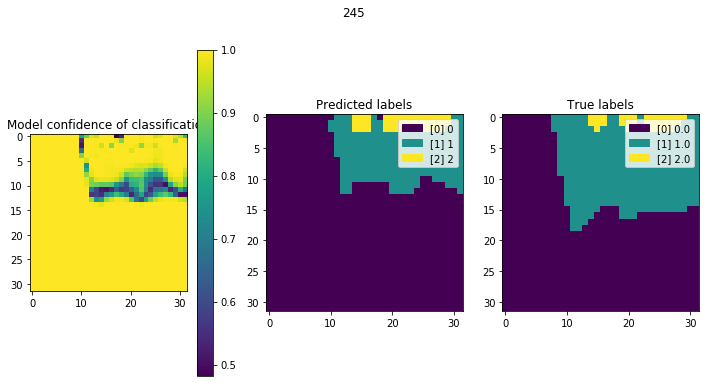

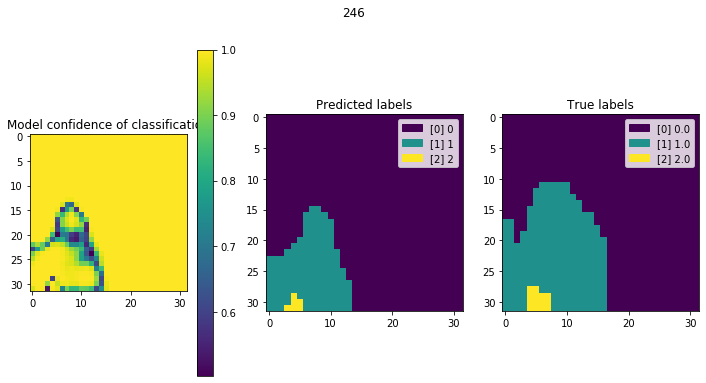

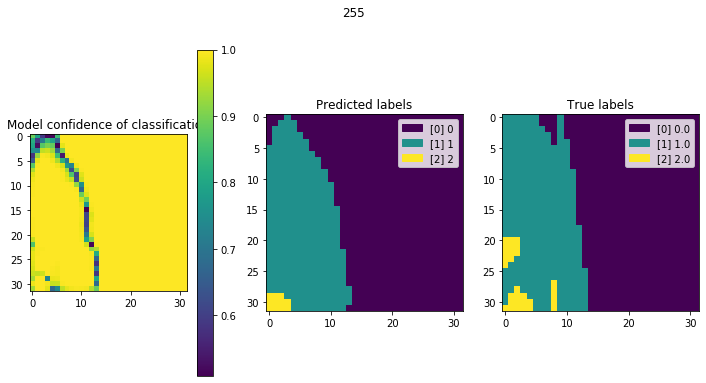

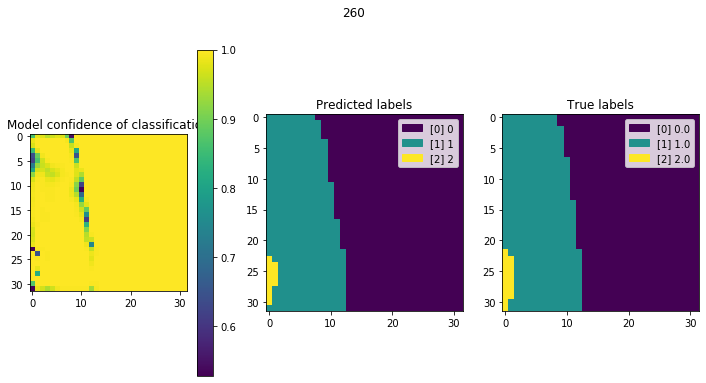

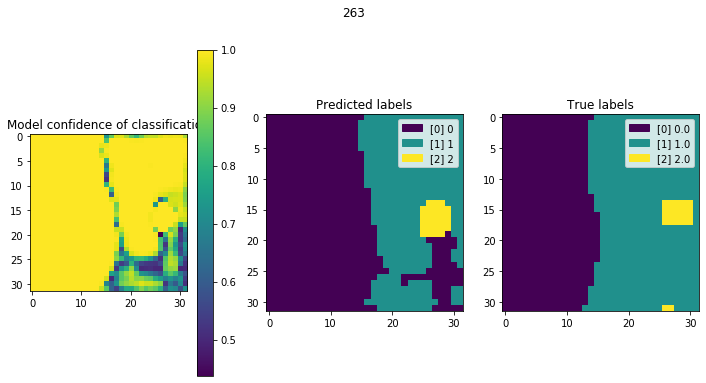

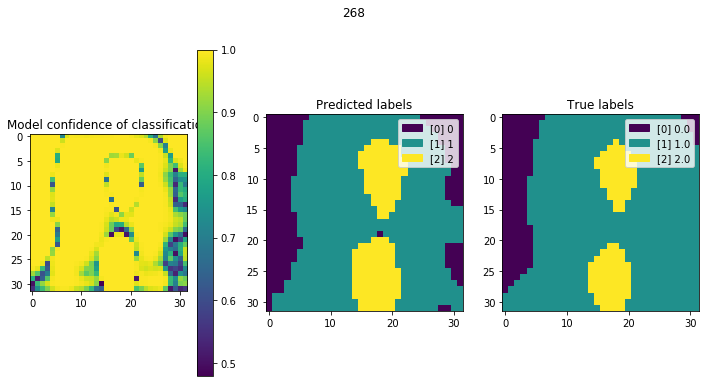

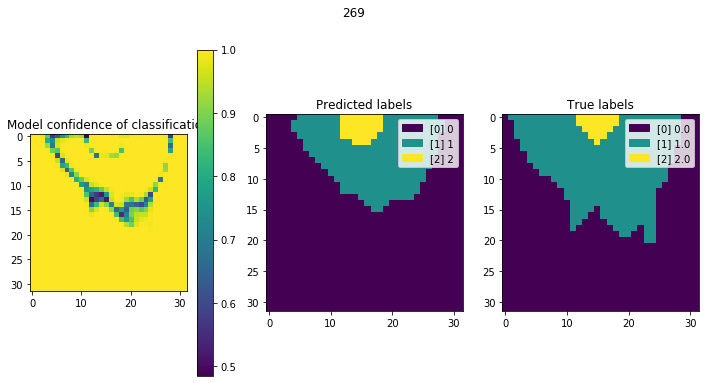

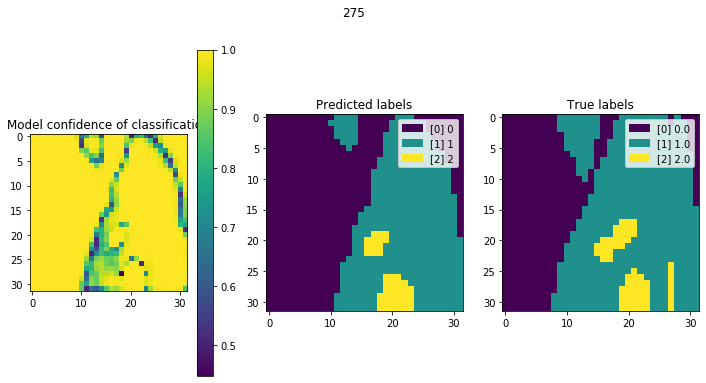

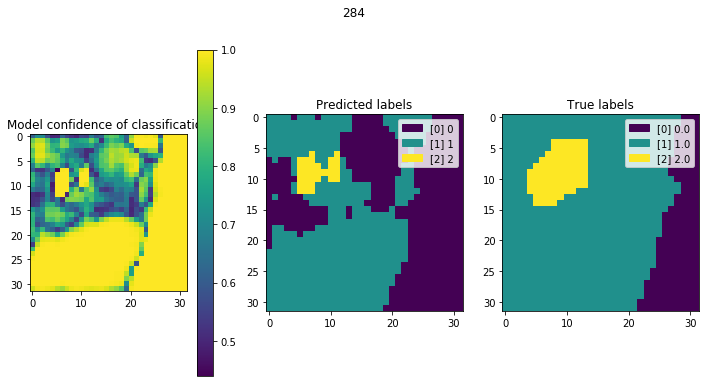

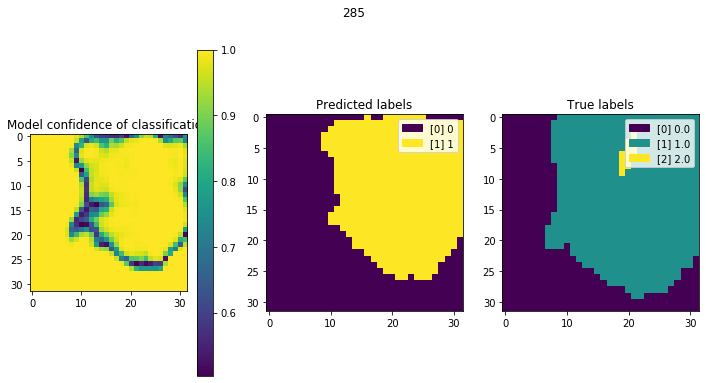

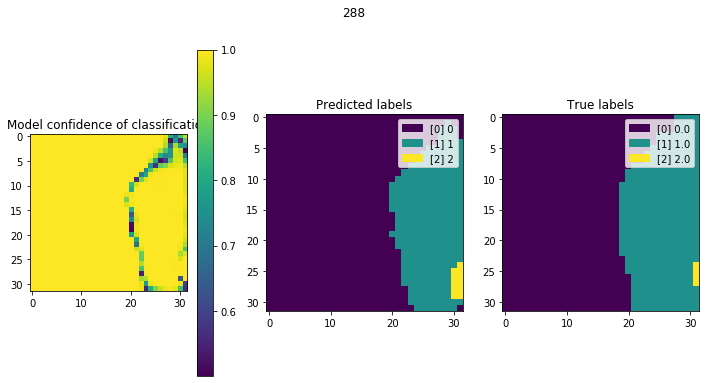

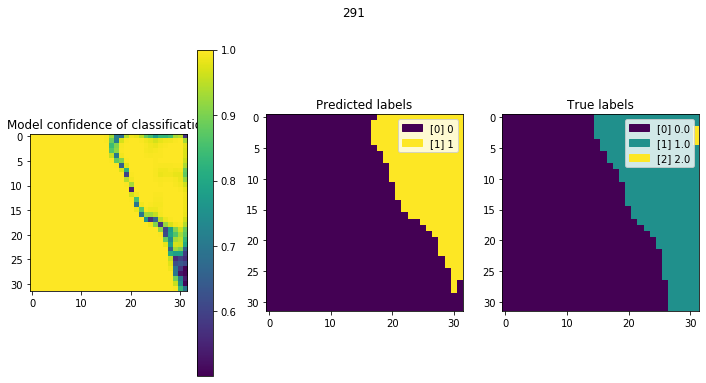

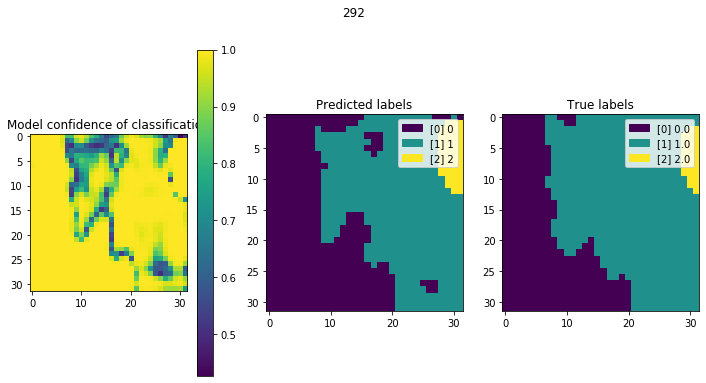

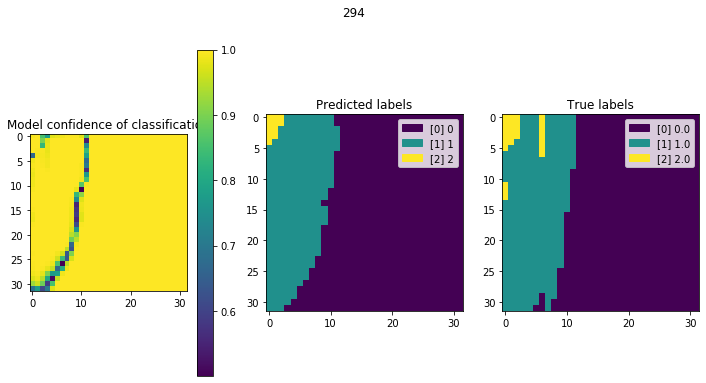

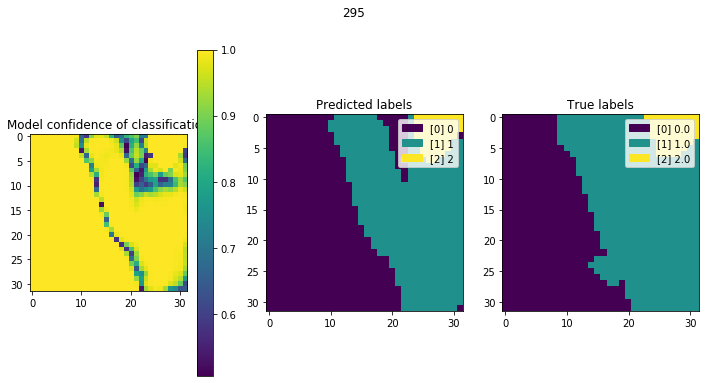

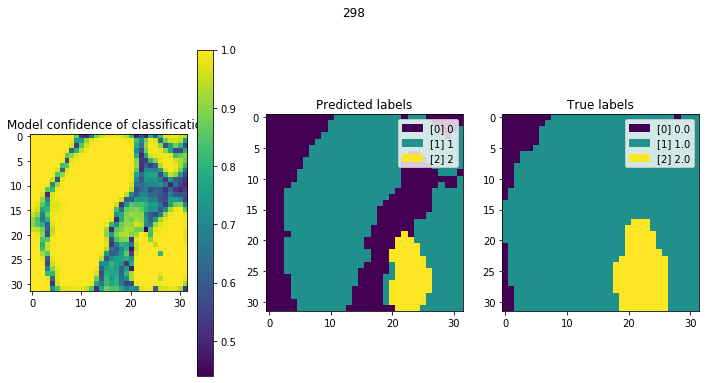

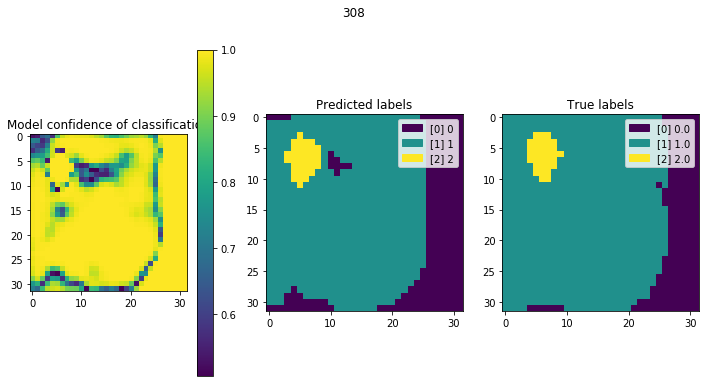

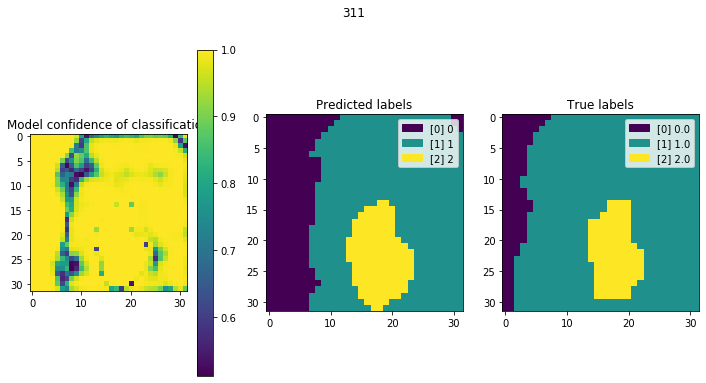

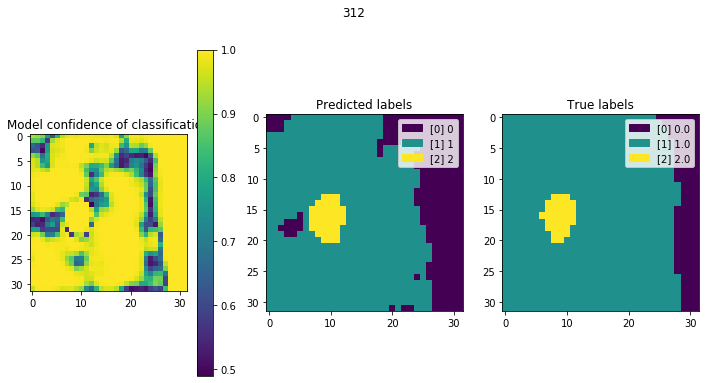

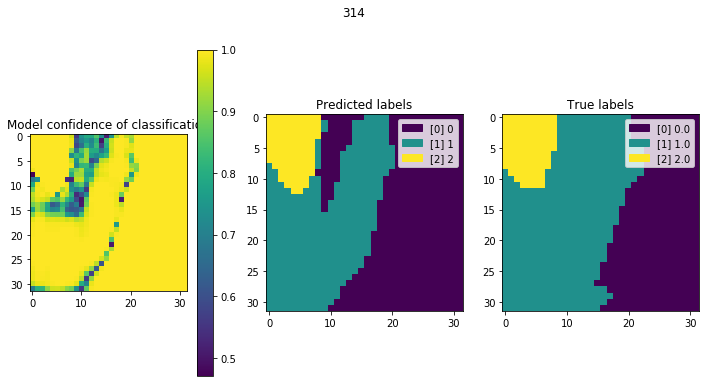

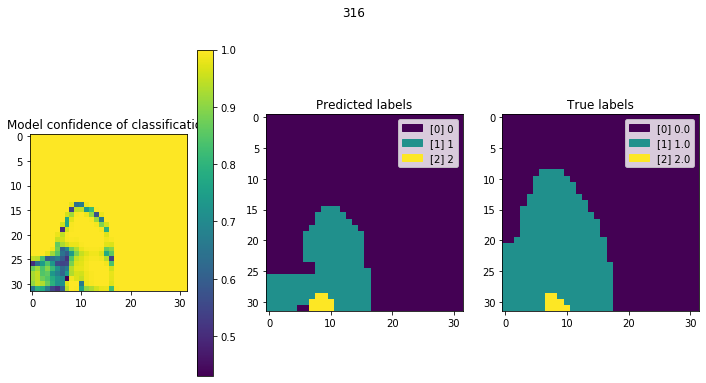

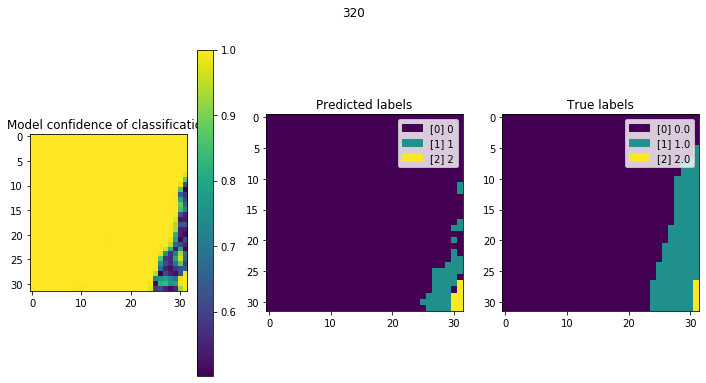

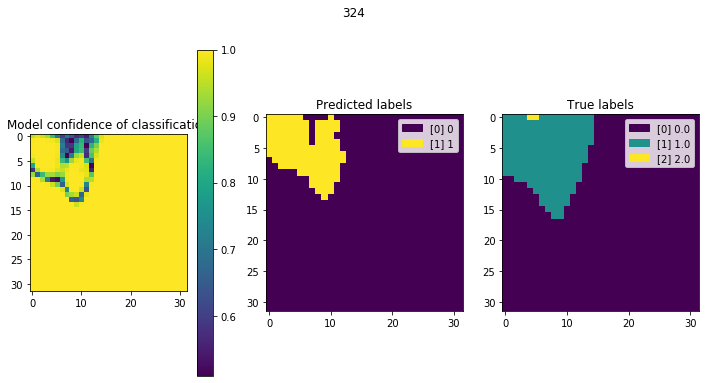

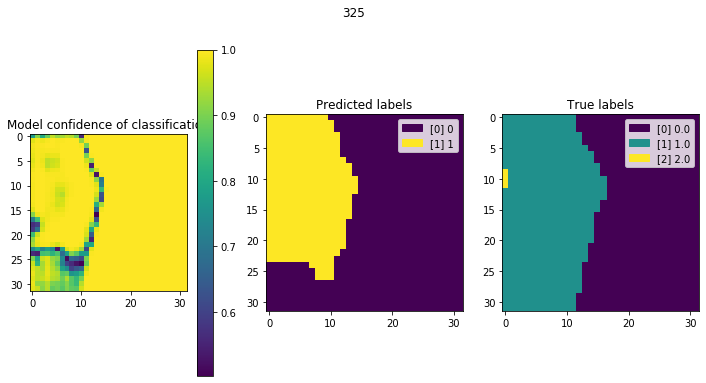

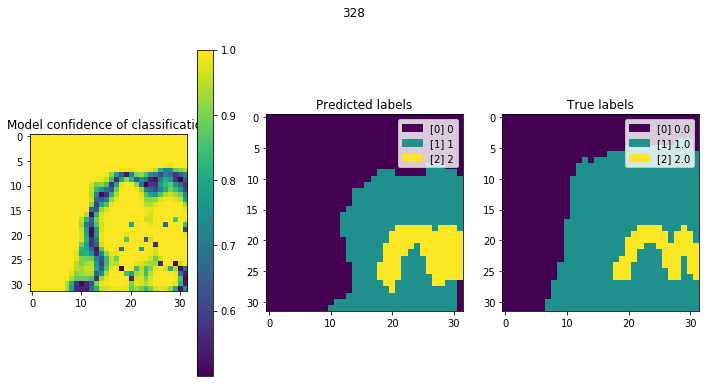

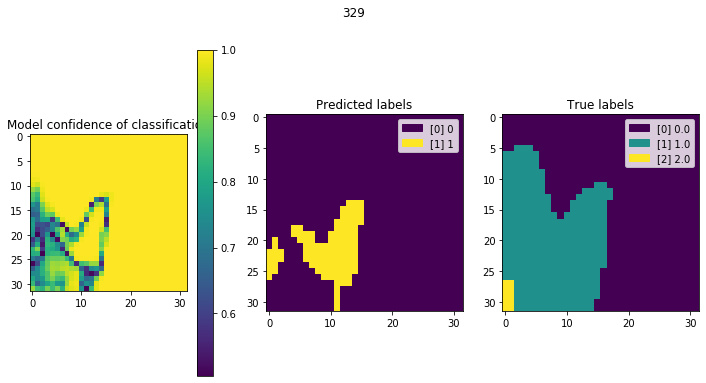

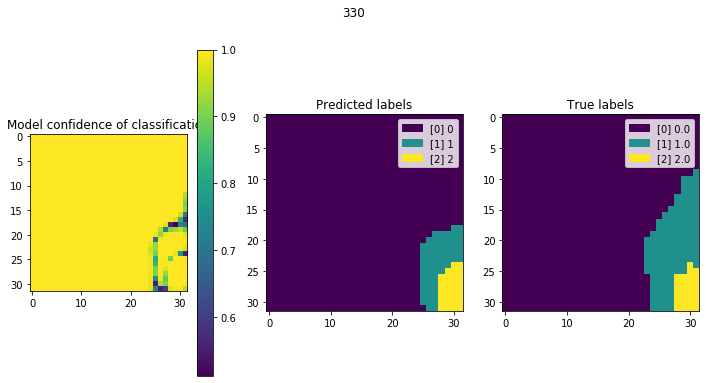

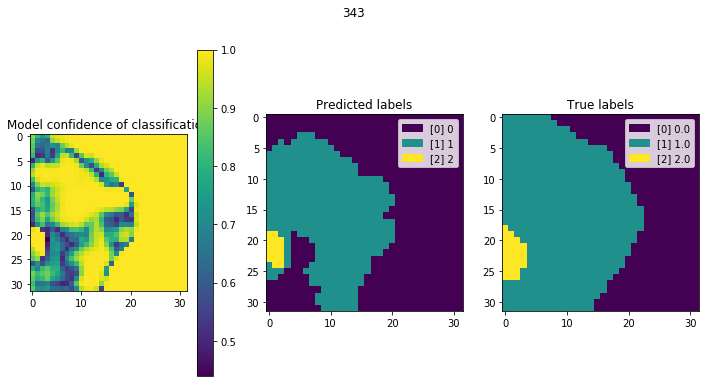

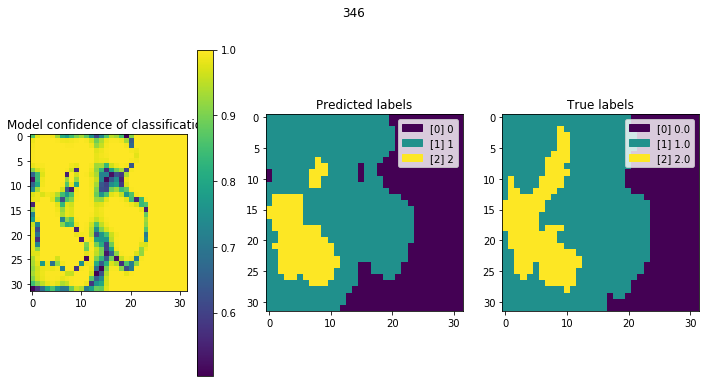

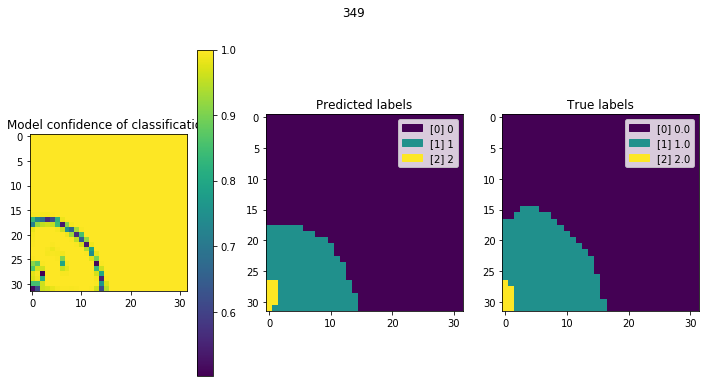

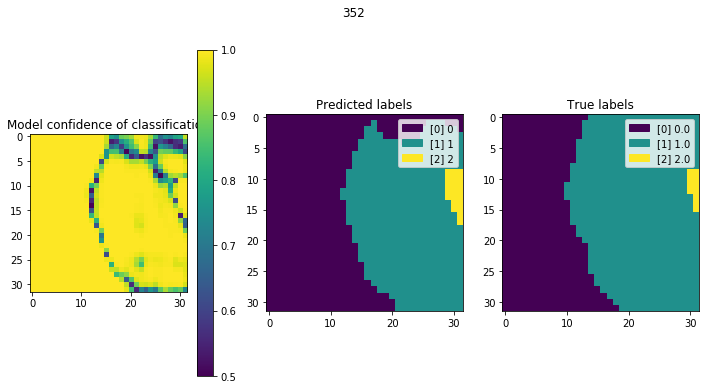

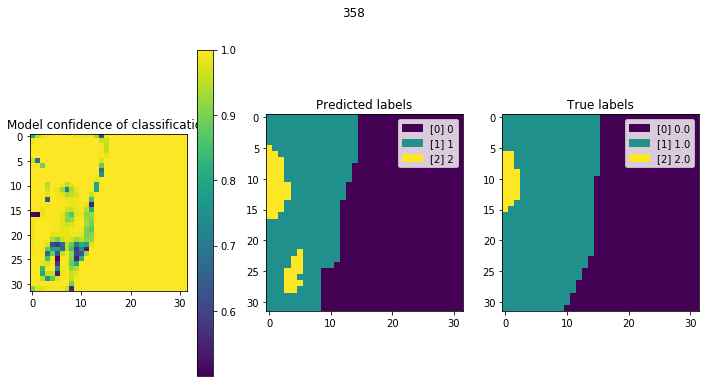

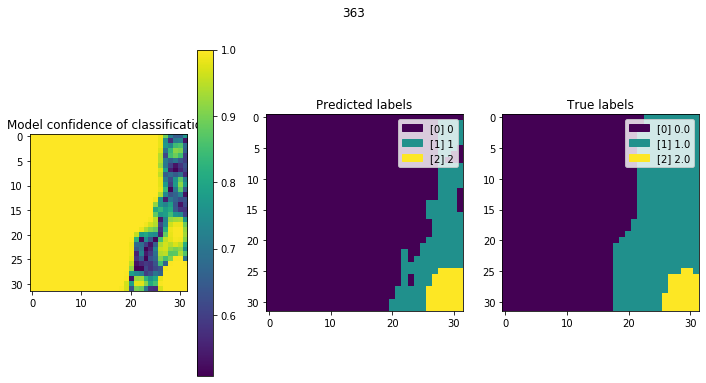

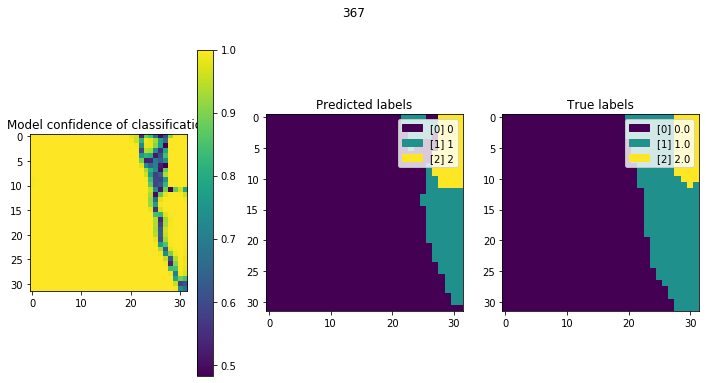

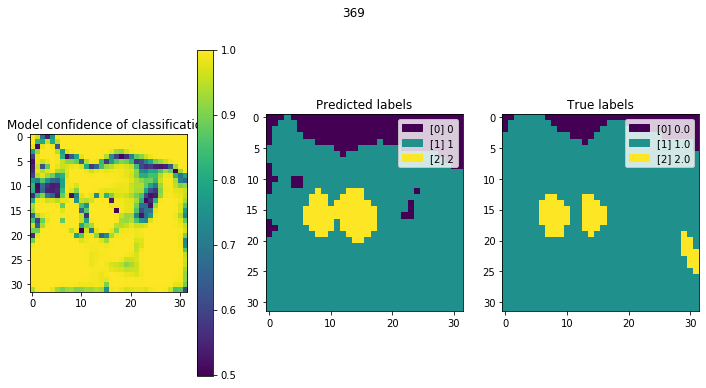

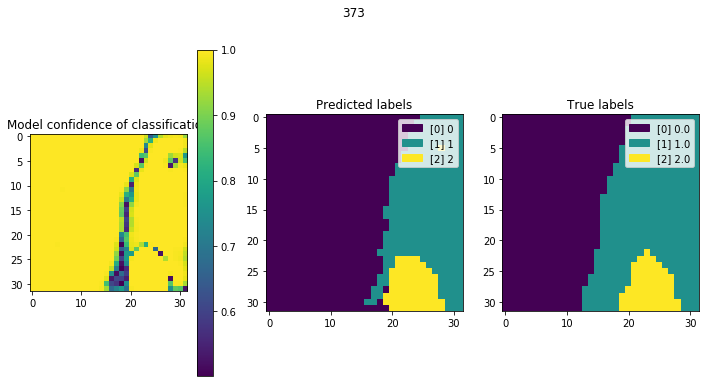

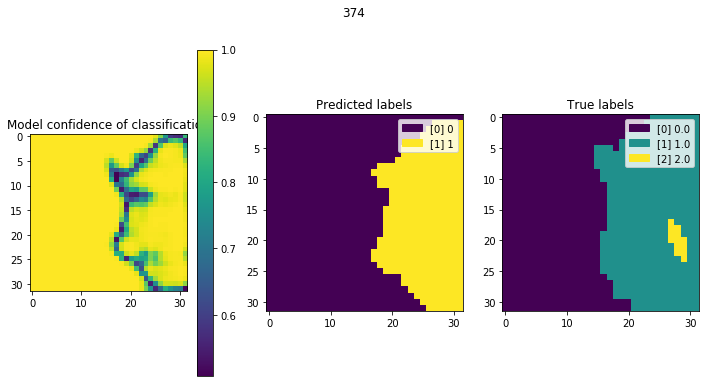

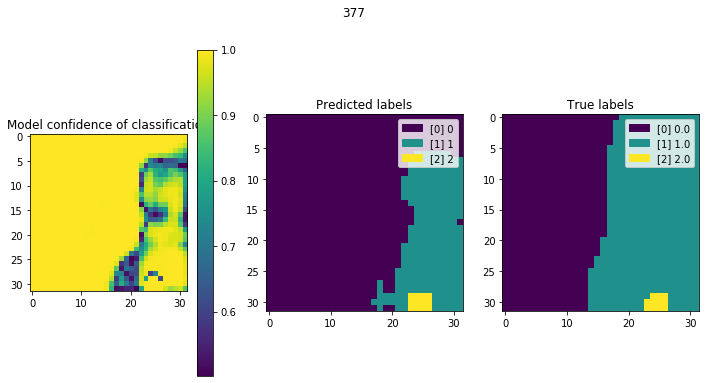

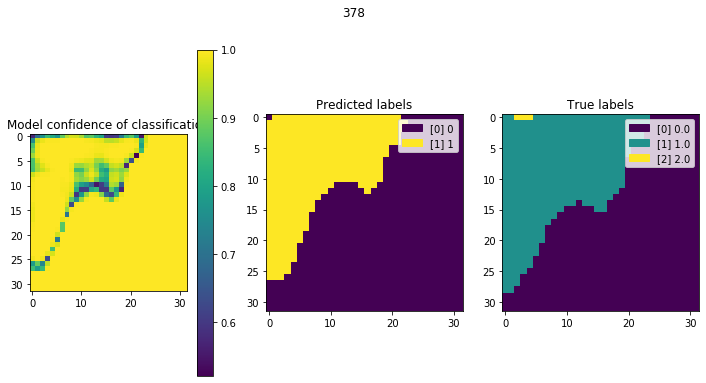

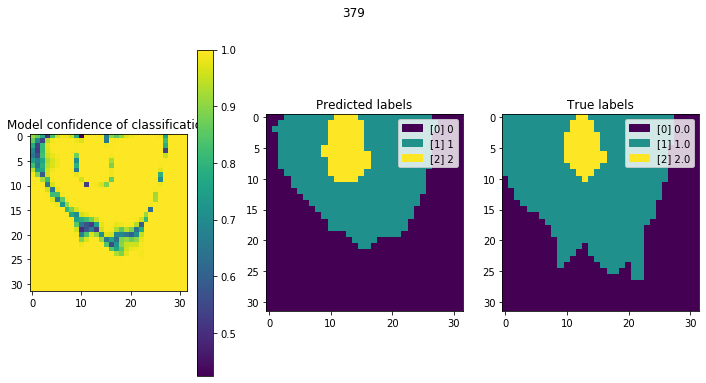

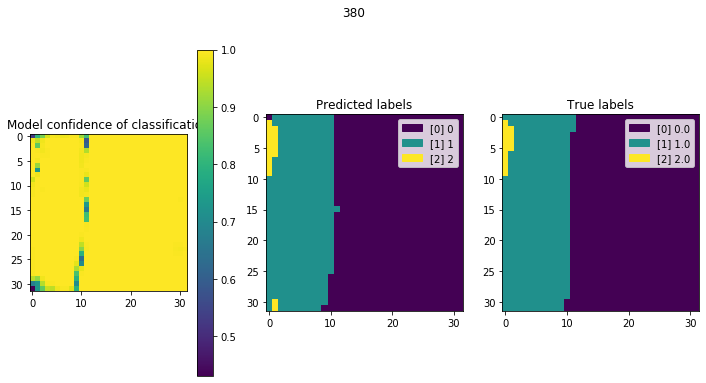

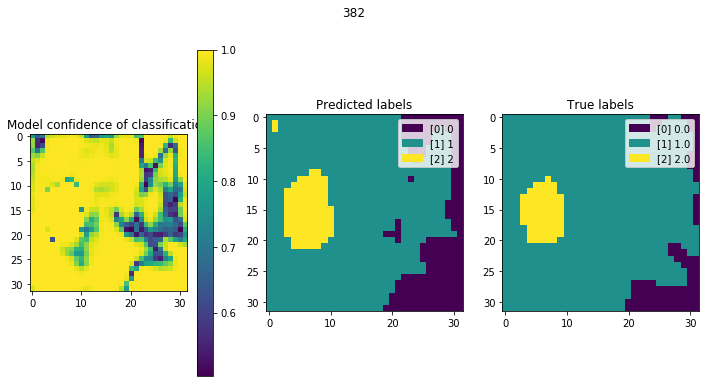

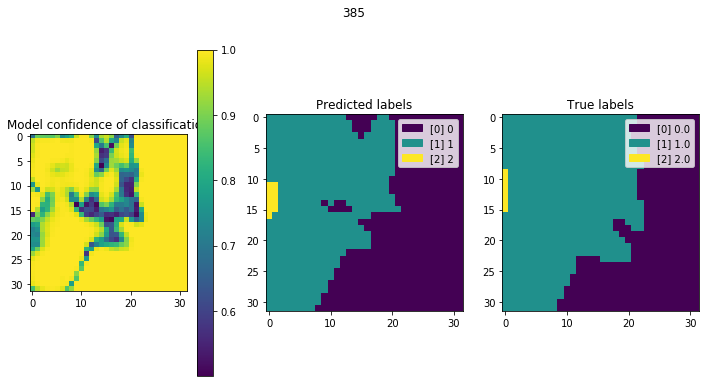

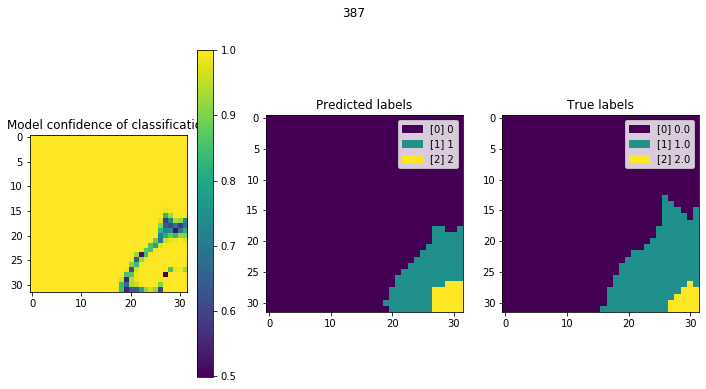

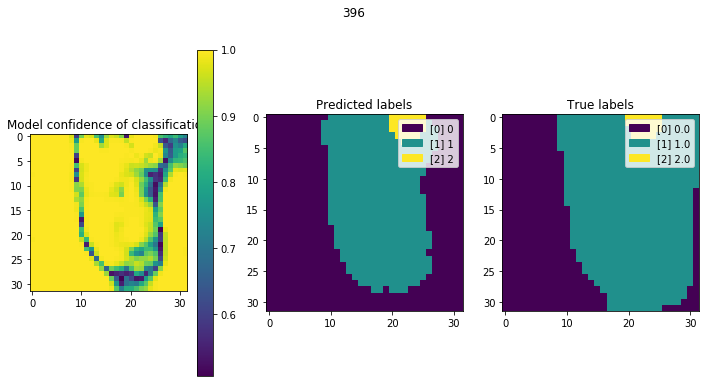

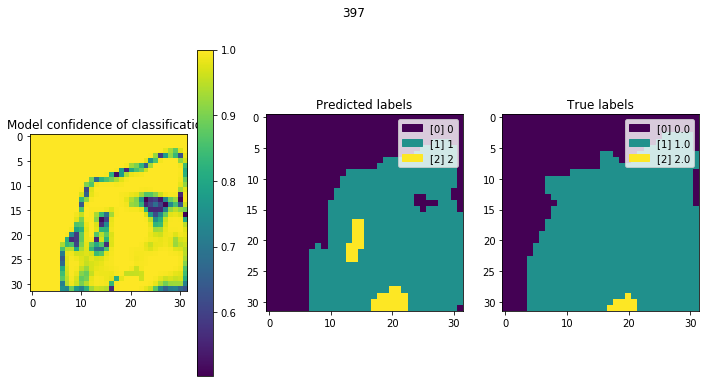

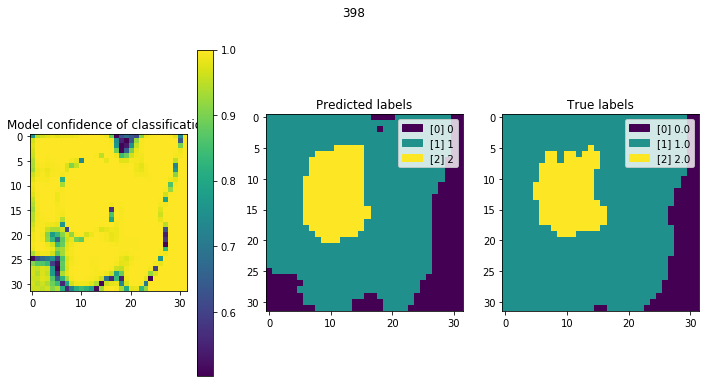

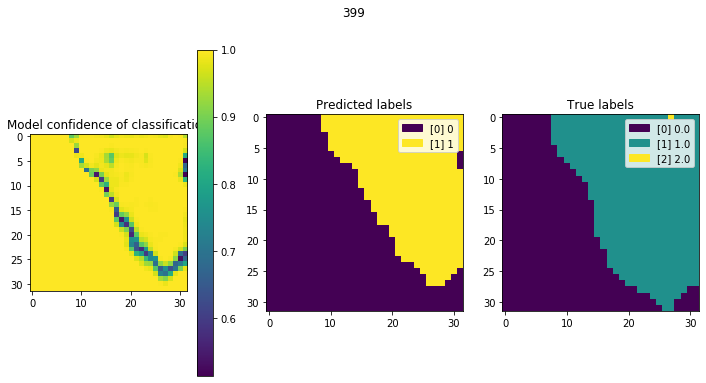

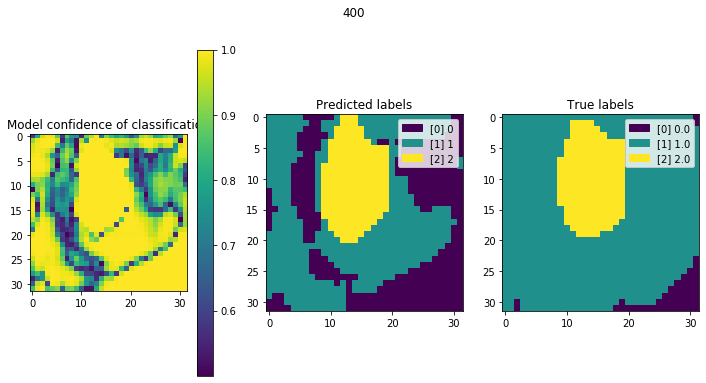

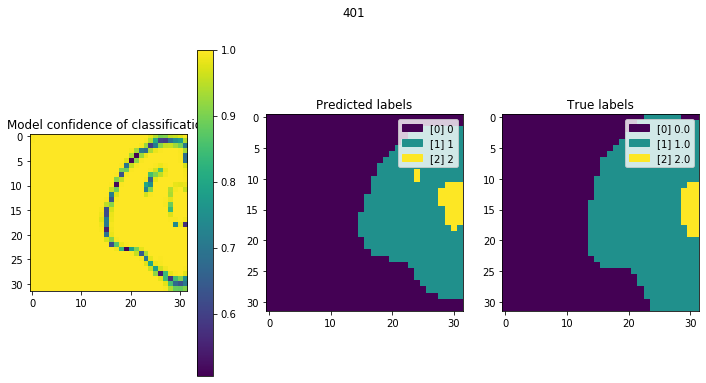

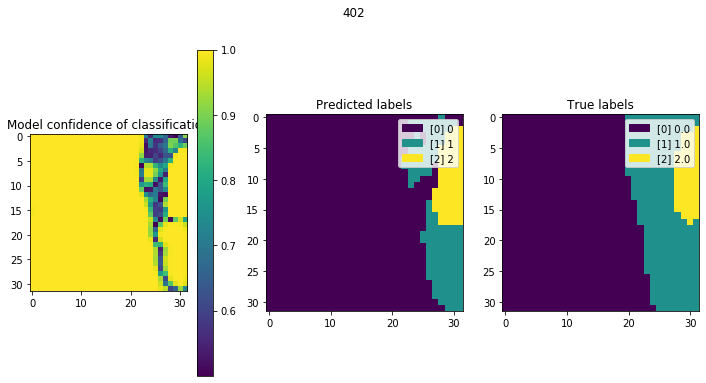

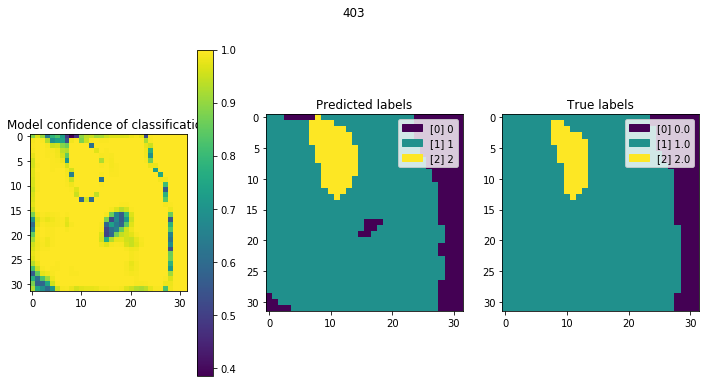

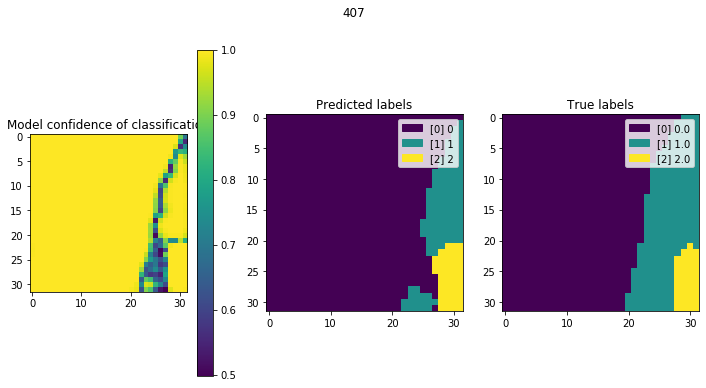

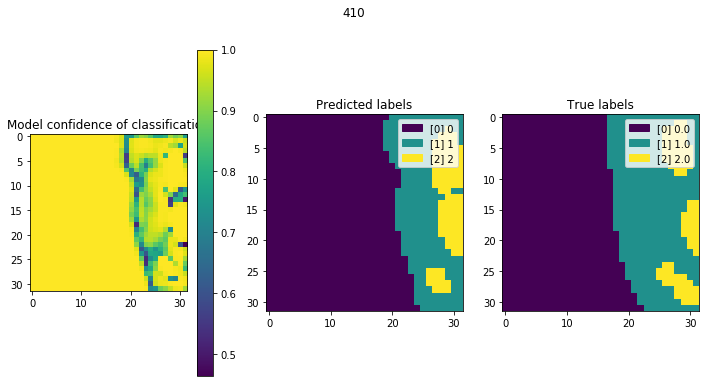

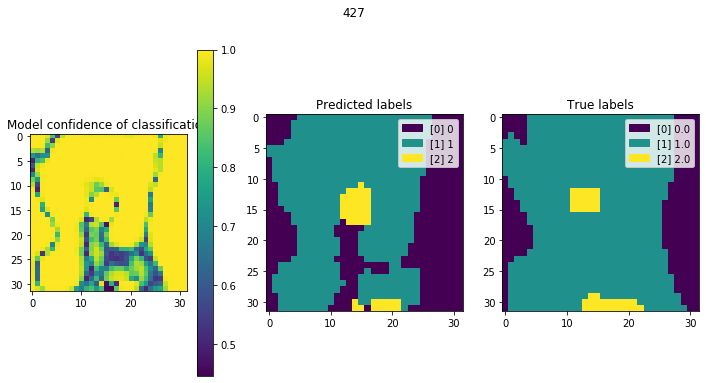

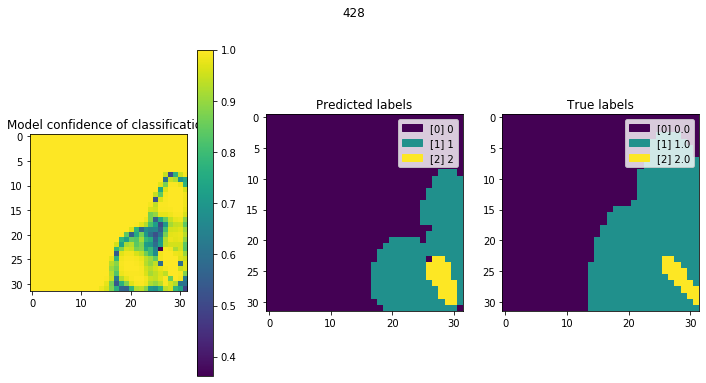

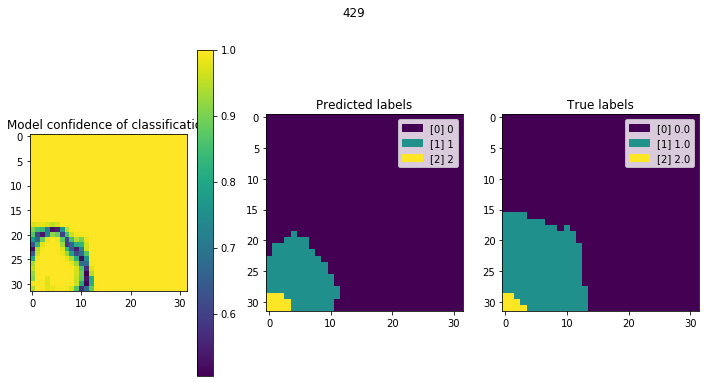

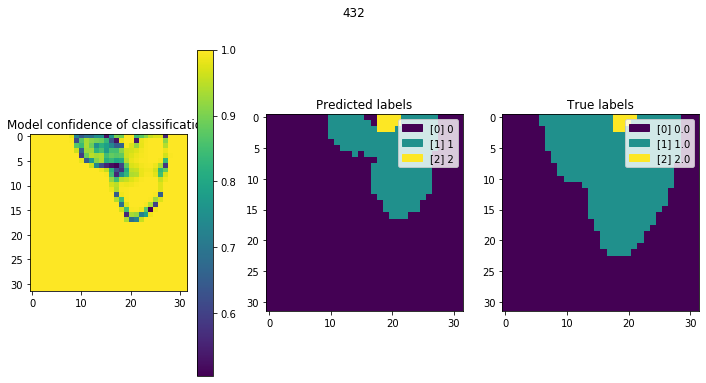

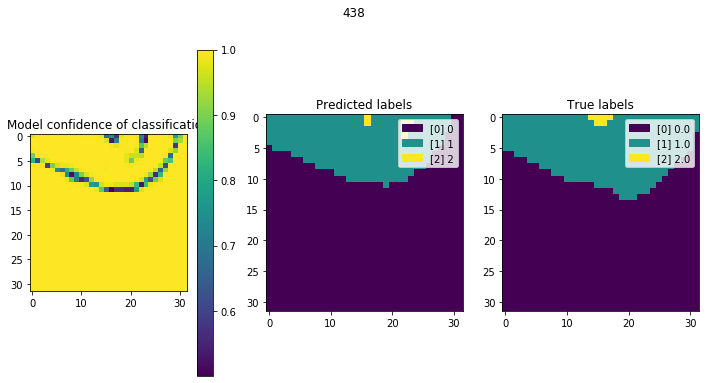

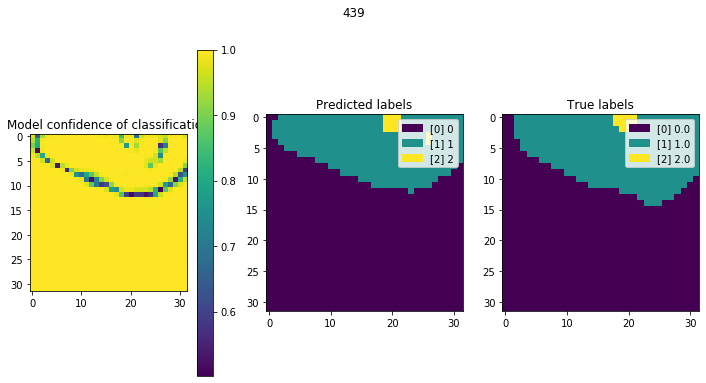

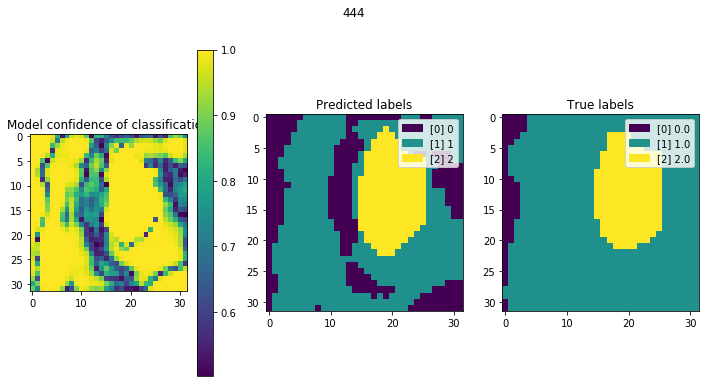

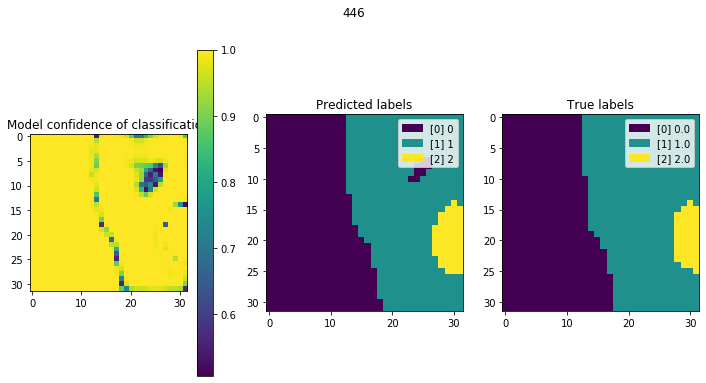

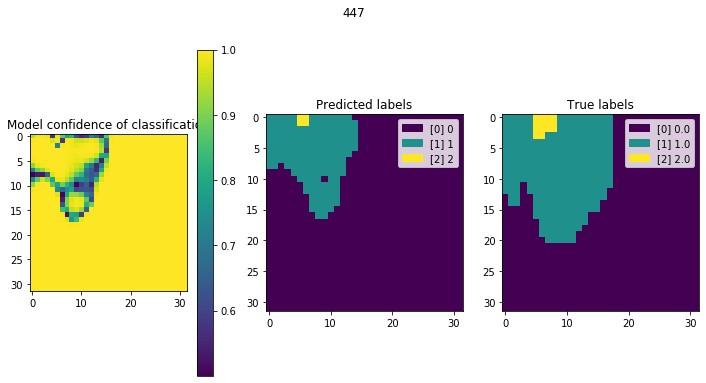

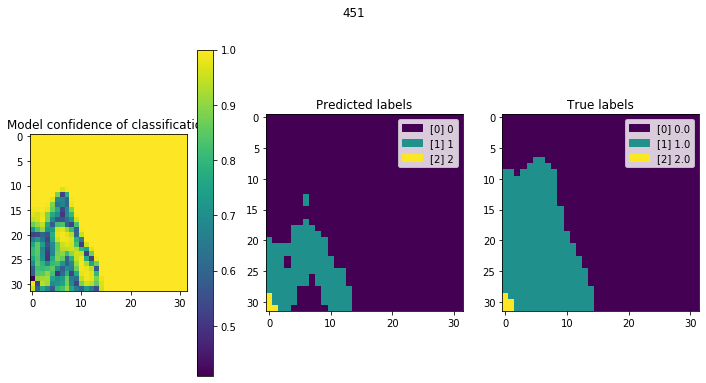

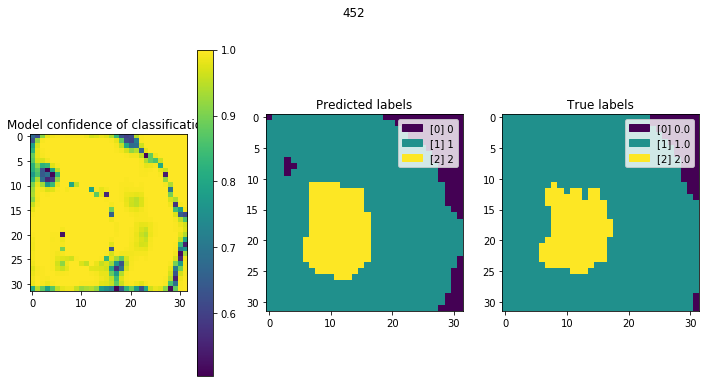

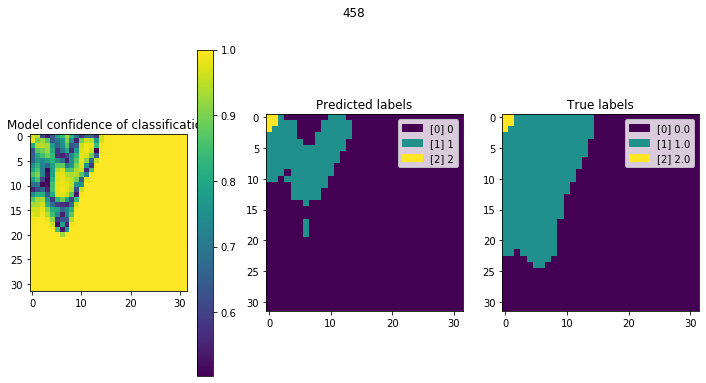

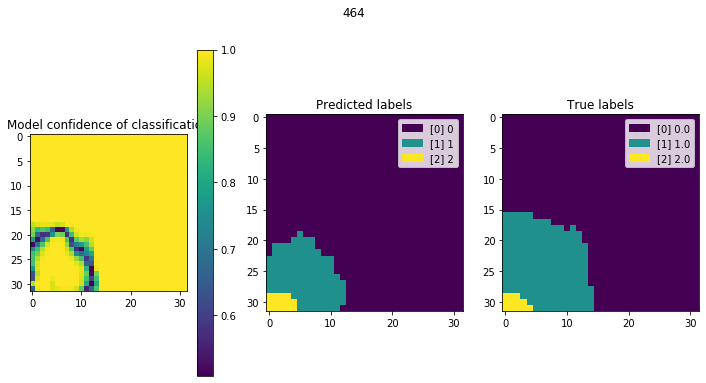

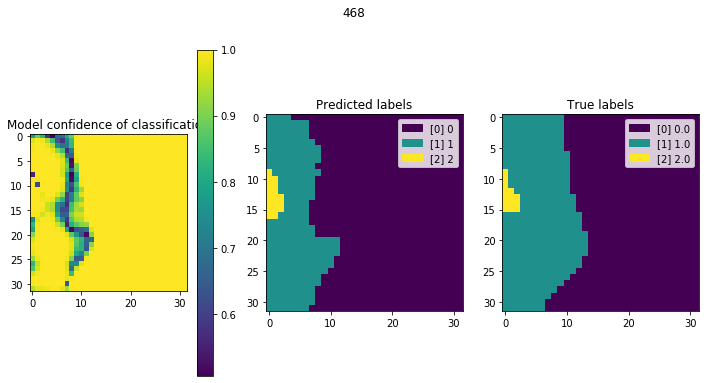

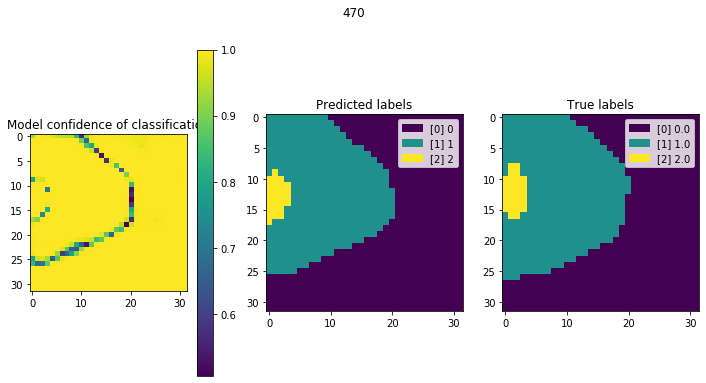

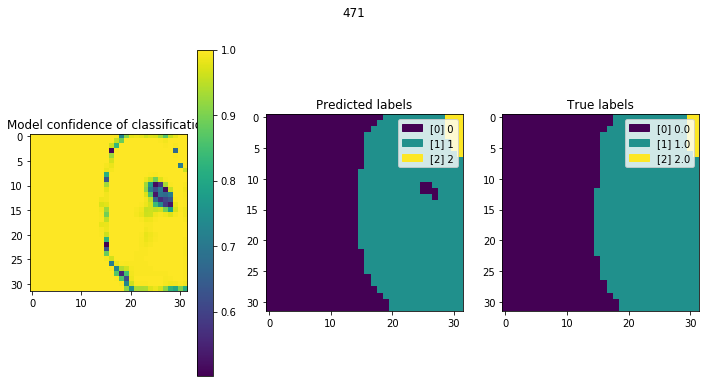

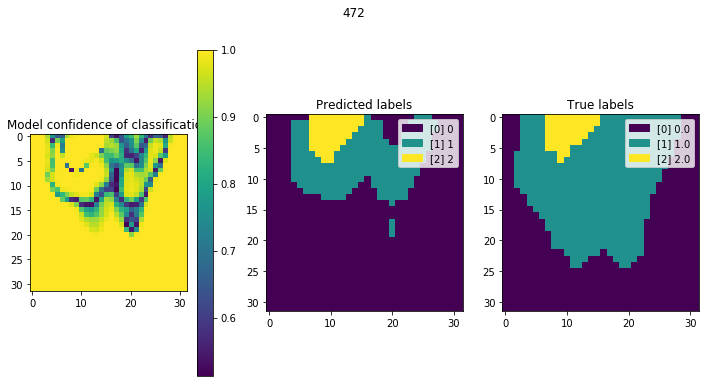

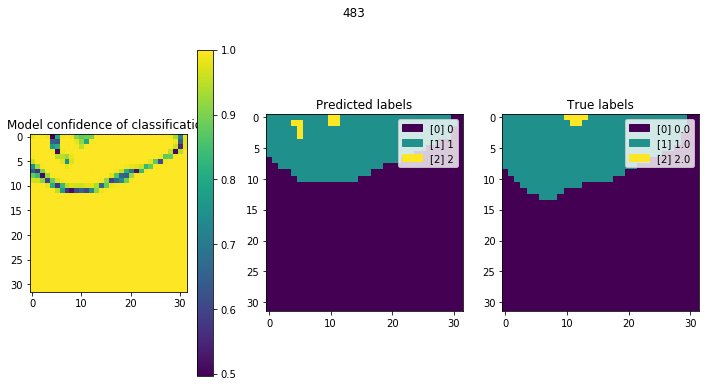

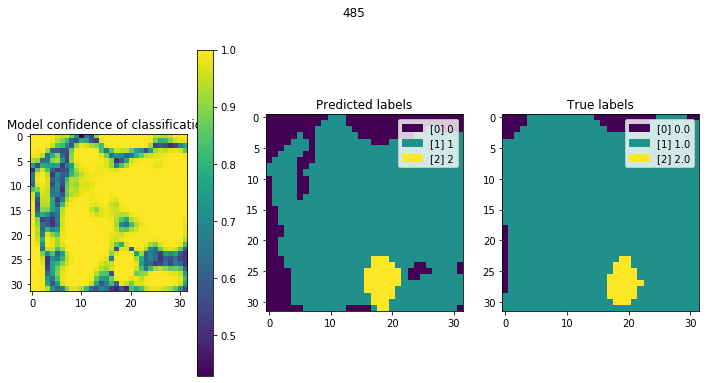

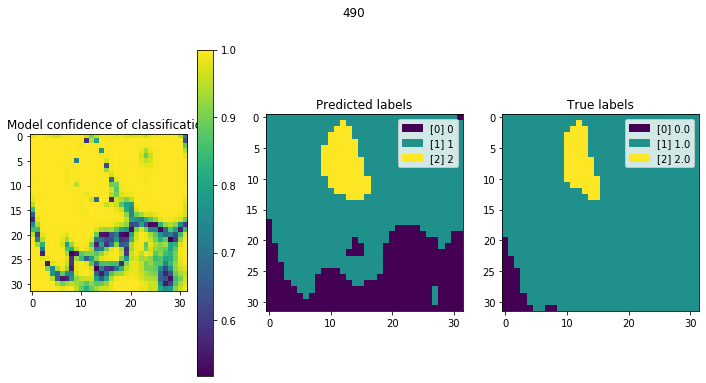

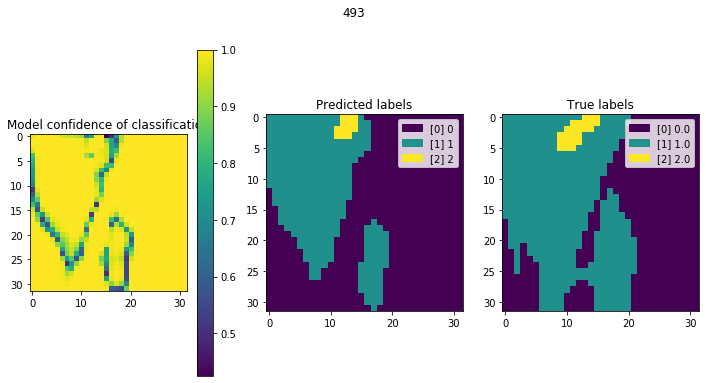

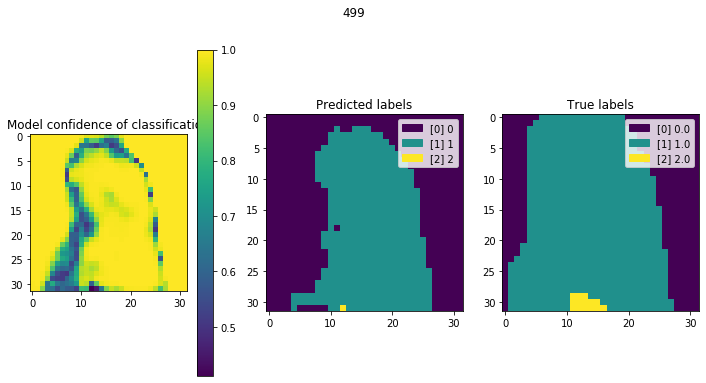

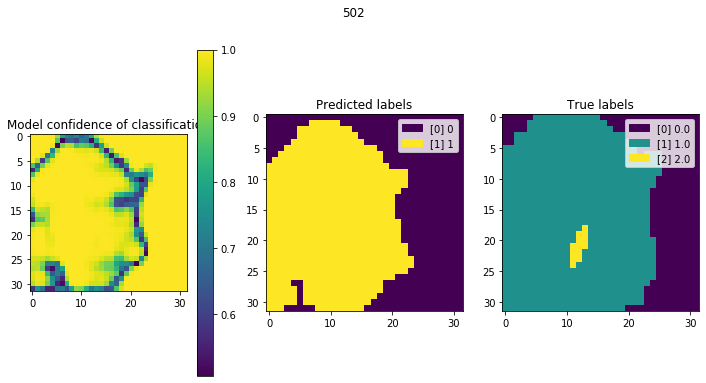

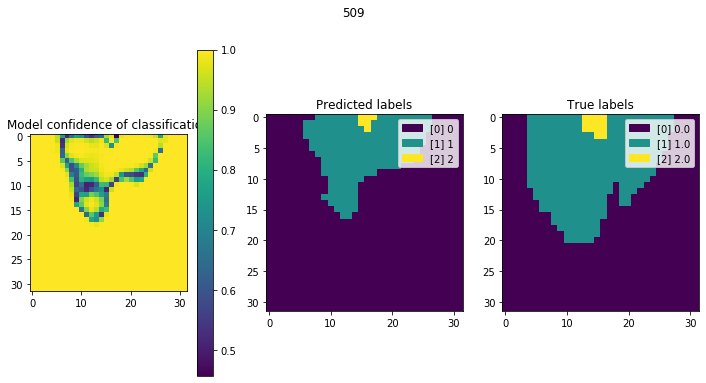

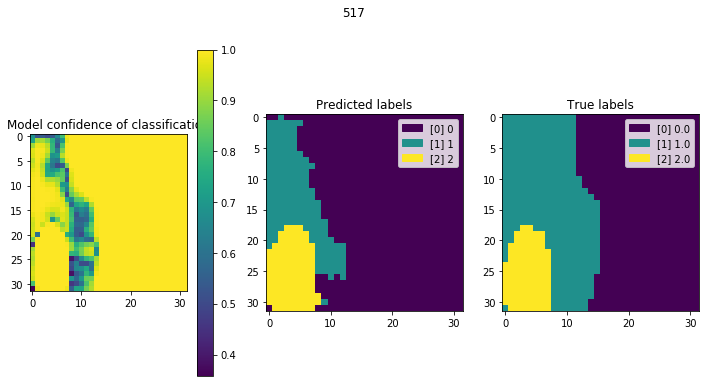

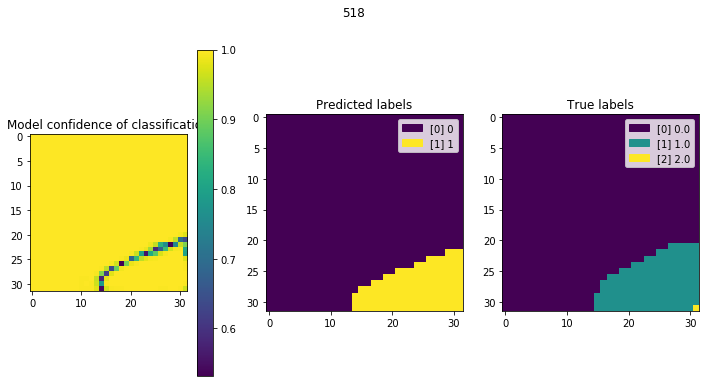

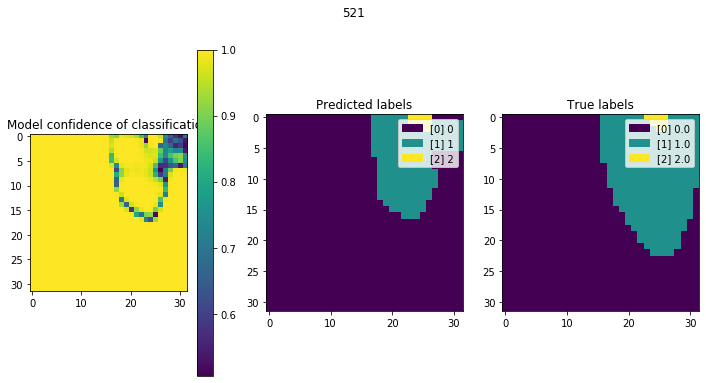

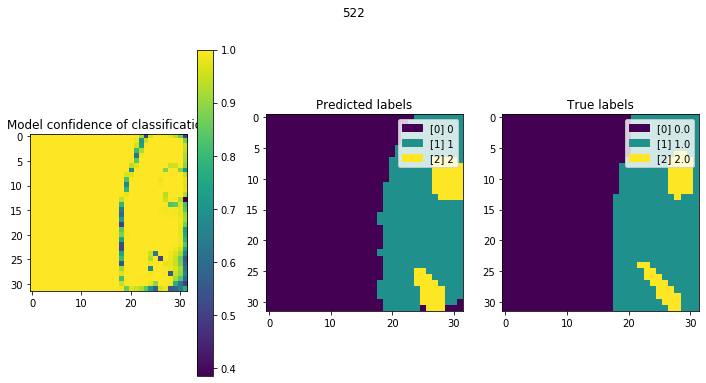

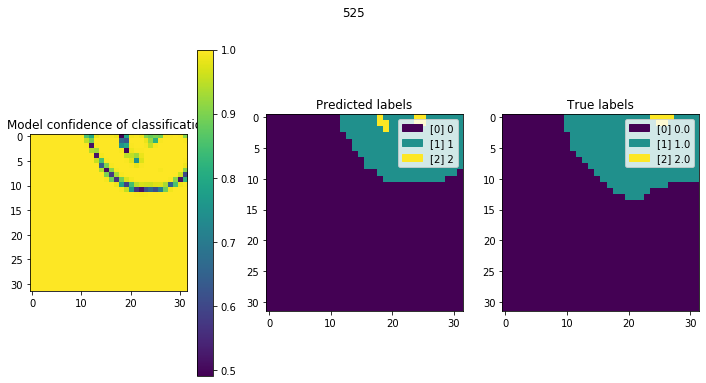

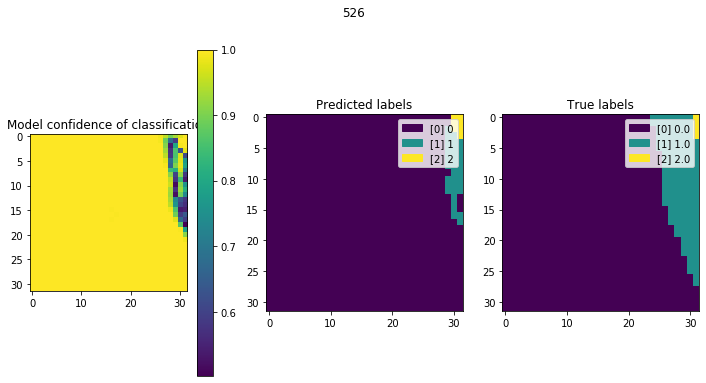

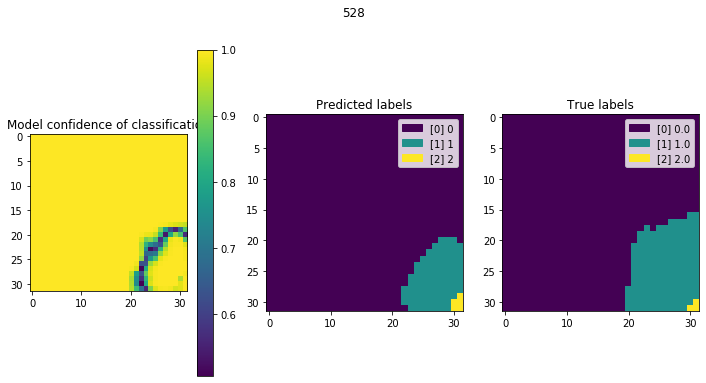

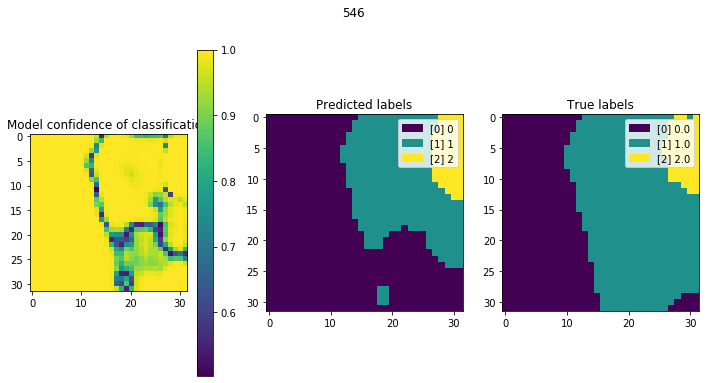

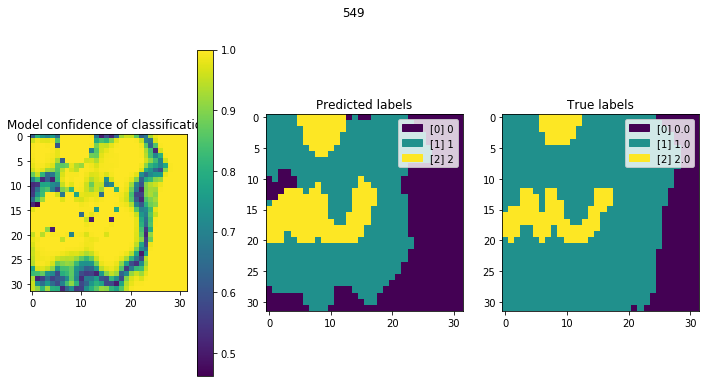

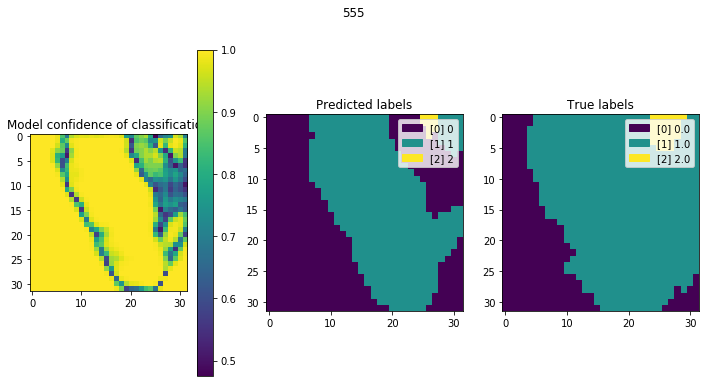

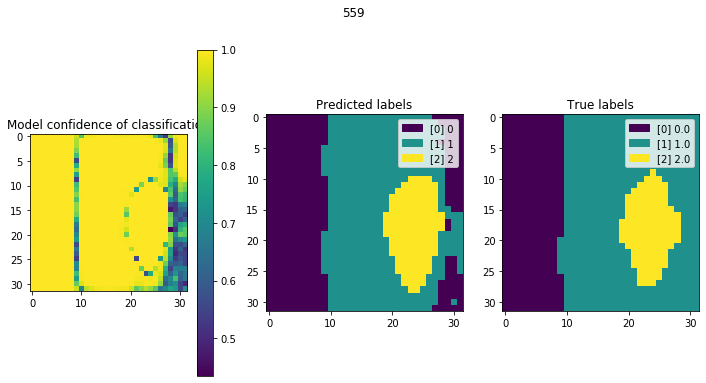

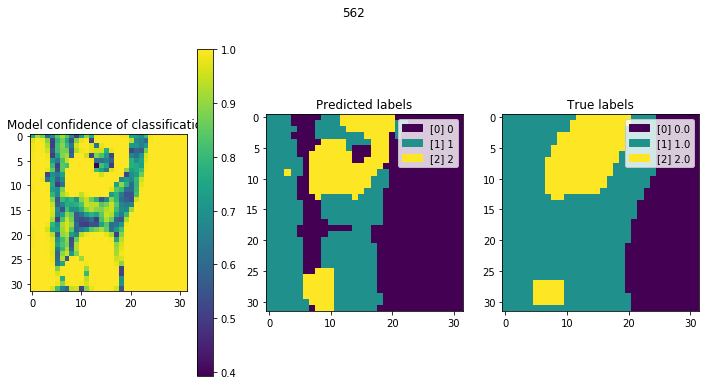

In [18]:
def get_classification_heat_map(y_hat, heat_maps):
    heat = np.zeros(y_hat.shape)
    heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
    heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
    heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
    return heat

def plot_with_heat_map(y_hat, heat_maps, y):
    heat = get_classification_heat_map(y_hat, heat_maps)

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.imshow(heat)
    plt.colorbar()
    plt.title("Model confidence of classification")
    plt.subplot(132)
    img = plt.imshow(y_hat)
    mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
    plt.title("Predicted labels")
    plt.subplot(133)
    img = plt.imshow(np.squeeze(y))
    mypackage.Dataset._Dataset__add_legend_to_image(y, img)
    plt.title("True labels")

# y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
for i in range(len(Y_test)):
    if 2 in Y_test[i]:
        plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
        plt.suptitle(i)
        

Number of layers in the base model:  49


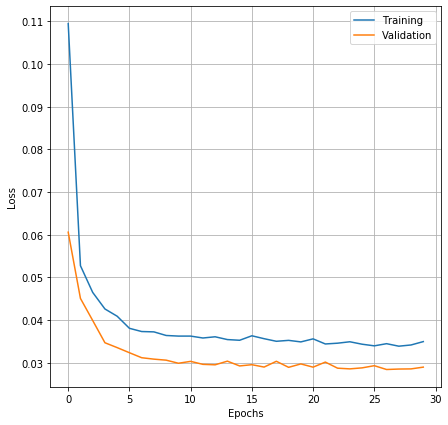

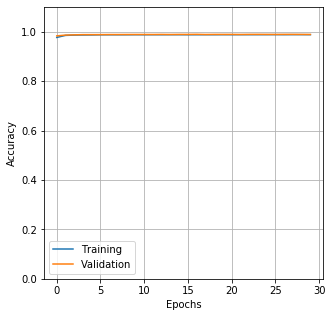

Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again
Elapsed time: 0.5296 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    455078
           1       0.98      0.95      0.97    122417
           2       0.73      0.83      0.78      6185

    accuracy                           0.99    583680
   macro avg       0.90      0.93      0.91    583680
weighted avg       0.99      0.99      0.99    583680



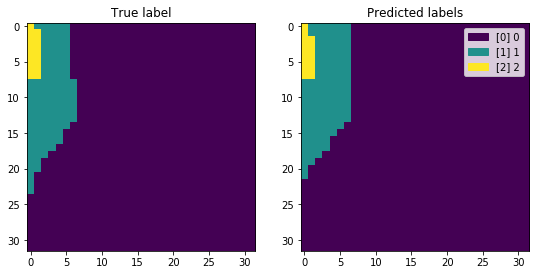

Fasle positive blobs 34


In [19]:
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss="categorical_crossentropy", validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")

In [ ]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))